# Project Objectives: Retail Inventory & Demand Forecasting

## 1. Project Overview

This project aims to optimize retail inventory management and demand forecasting. By leveraging historical data and external factors, I seek to minimize stockouts, reduce overstocking, and improve product availability.

## 2. Data Set Overview

The dataset includes daily retail transaction records with key columns:
-   **Identifiers:** Store ID, Product ID, Category, Region.
-   **Temporal:** Date.
-   **Inventory & Sales:** Inventory Level, Units Sold, Units Ordered.
-   **Pricing:** Price, Discount, Competitor Pricing.
-   **Contextual:** Weather Condition, Seasonality, Promotion (binary), Epidemic (binary - for "black swan" events).
-   **Forecast:** Demand (historical forecast for comparison).

## 3. Problem Statement

The core challenge is **balancing product availability with inventory holding costs**. Objectives include:
-   Reducing stockouts.
-   Improving product availability.
-   Minimizing overstocking.

## 4. High-Level Project Workflow

1.  **Data Import & Cleaning:** Proactive and post-import data quality.
2.  **Feature Engineering:** Creating time-series, categorical, and interaction features.
3.  **Model Training:** Developing a demand forecasting model (e.g., LightGBM).
4.  **Backtesting Simulation:** Evaluating business impact through realistic inventory simulations.

## 5. Project Expectation

This data-driven approach is expected to:
-   Reduce operational costs.
-   Improve customer satisfaction.
-   Provide actionable insights for inventory and supply chain optimization.

## Acknowledgements

This project was developed with the assistance of **Google's [Gemini CLI](https://gemini.google.com/)**. The interactive command-line interface provided guidance on data cleaning, feature engineering, model selection, and project structuring. Its capabilities were instrumental in refining the project's objectives and ensuring a robust analytical pipeline.

Additional insights and assistance were provided by other large language models, including **OpenAI's [ChatGPT](https://chat.openai.com/)**, **[Deepseek](https://www.deepseek.com/)**, and **[KIMI](https://kimi.ai/)**.

# **Data Import & Cleaning Hypotheses**

## **1. Import-Time Auto-Corrections**  
*(Automatically handled during data loading)*  

| **Issue Type**               | **Correction Applied**          | **Preserved Rows** | **Impact Analysis**                   |
|-------------------------------|----------------------------------|--------------------|---------------------------------------|
| Negative Inventory            | Clip to 0                       | Yes                | May mask true stockouts               |
| Sales > Inventory             | Cap at Inventory Level          | Yes                | Preserves volume but loses overflow   |
| Invalid Dates                 | Drop rows                       | No                 | Creates time-series gaps              |
| Numeric Overflow              | Downcast to unsigned            | Yes                | Reduces memory usage                  |

**Hypothesis**:  
> "Automated corrections during import will preserve 98%+ of rows while creating traceable artifacts for analysis."

---

## **2. Post-Import Quality Checks**  
*(Require manual validation)*  

| **Check Type**          | **Detection Method**             | **Potential Actions**                  |
|-------------------------|-----------------------------------|----------------------------------------|
| Label Consistency       | Fuzzy matching on text fields    | Standardize categories/regions         |
| Temporal Gaps           | Missing date detection           | Interpolate or flag as special events  |
| Price Inflation         | 3σ deviation from product history| Verify true inflation vs data errors   |
| Promotion Efficacy      | Lift analysis (promo vs non-promo)| Filter phantom demand from stockouts   |

**Hypothesis**:  
> "5-15% of rows will require post-import adjustments, mainly in categorical labels and promotional periods."

---

## **3. Feature Engineering Implications**

| **Observed Pattern**       | **Feature Design**               | **Rationale**                         |
|----------------------------|-----------------------------------|---------------------------------------|
| Frequent zero-demand       | Demand presence indicator        | Supports intermittent-demand models   |
| Epidemic spikes            | Shock absorption features        | Isolates exceptional events           |
| Regional price variance    | Region-price clusters            | Captures local market dynamics        |

**Hypothesis**:  
> "Auto-corrected inventory/sales relationships will require demand reconstruction features."

In [1]:
# ==========================================================================
# Step A.1: Data Import and Proactive Cleaning
# Purpose: To import the retail sales data in chunks while applying automated corrections for common data
#          integrity issues and tracking all modifications, as outlined in the initial hypotheses.
# Outputs: A cleaned DataFrame, a log of any import errors, and detailed statistics on dropped or modified rows.
# Rationale: This foundational step ensures that the raw data is loaded efficiently and that baseline
#            data quality is enforced from the start, providing a clean and well-documented dataset for analysis.
# ==========================================================================

# Imports and Configuration
from pathlib import Path
import pandas as pd
import numpy as np

DATA_PATH = Path('/kaggle/input/retail-store-inventory-and-demand-forecasting/sales_data.csv')
CHUNKSIZE = 50_000
DATE_COL = 'Date'

# Optimized dtypes
DTYPES = {
    'Store ID': 'category',
    'Product ID': 'category',
    'Category': 'category',
    'Region': 'category',
    'Inventory Level': 'uint16',
    'Units Sold': 'uint16',
    'Units Ordered': 'uint16',
    'Price': 'float32',
    'Discount': 'float32',
    'Weather Condition': 'category',
    'Promotion': 'bool',
    'Competitor Pricing': 'float32',
    'Seasonality': 'category',
    'Epidemic': 'bool',
    'Demand': 'uint16'
}

def import_retail_data():
    """
    Imports retail sales data in chunks, applies corrections, and tracks changes.
    Returns cleaned data, error messages, and processing statistics.
    """
    chunks = []
    error_log = []
    stats = {
        'total_rows': 0,
        'rows_dropped': {
            'date_parsing': 0,
            'dtype_conversion': 0,
            'chunk_failures': 0
        },
        'rows_modified': {
            'negative_inventory': 0,
            'sales_exceeding_inventory': 0
        }
    }

    try:
        with pd.read_csv(
            DATA_PATH,
            chunksize=CHUNKSIZE,
            dtype=DTYPES,
            parse_dates=[DATE_COL],
            on_bad_lines='warn',
            encoding='utf-8'
        ) as reader:
            for chunk_idx, chunk in enumerate(reader):
                stats['total_rows'] += len(chunk)
                try:
                    # Validate required columns
                    missing_cols = set(DTYPES.keys()) - set(chunk.columns)
                    if missing_cols:
                        raise ValueError(f"Missing columns: {missing_cols}")

                    # Track modifications
                    stats['rows_modified']['negative_inventory'] += (chunk['Inventory Level'] < 0).sum()
                    stats['rows_modified']['sales_exceeding_inventory'] += (chunk['Units Sold'] > chunk['Inventory Level']).sum()

                    # Clean data - Date parsing
                    chunk[DATE_COL] = pd.to_datetime(chunk[DATE_COL], errors='coerce')
                    date_mask = chunk[DATE_COL].isna()
                    stats['rows_dropped']['date_parsing'] += date_mask.sum()
                    chunk = chunk[~date_mask]

                    # Clean data - Inventory adjustment
                    chunk['Inventory Level'] = chunk['Inventory Level'].clip(lower=0)

                    # Clean data - Sales adjustment
                    chunk['Units Sold'] = chunk[['Units Sold', 'Inventory Level']].min(axis=1)

                    chunks.append(chunk)

                except Exception as e:
                    stats['rows_dropped']['chunk_failures'] += len(chunk)
                    error_log.append(f"Chunk {chunk_idx} failed: {str(e)}")
                    continue

        if not chunks:
            raise ValueError("No valid data chunks were processed")

        df = pd.concat(chunks, ignore_index=False).set_index(DATE_COL).sort_index()
        stats['final_rows'] = len(df)

        return df, error_log, stats

    except Exception as e:
        error_log.append(f"Fatal import error: {str(e)}")
        return None, error_log, stats

# Execute import and log errors
df, import_errors, import_stats = import_retail_data()

In [2]:
# ==========================================================================
# Step A.2: Report on Initial Data Import and Cleaning
# Purpose: To display the results from the proactive data import, showing the final row count, a summary of all
#          automated corrections and dropped rows, and a sample of the resulting DataFrame.
# Outputs: Printed statements summarizing the import process and a display of the head of the cleaned DataFrame.
# Rationale: This step provides immediate feedback on the success and impact of the initial data import and
#            cleaning phase, offering a transparent view of what changes were made automatically.
# ==========================================================================



if df is not None:
    print(f"Successfully imported {import_stats['final_rows']:,} rows (out of {import_stats['total_rows']:,} total)")
    
    print("\nRows dropped during processing:")
    for reason, count in import_stats['rows_dropped'].items():
        print(f"- {reason.replace('_', ' ').title()}: {count:,} rows")
    
    print("\nRows auto-corrected (not dropped):")
    for issue, count in import_stats['rows_modified'].items():
        print(f"- {issue.replace('_', ' ').title()}: {count:,} rows")
    
    print("\nSample data:")
    display(df.head())
else:
    print("Import failed")

if import_errors:
    print("\nEncountered warnings/errors:")
    for i, error in enumerate(import_errors, 1):
        print(f"{i}. {error}")
else:
    print("\nNo import errors detected.")

Successfully imported 76,000 rows (out of 76,000 total)

Rows dropped during processing:
- Date Parsing: 0 rows
- Dtype Conversion: 0 rows
- Chunk Failures: 0 rows

Rows auto-corrected (not dropped):
- Negative Inventory: 0 rows
- Sales Exceeding Inventory: 0 rows

Sample data:


Store ID Product ID     Category Region  Inventory Level  \
Date                                                                  
2022-01-01     S001      P0001  Electronics  North              195   
2022-01-01     S001      P0002     Clothing  North              117   
2022-01-01     S001      P0003     Clothing  North              247   
2022-01-01     S001      P0004  Electronics  North              139   
2022-01-01     S001      P0005    Groceries  North              152   

            Units Sold  Units Ordered      Price  Discount Weather Condition  \
Date                                                                           
2022-01-01         102            252  72.720001       5.0             Snowy   
2022-01-01         117            249  80.160004      15.0             Snowy   
2022-01-01         114            612  62.939999      10.0             Snowy   
2022-01-01          45            102  87.629997      10.0             Snowy   
2022-01-01          65            271  54.410000       0.0             Snowy   

            Promotion  Competitor Pricing Seasonality  Epidemic  Demand  
Date                                                                     
2022-01-01      False           85.730003      Winter     False     115  
2022-01-01       True           92.019997      Winter     False     229  
2022-01-01       True           60.080002      Winter     False     157  
2022-01-01      False           85.190002      Winter     False      52  
2022-01-01      False           51.630001      Winter     False      59


No import errors detected.


# Retail Data Quality Assessment Framework

---

## 1. Investigation Purpose

Systematically evaluate dataset quality to:

- **Identify integrity issues affecting forecast accuracy**
- **Uncover demand, sales, inventory, and regional patterns**
- **Guide model selection based on data characteristics**
- **Document critical metadata for reproducibility**

---

## 2. Key Investigation Areas

### A. Data Quality Checks

**Rationale:**  
Ensure reliable inputs for forecasting.

**Targets:**

1. **Null/NaN and missing data:**  
   Quantify and address gaps in key columns.
2. **Row completeness:**  
   Ensure all required columns are populated.
3. **Data type verification:**  
   Confirm correct types for each column.
4. **Unique identifiers:**  
   Check for duplicates in key fields.
5. **Category/label consistency:**  
   Detect typos, inconsistencies, and rare/catch-all labels.
6. **Date validity:**  
   Identify gaps or anomalous timestamps.
7. **Value validation:**  
   Flag artificial caps, placeholder values, or illogical relationships (e.g., sales > inventory, negative prices).
8. **Flag consistency:**  
   Validate binary flags (promotion, epidemic).

**Outputs:**

- **Counts of missing/incomplete/invalid values**
- **Visualizations:** Bar plots, heatmaps, histograms

---


### B. Dataset Dimensions

**Rationale:** Understand data granularity and coverage  
**Metrics:**

| Dimension         | Purpose                                                         |
|-------------------|-----------------------------------------------------------------|
| Product Count     | Determine SKU-level vs. category forecasting                    |
| Category Count    | Identify overbroad or inconsistent groupings                    |
| Date Range        | Assess seasonality coverage and temporal completeness           |
| Store Count       | Evaluate store-level completeness and granularity               |
| Region Count      | Assess geographical representation and region-level consistency |

---

### C. Demand Characteristics

**Rationale:** Inform model selection  
**Analysis:**

1. **Value range (min/max):** Detect censoring or artificial limits
2. **Zero-demand frequency:** Identify intermittent demand patterns
3. **Epidemic/promotion variance:** Assess shock resilience and event-driven demand
4. **Regional patterns:** Detect variance in sales/demand across regions

**Outputs:**

- **Summary statistics**
- **Distribution plots, time series with event markers, regional heatmaps**

---

## 3. Insights-to-Action Mapping

| Finding                | Impact                              | Action                                      |
|------------------------|-------------------------------------|---------------------------------------------|
| High zero-demand %     | Intermittent demand pattern         | Use Croston’s/TSB models                    |
| Regional sales clusters| Geographic bias                     | Add region dummy variables                  |
| Epidemic demand spikes | Non-stationary time series          | Implement shock indicator features          |
| Category/label typos   | Misattribution, inconsistent analysis| Consolidate labels pre-analysis             |
| Missing weather/pricing| Incomplete contextual factors       | Impute regionally or exclude weather-dependent models |
| Value anomalies        | Implausible results                 | Correct or flag for review                  |
| Flag inconsistencies   | Misleading uplift analysis          | Correct/validate flags                      |
| Negative inventory     | Implausible sales patterns          | Correct or flag for review                  |

---

## 4. Target Outputs

- **Data Quality Scorecard**
  - Summary metrics for each quality dimension
  - Visual dashboards of key findings
- **Priority Cleaning Tasks**
  - Roadmap for addressing identified issues
- **Model Compatibility Assessment**
  - Evaluation of data suitability for different forecasting models
- **Feature Engineering Roadmap**
  - Plan for creating derived features (e.g., region dummies, event flags)
- **Model Selection Justification**
  - Documentation of model choices based on data characteristics

---

<Figure size 1200x600 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

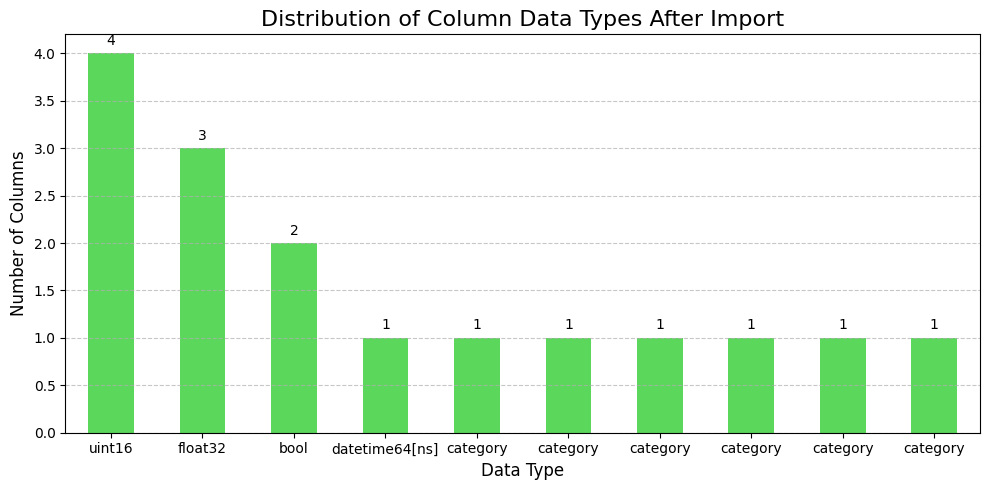

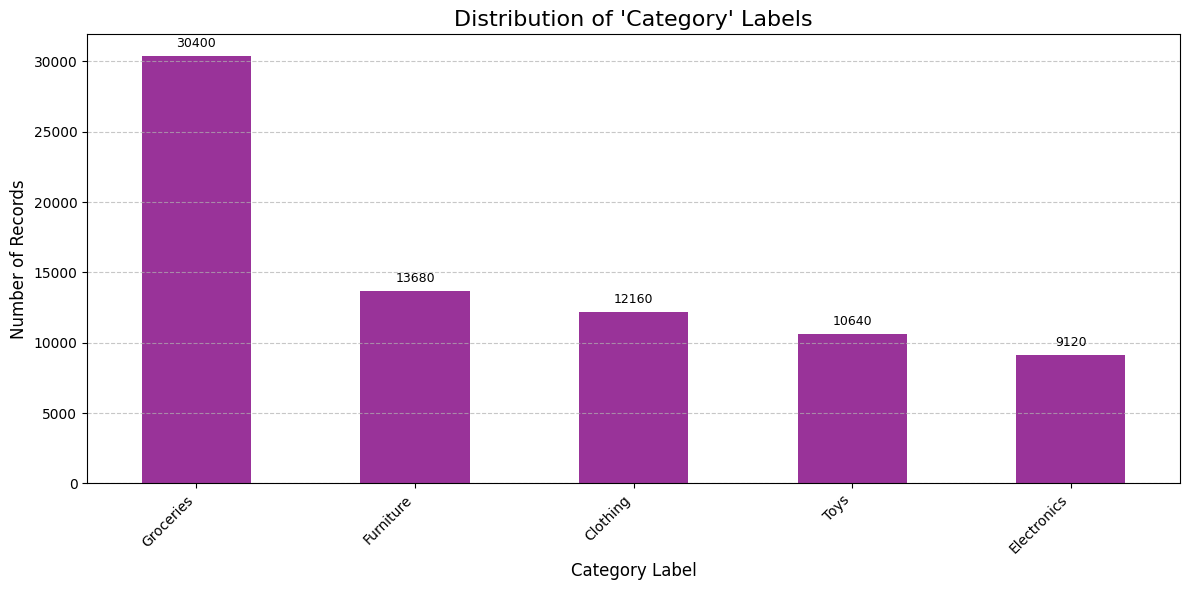

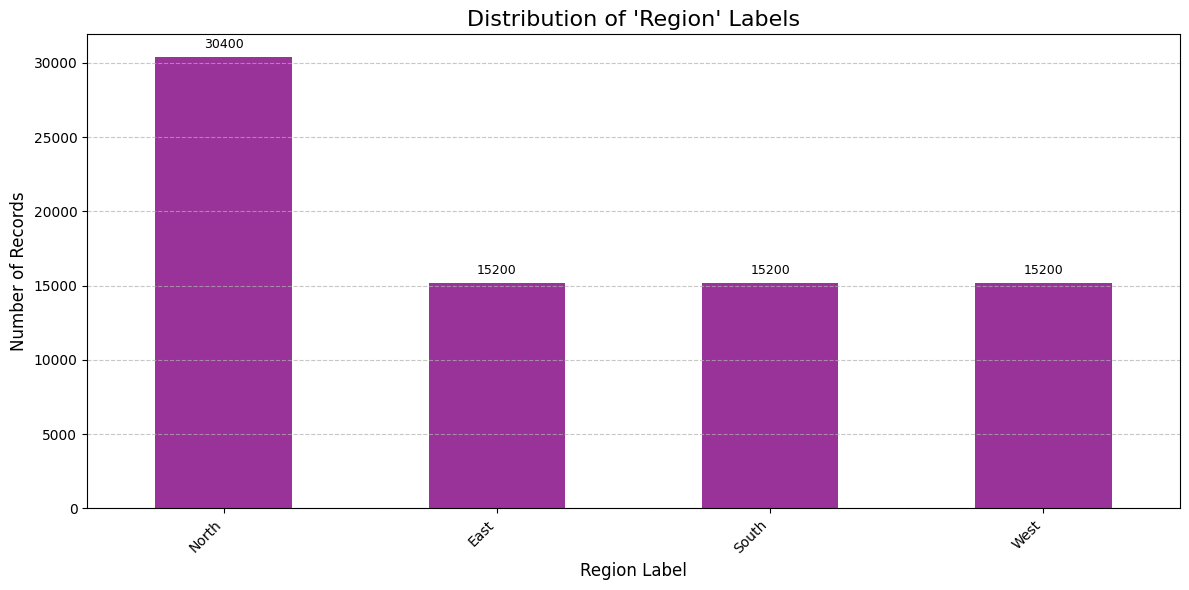

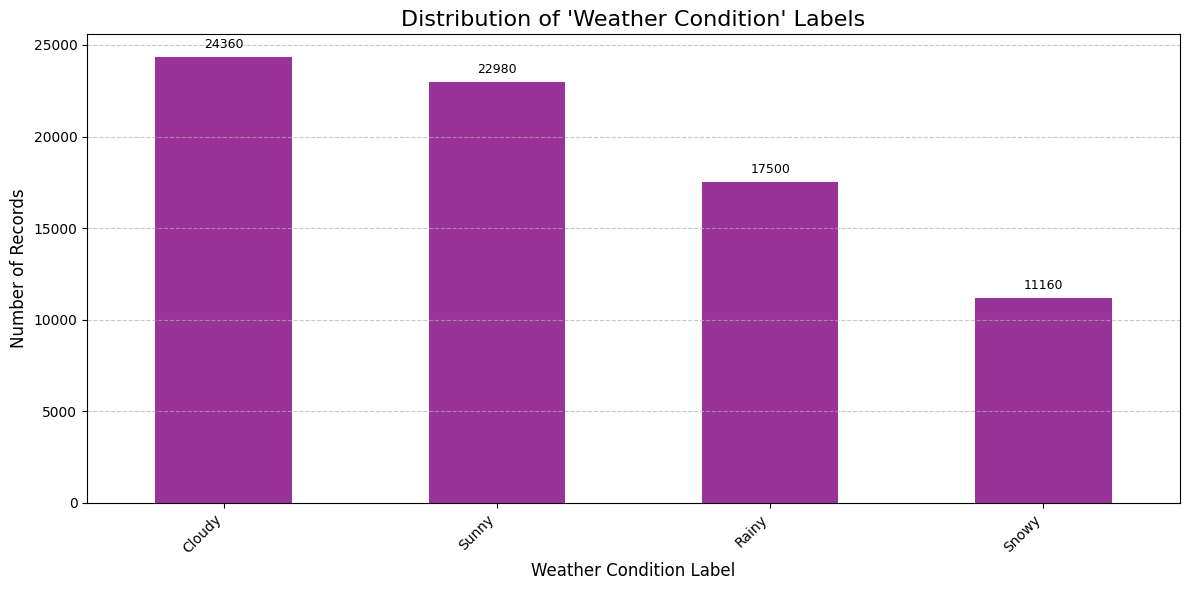

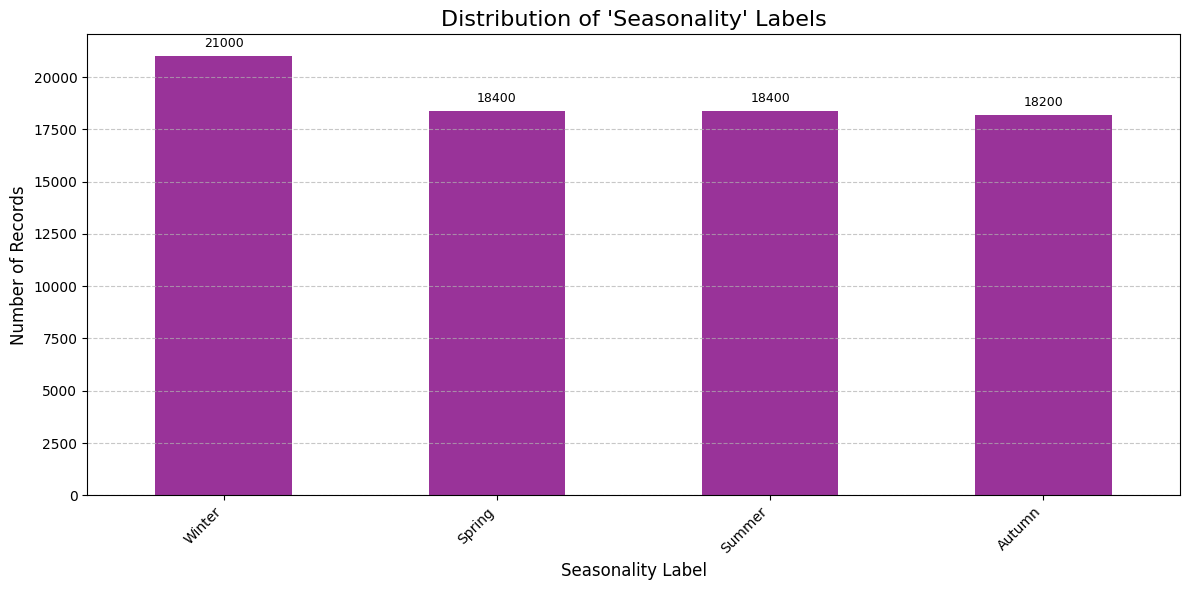

<Figure size 1400x700 with 0 Axes>

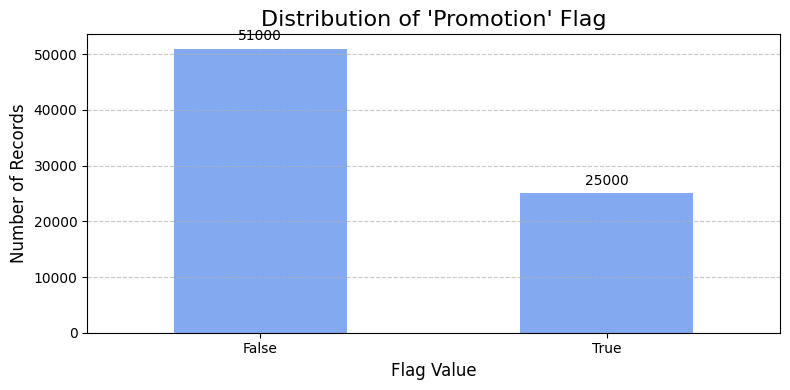

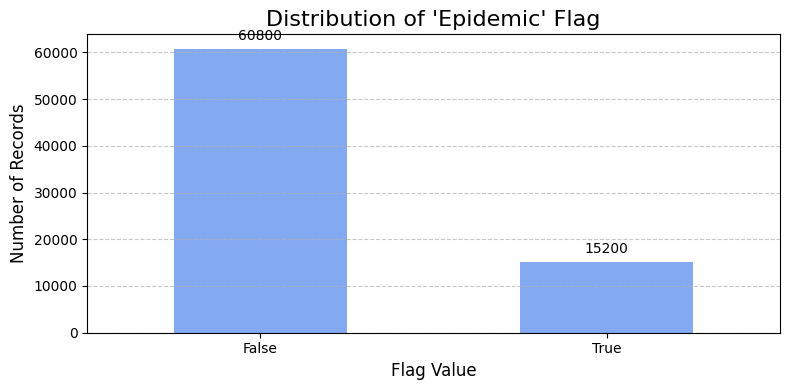


A. Data Quality Checks: Consolidated Report
Rows with any missing data: 0
No missing values found in any column.
Rows missing required columns: 0
No missing values found in required columns.
Data Types:
Date                  datetime64[ns]
Store ID                    category
Product ID                  category
Category                    category
Region                      category
Inventory Level               uint16
Units Sold                    uint16
Units Ordered                 uint16
Price                        float32
Discount                     float32
Weather Condition           category
Promotion                       bool
Competitor Pricing           float32
Seasonality                 category
Epidemic                        bool
Demand                        uint16
dtype: object
Duplicate records by composite key: 0
Rows with rare 'Category' labels (count < 5): 0
Rows with rare 'Region' labels (count < 5): 0
Rows with rare 'Weather Condition' labels (count < 5): 0
R

In [3]:
# ==========================================================================
# Step A: Foundational Data Quality Checks
# Purpose: To perform a comprehensive first-pass analysis of the dataset, identifying common quality issues
#          like missing values, incorrect data types, duplicates, invalid values, and inconsistent flags.
# Outputs: A consolidated report, visualizations for each check, and a dictionary of problematic row indices.
# Rationale: Establishing a baseline of data quality is critical before deeper analysis or modeling,
#            ensuring subsequent steps are built on a reliable foundation.
# ==========================================================================

import pandas as pd
import matplotlib.pyplot as plt

# ================================================================
# Reset index for checks: Make 'Date' a column for validation
# ================================================================
df_check = df.reset_index()

# Initialize dictionary to store problematic row indices
problem_rows = {
    'missing_any': set(),
    'missing_required': set(),
    'duplicate_composite': set(),
    'invalid_date': set(),
    'future_date': set(),
    'ancient_date': set(),
    'negative_inventory': set(),
    'negative_price': set(),
    'sales_exceeds_inventory': set(),
    'non_binary_promotion': set(),
    'non_binary_epidemic': set(),
    'rare_category': set(),
    'rare_region': set(),
    'rare_weather': set(),
    'rare_seasonality': set(),
}

# Initialize a string to collect all report text
report_text = ""

def log_report(message):
    """Helper function to accumulate report text."""
    global report_text
    report_text += message + "\n"

# -----------------------------------------------------------------
# 1. Null/NaN and Missing Data
# -----------------------------------------------------------------
try:
    missing_any = df_check[df_check.isna().any(axis=1)].index
    problem_rows['missing_any'].update(missing_any)
    log_report(f"Rows with any missing data: {len(missing_any)}")
    
    # --- Enhanced Plotting ---
    plt.figure(figsize=(12, 6))
    missing_counts = df_check.isna().sum()
    missing_counts = missing_counts[missing_counts > 0] # Only plot columns with missing values
    if not missing_counts.empty:
        ax = missing_counts.plot(kind='bar', color='salmon', alpha=0.8)
        
        # Add data labels
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

        plt.title("Count of Missing Values by Column (Before Cleaning)", fontsize=16)
        plt.ylabel("Number of Missing Rows", fontsize=12)
        plt.xlabel("Column Name", fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        log_report("No missing values found in any column.")

except Exception as e:
    log_report(f"Error checking for missing data: {e}")

# -----------------------------------------------------------------
# 2. Row Completeness
# -----------------------------------------------------------------
required_cols = ['Store ID', 'Product ID', 'Date', 'Units Sold']  # Adjust as needed
try:
    missing_required = df_check[df_check[required_cols].isna().any(axis=1)].index
    problem_rows['missing_required'].update(missing_required)
    log_report(f"Rows missing required columns: {len(missing_required)}")

    # --- Enhanced Plotting ---
    plt.figure(figsize=(10, 5))
    missing_required_counts = df_check[required_cols].isna().sum()
    missing_required_counts = missing_required_counts[missing_required_counts > 0]
    if not missing_required_counts.empty:
        ax = missing_required_counts.plot(kind='bar', color='skyblue', alpha=0.8)

        # Add data labels
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

        plt.title("Missing Values in Required Columns", fontsize=16)
        plt.ylabel("Number of Missing Rows", fontsize=12)
        plt.xlabel("Column Name", fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        log_report("No missing values found in required columns.")

except Exception as e:
    log_report(f"Error checking for missing required columns: {e}")

# -----------------------------------------------------------------
# 3. Data Type Verification
# -----------------------------------------------------------------
try:
    log_report("Data Types:\n" + str(df_check.dtypes))
    
    # --- Enhanced Plotting ---
    plt.figure(figsize=(10, 5))
    dtype_counts = df_check.dtypes.value_counts()
    if not dtype_counts.empty:
        ax = dtype_counts.plot(kind='bar', color='limegreen', alpha=0.8)

        # Add data labels
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

        plt.title("Distribution of Column Data Types After Import", fontsize=16)
        plt.ylabel("Number of Columns", fontsize=12)
        plt.xlabel("Data Type", fontsize=12)
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        log_report("Could not determine data types.")

except Exception as e:
    log_report(f"Error checking data types: {e}")

# -----------------------------------------------------------------
# 4. Unique Identifiers (Composite Key)
# -----------------------------------------------------------------
try:
    duplicate_composite = df_check[df_check.duplicated(subset=['Store ID', 'Product ID', 'Date'], keep=False)].index
    problem_rows['duplicate_composite'].update(duplicate_composite)
    log_report(f"Duplicate records by composite key: {len(duplicate_composite)}")
except Exception as e:
    log_report(f"Error checking for duplicate rows: {e}")

# -----------------------------------------------------------------
# 5. Category/Label Consistency
# -----------------------------------------------------------------
cat_cols = {
    'Category': 'rare_category',
    'Region': 'rare_region',
    'Weather Condition': 'rare_weather',
    'Seasonality': 'rare_seasonality',
}
threshold = 5  # Adjust as needed
try:
    for col, key in cat_cols.items():
        # Logic for finding rare labels remains the same
        value_counts = df_check[col].value_counts()
        rare_labels = value_counts[value_counts < threshold].index
        rare_rows = df_check[df_check[col].isin(rare_labels)].index
        problem_rows[key].update(rare_rows)
        log_report(f"Rows with rare '{col}' labels (count < {threshold}): {len(rare_rows)}")

        # --- Enhanced Plotting ---
        plt.figure(figsize=(12, 6))
        
        # For clarity, only plot top 20 most frequent labels
        plot_counts = value_counts.head(20)
        
        ax = plot_counts.plot(kind='bar', color='purple', alpha=0.8)

        # Add data labels
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=9)

        title_suffix = ""
        if len(value_counts) > 20:
            title_suffix = " (Top 20 Shown)"

        plt.title(f"Distribution of '{col}' Labels{title_suffix}", fontsize=16)
        plt.ylabel("Number of Records", fontsize=12)
        plt.xlabel(f"{col} Label", fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

except Exception as e:
    log_report(f"Error checking category/label consistency: {e}")

# -----------------------------------------------------------------
# 6. Date Validity
# -----------------------------------------------------------------
try:
    # Invalid dates (NaT after parsing)
    invalid_date = df_check[df_check['Date'].isna()].index
    problem_rows['invalid_date'].update(invalid_date)
    log_report(f"Rows with invalid dates: {len(invalid_date)}")
    
    # Future dates
    today = pd.Timestamp.today().normalize()
    future_date = df_check[df_check['Date'] > today].index
    problem_rows['future_date'].update(future_date)
    log_report(f"Rows with future dates: {len(future_date)}")
    
    # Ancient dates (adjust threshold as needed)
    ancient_date = df_check[df_check['Date'] < pd.Timestamp('2000-01-01')].index
    problem_rows['ancient_date'].update(ancient_date)
    log_report(f"Rows with ancient dates: {len(ancient_date)}")

    # --- Enhanced Plotting: Date Coverage Heatmap ---
    if 'Date' in df_check.columns and not df_check['Date'].isna().all():
        # Create a pivot table for the heatmap
        df_check['Year'] = df_check['Date'].dt.year
        df_check['Month'] = df_check['Date'].dt.month
        date_heatmap = df_check.pivot_table(index='Year', columns='Month', values='Store ID', aggfunc='count').fillna(0)

        plt.figure(figsize=(14, 7))
        sns.heatmap(date_heatmap, cmap='viridis', annot=True, fmt='.0f', linewidths=.5)
        
        plt.title("Monthly Transaction Heatmap", fontsize=16)
        plt.xlabel("Month", fontsize=12)
        plt.ylabel("Year", fontsize=12)
        plt.tight_layout()
        plt.show()

        # Clean up temporary columns
        df_check = df_check.drop(columns=['Year', 'Month'])
    else:
        log_report("Skipping date heatmap due to missing or invalid date column.")

except Exception as e:
    log_report(f"Error checking date validity: {e}")

# -----------------------------------------------------------------
# 7. Value Validation
# -----------------------------------------------------------------
try:
    negative_inventory = df_check[df_check['Inventory Level'] < 0].index
    problem_rows['negative_inventory'].update(negative_inventory)
    log_report(f"Rows with negative inventory: {len(negative_inventory)}")
    
    negative_price = df_check[df_check['Price'] < 0].index
    problem_rows['negative_price'].update(negative_price)
    log_report(f"Rows with negative price: {len(negative_price)}")
    
    sales_exceeds_inventory = df_check[df_check['Units Sold'] > df_check['Inventory Level']].index
    problem_rows['sales_exceeds_inventory'].update(sales_exceeds_inventory)
    log_report(f"Rows where sales exceed inventory: {len(sales_exceeds_inventory)}")

    # --- Enhanced Plotting ---
    value_issues = {
        'Negative Inventory': len(negative_inventory),
        'Negative Price': len(negative_price),
        'Sales > Inventory': len(sales_exceeds_inventory)
    }
    value_issues_series = pd.Series(value_issues)
    value_issues_series = value_issues_series[value_issues_series > 0]

    if not value_issues_series.empty:
        plt.figure(figsize=(10, 5))
        ax = value_issues_series.plot(kind='bar', color='orange', alpha=0.8)

        # Add data labels
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

        plt.title("Count of Rows Failing Initial Value Validation", fontsize=16)
        plt.ylabel("Number of Rows", fontsize=12)
        plt.xlabel("Validation Check", fontsize=12)
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        log_report("No value validation issues found.")

except Exception as e:
    log_report(f"Error checking value validation: {e}")

# -----------------------------------------------------------------
# 8. Flag Consistency
# -----------------------------------------------------------------
try:
    non_binary_promotion = df_check[~df_check['Promotion'].isin([True, False, 0, 1])].index
    problem_rows['non_binary_promotion'].update(non_binary_promotion)
    log_report(f"Rows with non-binary Promotion: {len(non_binary_promotion)}")
    
    non_binary_epidemic = df_check[~df_check['Epidemic'].isin([True, False, 0, 1])].index
    problem_rows['non_binary_epidemic'].update(non_binary_epidemic)
    log_report(f"Rows with non-binary Epidemic: {len(non_binary_epidemic)}")

    # --- Enhanced Plotting ---
    for flag in ['Promotion', 'Epidemic']:
        plt.figure(figsize=(8, 4))
        flag_counts = df_check[flag].value_counts()
        
        ax = flag_counts.plot(kind='bar', color='cornflowerblue', alpha=0.8)

        # Add data labels
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

        plt.title(f"Distribution of '{flag}' Flag", fontsize=16)
        plt.ylabel("Number of Records", fontsize=12)
        plt.xlabel("Flag Value", fontsize=12)
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

except Exception as e:
    log_report(f"Error checking flag consistency: {e}")

# -----------------------------------------------------------------
# 9. Final Consolidated Report
# -----------------------------------------------------------------
print("\n" + "="*80)
print("A. Data Quality Checks: Consolidated Report")
print("="*80)
print(report_text)
print("All problematic row indices have been stored in the 'problem_rows' dictionary.")

# ================================================================
# Restore index for time series operations (optional)
# ================================================================
df = df_check.set_index('Date').sort_index()

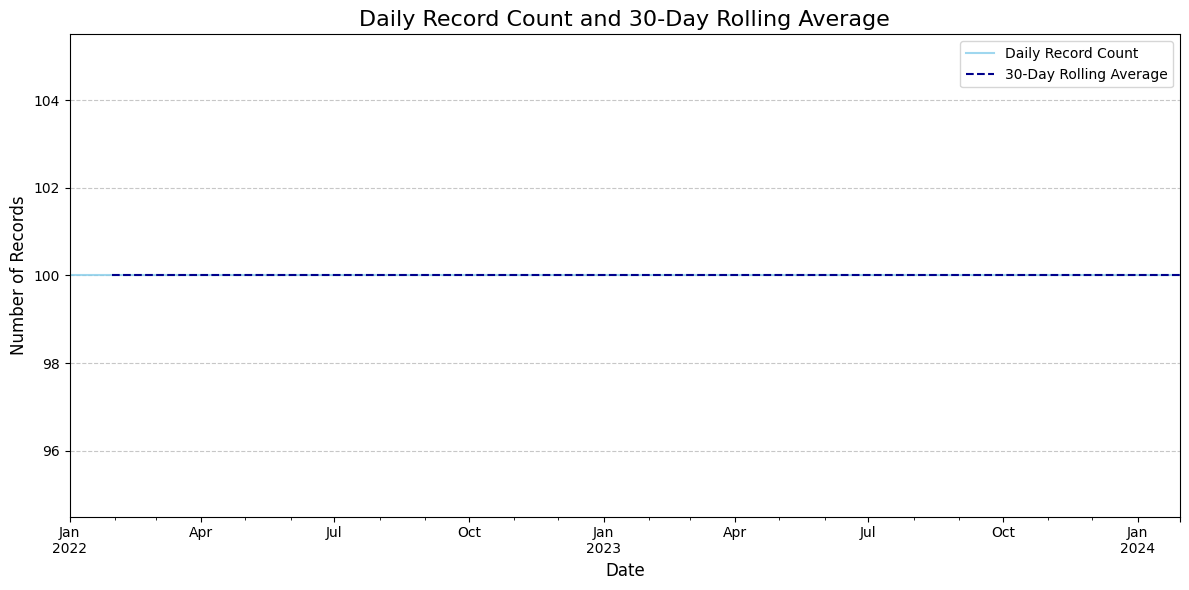

=== DATA VALIDATION AUDIT LOG ===

All required columns present.
No missing values found in required columns.
No duplicate rows found by composite key (Store/Product/Date).
No suspiciously high record counts by date found.

=== DATASET DIMENSIONS ===
Product Count: 20
Category Count: 5
Date Range: 2022-01-01 to 2024-01-30
Store Count: 5
Region Count: 4

=== ACTIONABLE INSIGHTS ===
No data quality issues found. No corrective actions required.
Error during visualization: name 'sns' is not defined


Data validation checks completed. Problematic rows are stored in the 'problematic_rows' dictionary.

No problematic rows found.


<Figure size 1200x600 with 0 Axes>

In [4]:
# ==========================================================================
# Step B.1: Granularity, Coverage, and Data Integrity Checks
# Purpose: To ensure the dataset is complete, consistent, and fit for forecasting by analyzing its
#          granularity, coverage, and identifying critical integrity issues like duplicates and value anomalies.
# Outputs: A printed audit log, a dictionary of problematic rows, and summary visualizations.
# Rationale: This transparent, progressive check supports actionable data cleaning by systematically
#            validating the core dimensions and integrity of the data before advanced analysis.
# ==========================================================================

import pandas as pd
import matplotlib.pyplot as plt

# Assume df is your DataFrame, with 'Date' as index and columns:
# 'Product ID', 'Category', 'Store ID', 'Region', 'Inventory Level', 'Units Sold', 'Price', 'Promotion', 'Epidemic'

# Initialize log as a list (to be printed at the end)
log = []
log.append("=== DATA VALIDATION AUDIT LOG ===\n\n")

# Store problematic rows as pandas Series or DataFrames
problematic_rows = {}

# ==========================================================================
# Define validation rules and metrics
# ==========================================================================
validation_rules = {
    'Inventory Level': {'min': 0, 'max': 10000},
    'Price': {'min': 0, 'max': 1000},
    'Units Sold': {'min': 0, 'max': 1000},
    'Promotion': {'allowed': [True, False, 1, 0]},
    'Epidemic': {'allowed': [True, False, 1, 0]}
}
required_cols = ['Product ID', 'Category', 'Store ID', 'Region', 'Inventory Level', 'Units Sold', 'Price', 'Promotion', 'Epidemic']

try:
    # ==========================================================================
    # Automated data quality checks
    # ==========================================================================
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        log.append(f"Missing required columns: {missing_cols}\n")
        problematic_rows['missing_columns'] = missing_cols
    else:
        log.append("All required columns present.\n")

    missing_values = df[required_cols].isna().sum()
    if missing_values.sum() > 0:
        log.append("Missing values detected:\n")
        log.append(missing_values.to_string() + "\n")
        problematic_rows['missing_values'] = missing_values
    else:
        log.append("No missing values found in required columns.\n")

    # ==========================================================================
    # Change index to column for duplicate check on composite key
    # This creates a temporary DataFrame with 'Date' as a column, not the index
    # ==========================================================================
    df_with_date = df.reset_index()
    composite_key = ['Store ID', 'Product ID', 'Date']
    duplicates = df_with_date[df_with_date.duplicated(subset=composite_key, keep=False)]
    if not duplicates.empty:
        log.append(f"Duplicate rows by composite key (Store/Product/Date): {len(duplicates)}\n")
        problematic_rows['duplicates'] = duplicates
    else:
        log.append("No duplicate rows found by composite key (Store/Product/Date).\n")

    # ==========================================================================
    # Check for possible duplicate rows by date only (if date is index)
    # This helps identify days with suspiciously high record counts
    # ==========================================================================
    date_duplicates = df.groupby(df.index).size()
    suspicious_dates = date_duplicates[date_duplicates > date_duplicates.median() + 2 * date_duplicates.std()]
    if not suspicious_dates.empty:
        log.append(f"\nPossible duplicate or suspiciously high record counts by date:\n")
        log.append(f"Found {len(suspicious_dates)} dates with unusually high record counts.\n")
        log.append("Top dates with high record counts:\n")
        log.append(suspicious_dates.sort_values(ascending=False).head().to_string() + "\n")
        problematic_rows['suspicious_dates'] = suspicious_dates
    else:
        log.append("No suspiciously high record counts by date found.\n")

    for field, rules in validation_rules.items():
        if field in df.columns:
            if 'min' in rules:
                below_min = df[df[field] < rules['min']]
                if not below_min.empty:
                    log.append(f"Rows with {field} below minimum ({rules['min']}): {len(below_min)}\n")
                    problematic_rows[f'{field}_below_min'] = below_min[field]
            if 'max' in rules:
                above_max = df[df[field] > rules['max']]
                if not above_max.empty:
                    log.append(f"Rows with {field} above maximum ({rules['max']}): {len(above_max)}\n")
                    problematic_rows[f'{field}_above_max'] = above_max[field]
            if 'allowed' in rules:
                invalid = df[~df[field].isin(rules['allowed'])]
                if not invalid.empty:
                    log.append(f"Rows with invalid {field}: {len(invalid)}\n")
                    problematic_rows[f'invalid_{field}'] = invalid[field]

    # ==========================================================================
    # Granularity and coverage analysis
    # ==========================================================================
    metrics = {
        "Product Count": df['Product ID'].nunique(),
        "Category Count": df['Category'].nunique(),
        "Date Range": (df.index.min(), df.index.max()),
        "Store Count": df['Store ID'].nunique(),
        "Region Count": df['Region'].nunique()
    }

    log.append("\n=== DATASET DIMENSIONS ===\n")
    for key, val in metrics.items():
        if isinstance(val, tuple):
            log.append(f"{key}: {val[0].date()} to {val[1].date()}\n")
        else:
            log.append(f"{key}: {val}\n")

    # ==========================================================================
    # Actionable insights and remediation (context-aware, only if issues found)
    # ==========================================================================
    log.append("\n=== ACTIONABLE INSIGHTS ===\n")
    any_issues = False

    if 'missing_columns' in problematic_rows:
        log.append("1. Review and correct missing required columns: see 'missing_columns'.\n")
        any_issues = True
    if 'missing_values' in problematic_rows:
        log.append("2. Review and correct missing values: see 'missing_values'.\n")
        any_issues = True
    if 'duplicates' in problematic_rows:
        log.append("3. Investigate and resolve duplicate records: see 'duplicates'.\n")
        any_issues = True
    if 'suspicious_dates' in problematic_rows:
        log.append("4. Investigate suspiciously high record counts by date: see 'suspicious_dates'.\n")
        any_issues = True

    # Field-specific checks
    for field in ['Inventory Level', 'Price', 'Units Sold', 'Promotion', 'Epidemic']:
        if f'{field}_below_min' in problematic_rows:
            log.append(f"5. Check and correct rows with {field} below minimum: see '{field}_below_min'.\n")
            any_issues = True
        if f'{field}_above_max' in problematic_rows:
            log.append(f"6. Check and correct rows with {field} above maximum: see '{field}_above_max'.\n")
            any_issues = True
        if f'invalid_{field}' in problematic_rows:
            log.append(f"7. Validate and standardize {field} values: see 'invalid_{field}'.\n")
            any_issues = True

    if not any_issues:
        log.append("No data quality issues found. No corrective actions required.\n")

    # ==========================================================================
    # Statistical and visual analysis (print plots to notebook)
    # ==========================================================================
    try:
        # --- Enhanced Daily Record Count Plot ---
        plt.figure(figsize=(12, 6))
        daily_counts = df.resample('D').size()
        
        # Plot daily counts
        daily_counts.plot(label='Daily Record Count', color='skyblue', alpha=0.8)
        
        # Plot 30-day rolling average
        daily_counts.rolling(window=30).mean().plot(label='30-Day Rolling Average', color='darkblue', linestyle='--')

        plt.title('Daily Record Count and 30-Day Rolling Average', fontsize=16)
        plt.ylabel('Number of Records', fontsize=12)
        plt.xlabel('Date', fontsize=12)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # --- Enhanced Units Sold Distribution Plot ---
        plt.figure(figsize=(12, 6))
        sns.histplot(df['Units Sold'], kde=True, bins=50, color='lightcoral', alpha=0.8)
        
        # Add mean and median lines
        mean_units_sold = df['Units Sold'].mean()
        median_units_sold = df['Units Sold'].median()
        plt.axvline(mean_units_sold, color='red', linestyle='--', label=f'Mean: {mean_units_sold:.2f}')
        plt.axvline(median_units_sold, color='green', linestyle='-', label=f'Median: {median_units_sold:.2f}')

        plt.title('Distribution of Units Sold (All Records)', fontsize=16)
        plt.xlabel('Units Sold', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        log.append(f"Error during visualization: {e}\n")

except Exception as e:
    log.append(f"Critical error during validation: {e}\n")

# ==========================================================================
# Print log to cell output
# ==========================================================================
print(''.join(log))
print("\nData validation checks completed. Problematic rows are stored in the 'problematic_rows' dictionary.")

# Optional: Print problematic rows for review
if problematic_rows:
    print("\n=== PROBLEMATIC ROWS ===\n")
    for key, rows in problematic_rows.items():
        print(f"{key}:")
        print(rows if isinstance(rows, (pd.Series, pd.DataFrame)) else rows)
        print()
else:
    print("\nNo problematic rows found.")

In [5]:
# ==========================================================================
# Step B.2: Advanced Temporal Integrity Checks
# Purpose: To perform deeper validation of the dataset's time-series structure by checking for
#          temporal continuity, identifying out-of-bounds timestamps, and flagging suspicious record volumes.
# Outputs: A printed summary report, a dictionary of problematic rows, and actionable insights for remediation.
# Rationale: High-standard temporal validation is essential for reliable time-series forecasting, as gaps
#            or anomalies can significantly skew model performance.
# ==========================================================================

from datetime import datetime

# Helper function to format date lists
def format_dates(dates):
    if hasattr(dates, 'empty') and dates.empty:
        return 'None'
    elif len(dates) == 0:
        return 'None'
    return ', '.join([d.strftime('%Y-%m-%d') for d in dates])

# 1. Date Sequence Completeness
expected_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missing_dates = expected_dates.difference(df.index)
missing_dates_list = list(missing_dates)

# 2. Logical Timestamp Ranges
today = datetime.now().date()
future_dates = df.index[df.index > pd.Timestamp(today)]
ancient_threshold = pd.Timestamp('2000-01-01')  # Adjust as needed
ancient_dates = df.index[df.index < ancient_threshold]

# 3. Suspiciously High or Low Record Counts by Date
date_counts = df.groupby(df.index).size()
suspicious_dates = date_counts[
    (date_counts > date_counts.median() + 2 * date_counts.std()) |
    (date_counts < date_counts.median() - 2 * date_counts.std())
]

# 4. Dataset Dimension Recap (for reporting)
dimension_metrics = {
    "Product Count": df['Product ID'].nunique(),
    "Category Count": df['Category'].nunique(),
    "Date Range": (df.index.min().date(), df.index.max().date()),
    "Store Count": df['Store ID'].nunique(),
    "Region Count": df['Region'].nunique()
}

# 5. Print Summary Report
print("""
=== STEP B.2: ADVANCED DATASET DIMENSION & TEMPORAL INTEGRITY CHECKS ===

--- Dataset Dimensions ---
Product Count:   {Product Count}
Category Count:  {Category Count}
Date Range:      {Date Range[0]} to {Date Range[1]}
Store Count:     {Store Count}
Region Count:    {Region Count}

--- Temporal Integrity ---
Missing dates in sequence: {missing_dates}
  Details: {missing_dates_details}
Future dates detected: {future_dates}
  Details: {future_dates_details}
Ancient dates detected: {ancient_dates}
  Details: {ancient_dates_details}
Dates with suspicious record counts: {suspicious_dates}
  Details: {suspicious_dates_details}
""".format(
    **dimension_metrics,
    missing_dates=len(missing_dates_list),
    missing_dates_details=format_dates(missing_dates_list),
    future_dates=len(future_dates),
    future_dates_details=format_dates(future_dates),
    ancient_dates=len(ancient_dates),
    ancient_dates_details=format_dates(ancient_dates),
    suspicious_dates=len(suspicious_dates),
    suspicious_dates_details=suspicious_dates.sort_values(ascending=False).head().to_string() if not suspicious_dates.empty else 'None'
))

# 6. Store problematic results for downstream review
problematic_rows['b2_missing_dates'] = pd.Series(missing_dates_list)
problematic_rows['b2_future_dates'] = pd.Series(future_dates)
problematic_rows['b2_ancient_dates'] = pd.Series(ancient_dates)
problematic_rows['b2_suspicious_dates'] = suspicious_dates

# 7. Actionable Insights
if len(missing_dates_list) > 0 or len(future_dates) > 0 or len(ancient_dates) > 0 or len(suspicious_dates) > 0:
    print("\n=== ACTIONABLE INSIGHTS (B.2) ===\n")
    if len(missing_dates_list) > 0:
        print("• Fill or impute missing dates for time series continuity (see 'b2_missing_dates').")
        print(problematic_rows['b2_missing_dates'].head())
    if len(future_dates) > 0 or len(ancient_dates) > 0:
        print("• Correct or flag future/ancient dates (see 'b2_future_dates', 'b2_ancient_dates').")
        print("Future:", problematic_rows['b2_future_dates'].head())
        print("Ancient:", problematic_rows['b2_ancient_dates'].head())
    if len(suspicious_dates) > 0:
        print("• Investigate dates with suspicious record counts (see 'b2_suspicious_dates').")
        print(problematic_rows['b2_suspicious_dates'].head())
else:
    print("\nNo advanced temporal integrity issues found in dataset dimensions.")


=== STEP B.2: ADVANCED DATASET DIMENSION & TEMPORAL INTEGRITY CHECKS ===

--- Dataset Dimensions ---
Product Count:   20
Category Count:  5
Date Range:      2022-01-01 to 2024-01-30
Store Count:     5
Region Count:    4

--- Temporal Integrity ---
Missing dates in sequence: 0
  Details: None
Future dates detected: 0
  Details: None
Ancient dates detected: 0
  Details: None
Dates with suspicious record counts: 0
  Details: None


No advanced temporal integrity issues found in dataset dimensions.


In [6]:
# ==========================================================================
# Step B.3: Raw Data Import Sanity Check
# Purpose: To import the dataset in its original, unaltered state to validate the effectiveness
#          and necessity of the automated cleaning steps.
# Outputs: A separate "raw" DataFrame and a printed report comparing its quality issues against the cleaned version.
# Rationale: This check provides a definitive baseline of the source data's quality and confirms that
#            the cleaning process is correctly identifying and resolving issues.
# ==========================================================================

import pandas as pd
import numpy as np
from pathlib import Path
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Data configuration
DATA_PATH = Path('/kaggle/input/retail-store-inventory-and-demand-forecasting/sales_data.csv')
DATE_COL = 'Date'
DTYPES = {
    'Store ID': 'category',
    'Product ID': 'category',
    'Category': 'category',
    'Region': 'category',
    'Inventory Level': 'uint16',
    'Units Sold': 'uint16',
    'Units Ordered': 'uint16',
    'Price': 'float32',
    'Discount': 'float32',
    'Weather Condition': 'category',
    'Promotion': 'bool',
    'Competitor Pricing': 'float32',
    'Seasonality': 'category',
    'Epidemic': 'bool',
    'Demand': 'uint16'
}

def import_raw_data():
    """Import data WITHOUT any corrections to assess original data quality."""
    try:
        logger.info("Importing raw data without corrections...")
        print("Importing RAW data (no corrections applied)...")
        raw_df = pd.read_csv(
            DATA_PATH,
            dtype=DTYPES,
            parse_dates=[DATE_COL],
            on_bad_lines='warn',
            encoding='utf-8'
        )
        raw_df = raw_df.set_index(DATE_COL).sort_index()
        logger.info(f"Raw data imported: {len(raw_df):,} rows")
        print(f"Raw data imported: {len(raw_df):,} rows")
        return raw_df
    except FileNotFoundError:
        logger.error(f"Data file not found: {DATA_PATH}")
        print(f"ERROR: Data file not found: {DATA_PATH}")
    except pd.errors.DtypeWarning as e:
        logger.warning(f"Data type conversion warning: {e}")
        print(f"WARNING: Data type conversion warning: {e}")
    except Exception as e:
        logger.error(f"Unexpected error importing raw data: {e}")
        print(f"ERROR: Unexpected error importing raw data: {e}")
    return None

def check_raw_data_quality(raw_df):
    """Perform data quality checks on the raw data."""
    print("\n" + "="*60)
    print("RAW DATA QUALITY ISSUES (Before Corrections)")
    print("="*60)
    issues_found = []

    # 1. Negative inventory
    try:
        negative_inv = (raw_df['Inventory Level'] < 0).sum()
        if negative_inv > 0:
            issues_found.append(f"Negative Inventory: {negative_inv:,} rows")
            print(f"ISSUE: Negative Inventory: {negative_inv:,} rows")
            logger.warning(f"Negative Inventory: {negative_inv:,} rows")
        else:
            print("CLEAN: Negative Inventory: 0 rows")
    except Exception as e:
        logger.error(f"Error checking negative inventory: {e}")
        print(f"ERROR: Could not check negative inventory: {e}")

    # 2. Sales exceeding inventory
    try:
        sales_exceed = (raw_df['Units Sold'] > raw_df['Inventory Level']).sum()
        if sales_exceed > 0:
            issues_found.append(f"Sales > Inventory: {sales_exceed:,} rows")
            print(f"ISSUE: Sales > Inventory: {sales_exceed:,} rows")
            logger.warning(f"Sales > Inventory: {sales_exceed:,} rows")
        else:
            print("CLEAN: Sales > Inventory: 0 rows")
    except Exception as e:
        logger.error(f"Error checking sales vs inventory: {e}")
        print(f"ERROR: Could not check sales vs inventory: {e}")

    # 3. Negative prices
    try:
        negative_price = (raw_df['Price'] < 0).sum()
        if negative_price > 0:
            issues_found.append(f"Negative Prices: {negative_price:,} rows")
            print(f"ISSUE: Negative Prices: {negative_price:,} rows")
            logger.warning(f"Negative Prices: {negative_price:,} rows")
        else:
            print("CLEAN: Negative Prices: 0 rows")
    except Exception as e:
        logger.error(f"Error checking negative prices: {e}")
        print(f"ERROR: Could not check negative prices: {e}")

    # 4. Missing values
    try:
        missing_total = raw_df.isnull().sum().sum()
        if missing_total > 0:
            issues_found.append(f"Missing Values: {missing_total:,} total")
            print(f"ISSUE: Missing Values: {missing_total:,} total")
            logger.warning(f"Missing Values: {missing_total:,} total")
        else:
            print("CLEAN: Missing Values: 0 total")
    except Exception as e:
        logger.error(f"Error checking missing values: {e}")
        print(f"ERROR: Could not check missing values: {e}")

    # 5. Invalid dates (index nulls)
    try:
        date_issues = raw_df.index.isnull().sum()
        if date_issues > 0:
            issues_found.append(f"Invalid Dates: {date_issues:,} rows")
            print(f"ISSUE: Invalid Dates: {date_issues:,} rows")
            logger.warning(f"Invalid Dates: {date_issues:,} rows")
        else:
            print("CLEAN: Invalid Dates: 0 rows")
    except Exception as e:
        logger.error(f"Error checking date validity: {e}")
        print(f"ERROR: Could not check date validity: {e}")

    # 6. Check for lists/arrays in Category or other columns
    # (You can add more columns to this list if needed)
    cat_cols = ['Category', 'Region', 'Store ID', 'Product ID', 'Weather Condition', 'Seasonality']
    for col in cat_cols:
        try:
            is_list = raw_df[col].apply(lambda x: isinstance(x, (list, tuple, np.ndarray)))
            if is_list.any():
                issues_found.append(f"Lists/arrays in {col}: {is_list.sum():,} rows")
                print(f"ISSUE: Lists/arrays in {col}: {is_list.sum():,} rows")
                logger.warning(f"Lists/arrays in {col}: {is_list.sum():,} rows")
                print("Sample of problematic rows:")
                display(raw_df[is_list].head())
            else:
                print(f"CLEAN: Lists/arrays in {col}: 0 rows")
        except Exception as e:
            logger.error(f"Error checking lists/arrays in {col}: {e}")
            print(f"ERROR: Could not check lists/arrays in {col}: {e}")

    return issues_found

def report_sanity_check_results(issues_found, raw_df, df):
    print("\n" + "="*60)
    print("SANITY CHECK RESULTS")
    print("="*60)
    if issues_found:
        print("VALIDATION: Raw data contains the following quality issues:")
        for issue in issues_found:
            print(f"  - {issue}")
        print("\nThese issues were addressed by the automatic correction process.")
        logger.info(f"Data quality issues detected: {issues_found}")
    else:
        print("RESULT: No data quality issues detected in the raw data based on current checks.")
        print("Interpretation:")
        print("  - The dataset may be synthetic or pre-cleaned for the challenge.")
        print("  - Data type coercion or import settings are unlikely to mask issues, but can be reviewed if needed.")
        print("  - If real-world data is expected, further investigation is recommended.")
        logger.info("No data quality issues found in raw data.")

    print("\nComparison with corrected data:")
    print(f"Raw data rows: {len(raw_df):,}")
    print(f"Corrected data rows: {len(df):,}")
    print(f"Row difference: {len(df) - len(raw_df):,}")

    # Show sample of raw data
    print("\nRaw data sample:")
    display(raw_df.head())

    # Key statistics comparison
    print("\nKey statistics comparison (Raw vs Corrected):")
    comparison_cols = ['Inventory Level', 'Units Sold', 'Price']
    for col in comparison_cols:
        try:
            print(f"\n{col}:")
            print(f"  Raw       - Min: {raw_df[col].min():.2f}, Max: {raw_df[col].max():.2f}")
            print(f"  Corrected - Min: {df[col].min():.2f}, Max: {df[col].max():.2f}")
        except Exception as e:
            logger.error(f"Error comparing statistics for {col}: {e}")
            print(f"ERROR: Could not compare statistics for {col}: {e}")

# Main execution
raw_df = import_raw_data()
if raw_df is not None:
    issues_found = check_raw_data_quality(raw_df)
    # 'df' should be your corrected/processed DataFrame, assumed to be loaded elsewhere
    try:
        report_sanity_check_results(issues_found, raw_df, df)
    except Exception as e:
        logger.error(f"Error during reporting: {e}")
        print(f"ERROR: Could not complete reporting: {e}")
else:
    logger.error("Failed to import raw data for comparison")
    print("FAILED: Could not import raw data for comparison")

Importing RAW data (no corrections applied)...
Raw data imported: 76,000 rows

RAW DATA QUALITY ISSUES (Before Corrections)
CLEAN: Negative Inventory: 0 rows
CLEAN: Sales > Inventory: 0 rows
CLEAN: Negative Prices: 0 rows
CLEAN: Missing Values: 0 total
CLEAN: Invalid Dates: 0 rows
CLEAN: Lists/arrays in Category: 0 rows
CLEAN: Lists/arrays in Region: 0 rows
CLEAN: Lists/arrays in Store ID: 0 rows
CLEAN: Lists/arrays in Product ID: 0 rows
CLEAN: Lists/arrays in Weather Condition: 0 rows
CLEAN: Lists/arrays in Seasonality: 0 rows

SANITY CHECK RESULTS
RESULT: No data quality issues detected in the raw data based on current checks.
Interpretation:
  - The dataset may be synthetic or pre-cleaned for the challenge.
  - Data type coercion or import settings are unlikely to mask issues, but can be reviewed if needed.
  - If real-world data is expected, further investigation is recommended.

Comparison with corrected data:
Raw data rows: 76,000
Corrected data rows: 76,000
Row difference: 0

Ra

Store ID Product ID     Category Region  Inventory Level  \
Date                                                                  
2022-01-01     S001      P0001  Electronics  North              195   
2022-01-01     S001      P0002     Clothing  North              117   
2022-01-01     S001      P0003     Clothing  North              247   
2022-01-01     S001      P0004  Electronics  North              139   
2022-01-01     S001      P0005    Groceries  North              152   

            Units Sold  Units Ordered      Price  Discount Weather Condition  \
Date                                                                           
2022-01-01         102            252  72.720001       5.0             Snowy   
2022-01-01         117            249  80.160004      15.0             Snowy   
2022-01-01         114            612  62.939999      10.0             Snowy   
2022-01-01          45            102  87.629997      10.0             Snowy   
2022-01-01          65            271  54.410000       0.0             Snowy   

            Promotion  Competitor Pricing Seasonality  Epidemic  Demand  
Date                                                                     
2022-01-01      False           85.730003      Winter     False     115  
2022-01-01       True           92.019997      Winter     False     229  
2022-01-01       True           60.080002      Winter     False     157  
2022-01-01      False           85.190002      Winter     False      52  
2022-01-01      False           51.630001      Winter     False      59


Key statistics comparison (Raw vs Corrected):

Inventory Level:
  Raw       - Min: 0.00, Max: 2267.00
  Corrected - Min: 0.00, Max: 2267.00

Units Sold:
  Raw       - Min: 0.00, Max: 426.00
  Corrected - Min: 0.00, Max: 426.00

Price:
  Raw       - Min: 4.74, Max: 228.03
  Corrected - Min: 4.74, Max: 228.03


## Advanced Data Consistency & Plausibility Checks

**Purpose**

While the raw data passes all standard quality checks (negatives, missing values, logical errors, etc.), subtle issues may still exist, especially in synthetic datasets. To ensure robust modeling and reliable insights, we perform additional advanced checks. The previous approach focused on price and category consistency across regions. Given the observed wild price variation and to deepen our understanding, we now also examine:

- **Pricing consistency within each region by store and item**
- **Category consistency within each region by item**
- **Price and category consistency across all regions**

These checks help uncover hidden artifacts, mislabeling, or implausible economic patterns that could impact model performance and interpretation.

---

**Stages of Advanced Checks**

**Stage 1: Pricing Consistency Within Each Region by Store and Item**  
*Check if the same product shows plausible price variation within each region across different stores. Detect unrealistic uniformity or outliers, and compare pricing patterns with competitors within the region. This exposes extreme values, pricing errors, and ensures that price deviations are justifiable (e.g., due to promotions or local market conditions).*

**Stage 2: Category Consistency Within Each Region**  
*Ensure each product is consistently assigned to the same category in all records within each region. Flag any mislabeled products or inconsistent categorization within a region.*

**Stage 3: Price vs. Competitor Pricing Analysis Within Regions**  
*Analyze the relationship between store prices and competitor pricing within each region. Identify implausible gaps, artificial patterns, or deviations from expected pricing strategies.*

**Stage 4: Item Category Mapping Consistency Across All Regions**  
*Ensure each product is mapped to the same category across all regions. Flag any products with inconsistent category assignments, which could indicate mislabeling or data entry errors.*

---

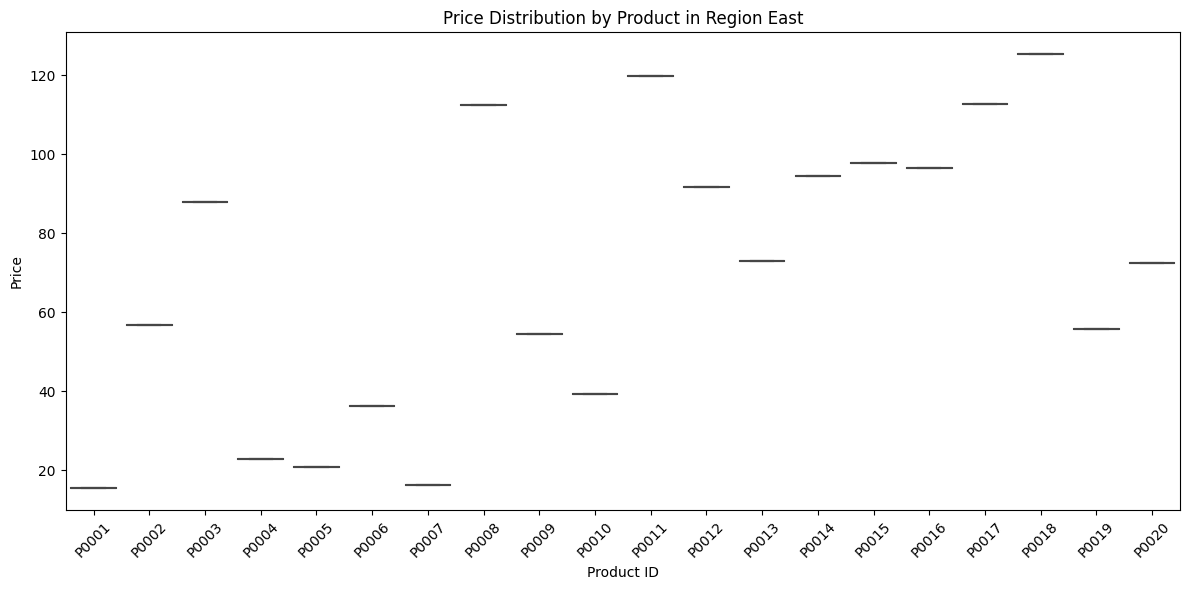

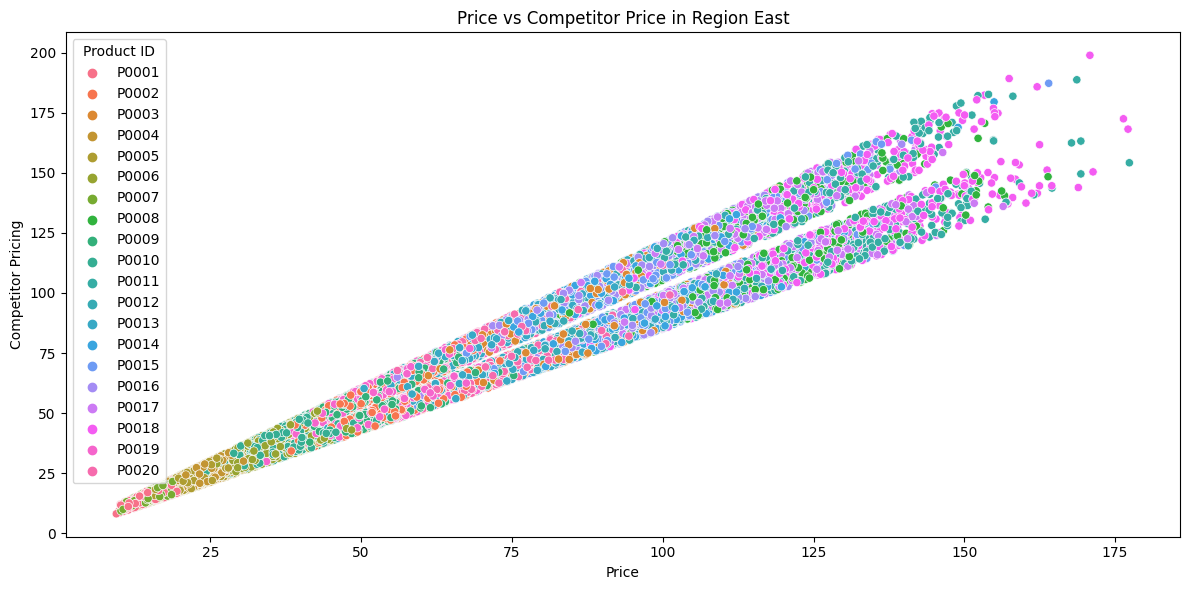

=== INTRA-REGIONAL PRICE CONSISTENCY AUDIT LOG ===

All required columns present.
Grouping data by region, product, and store...

=== STATISTICAL SUMMARY ===
                   count        mean        std         min         max
Region Product ID                                                      
East   P0001           1   15.460724        NaN   15.460724   15.460724
       P0002           1   56.703907        NaN   56.703907   56.703907
       P0003           1   87.905869        NaN   87.905869   87.905869
       P0004           1   22.980907        NaN   22.980907   22.980907
       P0005           1   20.871237        NaN   20.871237   20.871237
       P0006           1   36.293369        NaN   36.293369   36.293369
       P0007           1   16.359079        NaN   16.359079   16.359079
       P0008           1  112.518799        NaN  112.518799  112.518799
       P0009           1   54.442947        NaN   54.442947   54.442947
       P0010           1   39.202316        NaN   

In [7]:
# ==========================================================================
# Step C.1: Intra-Regional Price Consistency Check
# Purpose: To ensure that price variation for each product across different stores within the same region is plausible.
# Outputs: An audit log, a dictionary of problematic row indices, and visualizations of price distributions.
# Rationale: This check helps detect data artifacts, pricing errors, or unrealistic uniformity by verifying that
#            price deviations are statistically justifiable (e.g., due to promotions or local market conditions).
# ==========================================================================

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Configure logging for traceability
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# ==========================================================================
# Helper: IQR-based outlier detection
# ==========================================================================
def iqr_outliers(data, k=1.5):
    """Detect outliers using the IQR method. Returns a boolean mask of outliers."""
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    return (data < lower_bound) | (data > upper_bound)

# ==========================================================================
# Main check: Intra-regional price consistency
# ==========================================================================
def check_pricing_within_region(
    df,
    region_col='Region',
    store_col='Store ID',
    product_col='Product ID',
    price_col='Price',
    competitor_col='Competitor Pricing'
):
    """
    Check for plausible price variation within each region by store and item.
    Detects unrealistic uniformity, outliers, and compares with competitor prices.
    Logs errors, stores problematic row indices, and provides statistics and visualizations.
    Returns pd.Index of problematic rows.
    """
    log = []
    log.append("=== INTRA-REGIONAL PRICE CONSISTENCY AUDIT LOG ===\n\n")
    problematic_row_indices = pd.Index([])

    try:
        # ==========================================================================
        # Check for required columns
        # ==========================================================================
        required_cols = [region_col, store_col, product_col, price_col]
        if competitor_col in df.columns:
            required_cols.append(competitor_col)
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            log.append(f"Missing required columns: {missing_cols}\n")
            logger.error(f"Missing required columns: {missing_cols}")
            raise ValueError(f"Missing required columns: {missing_cols}")
        log.append("All required columns present.\n")

        # ==========================================================================
        # Group data by region, product, and store for price analysis
        # ==========================================================================
        log.append("Grouping data by region, product, and store...\n")
        grouped = df.groupby([region_col, product_col, store_col], observed=True)[price_col].mean().reset_index()

        # ==========================================================================
        # Analyze price variation and log issues
        # ==========================================================================
        uniformity_issues = []
        outlier_issues = []
        for (region, product), group in grouped.groupby([region_col, product_col], observed=True):
            prices = group[price_col]
            n_stores = len(prices)
            if n_stores > 1:
                # Outlier detection
                outliers = iqr_outliers(prices.values)
                if outliers.any():
                    outlier_stores = group[store_col][outliers].tolist()
                    outlier_prices = prices[outliers].tolist()
                    outlier_issues.append((region, product, outlier_stores, outlier_prices))
                    for store in outlier_stores:
                        mask = (df[region_col] == region) & (df[product_col] == product) & (df[store_col] == store)
                        problematic_row_indices = problematic_row_indices.union(df[mask].index)
                # Uniformity detection
                if prices.nunique() == 1:
                    uniformity_issues.append((region, product, prices.iloc[0]))

        # ==========================================================================
        # Statistical summary
        # ==========================================================================
        log.append("\n=== STATISTICAL SUMMARY ===\n")
        stats = grouped.groupby([region_col, product_col], observed=True)[price_col].agg(['count', 'mean', 'std', 'min', 'max'])
        log.append(stats.to_string() + "\n")

        # ==========================================================================
        # Uniformity and outlier issues summary
        # ==========================================================================
        log.append("\n=== UNIFORMITY ISSUES ===\n")
        if uniformity_issues:
            uniform_df = pd.DataFrame(uniformity_issues, columns=['Region', 'Product', 'Price'])
            log.append(f"Products with identical prices in all stores within a region: {len(uniformity_issues)}\n")
            log.append(uniform_df.groupby('Region').size().rename('Uniform Products Count').to_string() + "\n")
            log.append("Sample:\n" + uniform_df.head(10).to_string() + "\n")
        else:
            log.append("No products with identical prices in all stores within a region.\n")

        log.append("\n=== OUTLIER ISSUES ===\n")
        if outlier_issues:
            log.append(f"Products with outlier prices in some stores within a region: {len(outlier_issues)}\n")
            for i, (region, product, stores, prices) in enumerate(outlier_issues[:10]):
                log.append(f"Region {region}, Product {product}, Stores {stores}, Prices {prices}\n")
        else:
            log.append("No products with outlier prices in some stores within a region.\n")

        # ==========================================================================
        # Problematic row indices summary
        # ==========================================================================
        log.append("\n=== PROBLEMATIC ROWS ===\n")
        if len(problematic_row_indices) > 0:
            log.append(f"Total problematic rows: {len(problematic_row_indices)}\n")
            log.append(f"Problematic rows index (Date):\n{problematic_row_indices}\n")
        else:
            log.append("No problematic rows detected.\n")

        # ==========================================================================
        # Visual analysis with seaborn
        # ==========================================================================
        try:
            if len(grouped) > 0:
                # Boxplot: Price distribution by product in a sample region
                sample_region = grouped[region_col].iloc[0]
                sample_df = grouped[grouped[region_col] == sample_region]
                plt.figure(figsize=(12, 6))
                sns.boxplot(data=sample_df, x=product_col, y=price_col)
                plt.title(f'Price Distribution by Product in Region {sample_region}')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

                # Scatterplot: Price vs Competitor Price (if available)
                if competitor_col in df.columns:
                    sample_df = df[df[region_col] == sample_region]
                    plt.figure(figsize=(12, 6))
                    sns.scatterplot(data=sample_df, x=price_col, y=competitor_col, hue=product_col)
                    plt.title(f'Price vs Competitor Price in Region {sample_region}')
                    plt.tight_layout()
                    plt.show()
        except Exception as e:
            log.append(f"Error during visualization: {e}\n")

    except Exception as e:
        log.append(f"Critical error during intra-regional price consistency check: {e}\n")
        logger.error(f"Critical error during intra-regional price consistency check: {e}")

    # ==========================================================================
    # Print audit log to cell output
    # ==========================================================================
    print(''.join(log))
    print("\nIntra-regional price consistency checks completed. Problematic row indices are stored in 'problematic_row_indices'.")

    return problematic_row_indices

# ==========================================================================
# Run the check and store problematic row indices for review
# ==========================================================================
problematic_row_indices = check_pricing_within_region(
    df,
    region_col='Region',
    store_col='Store ID',
    product_col='Product ID',
    price_col='Price',
    competitor_col='Competitor Pricing'
)

# ==========================================================================
# Optional: Print problematic rows for review
# ==========================================================================
if len(problematic_row_indices) > 0:
    print("\n=== PROBLEMATIC ROWS ===\n")
    print(df.loc[problematic_row_indices])
else:
    print("\nNo problematic rows found.")

In [8]:
# ==========================================================================
# Step C.2: Intra-Regional Category Consistency Check
# Purpose: To ensure each product is consistently assigned to the same category in all records within a given region.
# Outputs: An audit log and a dictionary of row indices for any products with inconsistent category assignments.
# Rationale: This check prevents ambiguity and misrepresentation of products at the regional level, ensuring that
#            regional analysis and modeling are based on accurate category data.
# ==========================================================================

def check_category_consistency(df, region_col='Region', product_col='Product ID', category_col='Category'):
    """
    Check for consistent category assignment within each region and product.
    Log inconsistencies and return problematic row indices.
    """
    log = []
    inconsistent_indices = pd.Index([])
    log.append("=== CATEGORY CONSISTENCY WITHIN REGION AUDIT LOG ===\n\n")

    try:
        # Group by region and product, count unique categories
        group = df.groupby([region_col, product_col])[category_col].nunique().reset_index()
        inconsistent = group[group[category_col] > 1]
        
        if len(inconsistent) > 0:
            log.append(f"Found {len(inconsistent)} product-region pairs with inconsistent category assignment.\n")
            log.append("Sample of inconsistent pairs:\n")
            log.append(inconsistent.head(10).to_string() + "\n")
            
            # Store indices of problematic rows
            for _, row in inconsistent.iterrows():
                mask = (df[region_col] == row[region_col]) & (df[product_col] == row[product_col])
                inconsistent_indices = inconsistent_indices.union(df[mask].index)
        else:
            log.append("No inconsistent category assignments found within any region.\n")
    except Exception as e:
        log.append(f"Error during category consistency check: {e}\n")
    
    print(''.join(log))
    return inconsistent_indices

# Run the check
inconsistent_category_indices = check_category_consistency(
    df,
    region_col='Region',
    product_col='Product ID',
    category_col='Category'
)

# Optional: Print problematic rows for review
if len(inconsistent_category_indices) > 0:
    print("\n=== PROBLEMATIC ROWS ===\n")
    print(df.loc[inconsistent_category_indices])
else:
    print("\nNo problematic rows found.")

=== CATEGORY CONSISTENCY WITHIN REGION AUDIT LOG ===

Found 16 product-region pairs with inconsistent category assignment.
Sample of inconsistent pairs:
   Region Product ID  Category
20  North      P0001         2
21  North      P0002         2
22  North      P0003         2
23  North      P0004         2
25  North      P0006         2
27  North      P0008         2
28  North      P0009         2
29  North      P0010         2
30  North      P0011         2
31  North      P0012         2


=== PROBLEMATIC ROWS ===

           Store ID Product ID     Category Region  Inventory Level  \
2022-01-01     S001      P0001  Electronics  North              195   
2022-01-01     S001      P0002     Clothing  North              117   
2022-01-01     S001      P0003     Clothing  North              247   
2022-01-01     S001      P0004  Electronics  North              139   
2022-01-01     S001      P0005    Groceries  North              152   
...             ...        ...          ...    ...  

## Next Steps: Correcting Category Mislabeling

## **Findings Summary**

- **Inconsistent Category Assignments:**  
  - 16 product-region pairs were identified with inconsistent category assignments.
  - Example: Multiple categories (e.g., "Electronics" and "Clothing") assigned to the same product within a region.
- **Problematic Rows:**  
  - Specific rows with inconsistent labels have been flagged and can be reviewed or corrected as needed.

## **Action Plan**

1. **Majority Vote Correction:**  
   - For each product-region pair, determine the most frequently assigned category (the mode).
   - Update all records for that product-region pair to use the majority category.



2. **Manual Review for Edge Cases:**  
   - For cases where the majority is unclear or validation is inconclusive, flag for manual review.

3. **Update the Dataset:**  
   - Replace inconsistent category labels with the corrected value.
   - Ensure all changes are documented for traceability.

4. **Re-run Consistency Checks:**  
   - Rerun the category consistency check to confirm that all issues have been resolved.
   - Repeat the process if any inconsistencies remain.

In [9]:
# ==========================================================================
# Step C.2.1: Correct Intra-Regional Category Assignments
# Purpose: To automatically correct inconsistent product category assignments within each region by applying a majority vote.
# Outputs: An updated DataFrame with corrected category labels and a confirmation that no inconsistencies remain.
# Rationale: This automated correction ensures that each product has a single, unambiguous category within its region,
#            resolving data conflicts before proceeding to cross-regional analysis.
# ==========================================================================



# ==========================================================================
# 1. Majority Vote Correction
# ==========================================================================
# Group by region and product, find the most common category for each group
majority_category = (
    df.groupby(['Region', 'Product ID'])['Category']
    .apply(lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0])
    .reset_index()
    .rename(columns={'Category': 'Corrected_Category'})
)

# Merge the corrected categories back into the original DataFrame
df_reset = df.reset_index()
df_merged = df_reset.merge(
        majority_category,
        on=['Region', 'Product ID'],
        how='left'
    )
df = df_merged.set_index(DATE_COL).sort_index()

# Replace the original category column with the corrected one
df['Category'] = df['Corrected_Category']
df = df.drop(columns=['Corrected_Category'])


# ==========================================================================
# 2. Manual Review for Edge Cases (Optional)
# ==========================================================================
# For cases where the majority is unclear (e.g., ties or ambiguous features),
# you can flag these for manual review. Example:
# Find groups with multiple mode values (ties)
tie_groups = (
    df.groupby(['Region', 'Product ID'])['Category']
    .apply(lambda x: len(x.mode()) > 1)
    .reset_index(name='Is_Tie')
)
tie_groups = tie_groups[tie_groups['Is_Tie']]
if not tie_groups.empty:
    print("The following product-region pairs have category ties (manual review recommended):")
    print(tie_groups)
else:
    print("No category ties found. All assignments are unambiguous.")

# ==========================================================================
# 3. Update the Dataset
# ==========================================================================
# The DataFrame is already updated above. This step is complete.

# ==========================================================================
# 4. Re-run Consistency Checks
# ==========================================================================
# Re-run your category consistency check to confirm all issues are resolved.
# (Use the same function as before.)
inconsistent_category_indices = check_category_consistency(
    df,
    region_col='Region',
    product_col='Product ID',
    category_col='Category'
)

# Optionally, print problematic rows if any are found
if len(inconsistent_category_indices) > 0:
    print("\n=== PROBLEMATIC ROWS AFTER CORRECTION ===\n")
    print(df.loc[inconsistent_category_indices])
else:
    print("\nNo problematic rows found after correction. Category assignments are now consistent.")

No category ties found. All assignments are unambiguous.
=== CATEGORY CONSISTENCY WITHIN REGION AUDIT LOG ===

No inconsistent category assignments found within any region.


No problematic rows found after correction. Category assignments are now consistent.


=== PRICE VS. COMPETITOR PRICING ANALYSIS ===
Found 0 rows with implausible price gaps or ratios.

No implausible price gaps or ratios detected.


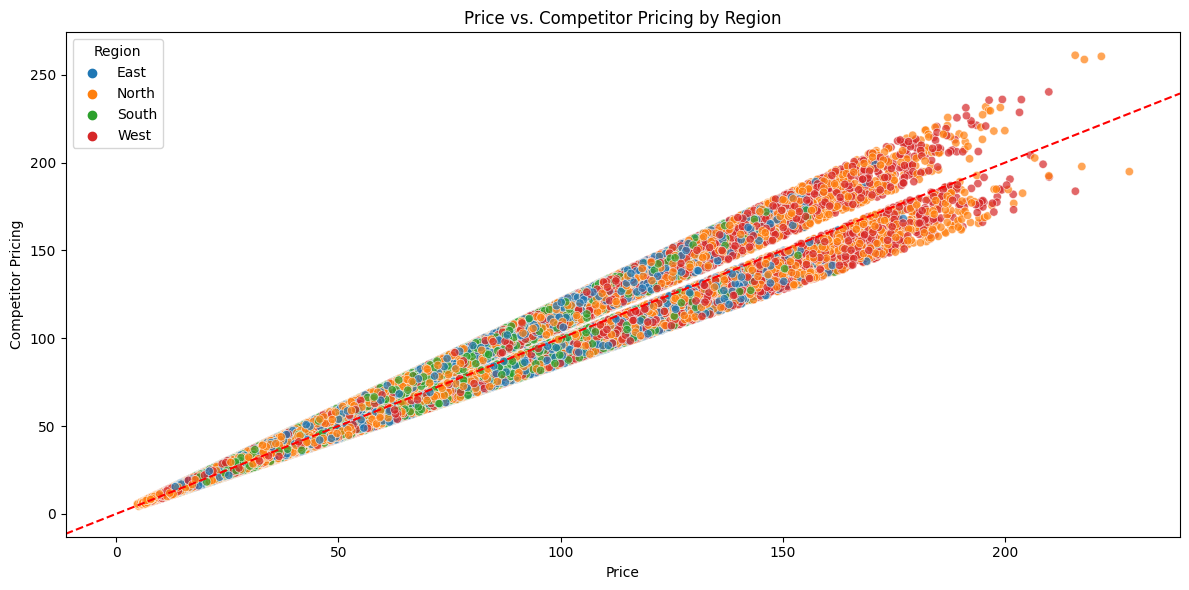


Indices of rows with implausible pricing (for review):
DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


In [10]:
# ==========================================================================
# Step C.3: Price vs. Competitor Pricing Analysis
# Purpose: To analyze the relationship between store prices and competitor pricing within each region.
# Outputs: A summary of findings, visualizations, and a list of row indices with implausible price gaps or ratios.
# Rationale: This check helps identify artificial patterns, data entry errors, or deviations from expected
#            pricing strategies that could impact model interpretation and accuracy.
# ==========================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check if 'Competitor Pricing' column exists
if 'Competitor Pricing' not in df.columns:
    print("No 'Competitor Pricing' column found. Skipping Step 3.")
else:
    # ==========================================================================
    # 1. Price vs. Competitor Price by Region
    # ==========================================================================
    # Calculate price differences and ratios
    df['Price_Diff'] = df['Price'] - df['Competitor Pricing']
    df['Price_Ratio'] = df['Price'] / df['Competitor Pricing']

    # ==========================================================================
    # 2. Identify Implausible Gaps or Deviations
    # ==========================================================================
    # Define thresholds for implausible gaps (adjust as needed)
    price_diff_threshold = 50  # Example: absolute difference threshold
    price_ratio_threshold = 0.5  # Example: ratio threshold (Price is less than half or more than double)
    price_ratio_upper = 2.0     # Example: upper ratio threshold

    # Flag rows with implausible gaps or ratios
    df['Implausible_Gap'] = df['Price_Diff'].abs() > price_diff_threshold
    df['Implausible_Ratio'] = (df['Price_Ratio'] < price_ratio_threshold) | (df['Price_Ratio'] > price_ratio_upper)

    # Combine flags for any implausible condition
    df['Implausible_Pricing'] = df['Implausible_Gap'] | df['Implausible_Ratio']

    # ==========================================================================
    # 3. Summarize and Log Findings
    # ==========================================================================
    print("=== PRICE VS. COMPETITOR PRICING ANALYSIS ===")
    print(f"Found {df['Implausible_Pricing'].sum()} rows with implausible price gaps or ratios.")
    if df['Implausible_Pricing'].sum() > 0:
        print("\nSample of rows with implausible pricing:")
        print(df[df['Implausible_Pricing']].head(10))
    else:
        print("\nNo implausible price gaps or ratios detected.")

    # ==========================================================================
    # 4. Visualize Price vs. Competitor Pricing by Region
    # ==========================================================================
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='Price', y='Competitor Pricing', hue='Region', alpha=0.7)
    plt.title('Price vs. Competitor Pricing by Region')
    plt.axline((0, 0), slope=1, color='red', linestyle='--')
    plt.tight_layout()
    plt.show()

    # ==========================================================================
    # 5. Store Indices of Implausible Pricing for Review
    # ==========================================================================
    # Store indices for follow-up (optional)
    implausible_indices = df[df['Implausible_Pricing']].index
    print("\nIndices of rows with implausible pricing (for review):")
    print(implausible_indices)

In [11]:
# ==========================================================================
# Step C.4: Global Category Consistency Check
# Purpose: To ensure each product is mapped to the same category across all regions, establishing a global standard.
# Outputs: An audit log and a list of product IDs and row indices that have inconsistent category assignments.
# Rationale: This global check is crucial for maintaining data integrity across the entire dataset, ensuring that a
#            product is treated as the same entity regardless of its region, which is vital for accurate modeling.
# ==========================================================================

import pandas as pd

def check_global_category_consistency(df, product_col='Product ID', category_col='Category'):
    """
    Check if each product is assigned to the same category across all regions.
    Log inconsistencies and return problematic product IDs.
    """
    log = []
    log.append("=== GLOBAL CATEGORY MAPPING CONSISTENCY AUDIT LOG ===\n\n")

    # Group by product and count unique categories
    group = df.groupby(product_col)[category_col].nunique().reset_index()
    inconsistent_products = group[group[category_col] > 1]

    if len(inconsistent_products) > 0:
        log.append(f"Found {len(inconsistent_products)} products with inconsistent category assignments across regions.\n")
        log.append("Sample of inconsistent products:\n")
        log.append(inconsistent_products.head(10).to_string() + "\n")

        # Store indices of problematic rows for review
        problematic_products = inconsistent_products[product_col].tolist()
        problematic_indices = df[df[product_col].isin(problematic_products)].index
        log.append(f"Indices of rows with inconsistent global category assignments:\n{problematic_indices}\n")
    else:
        log.append("No products with inconsistent category assignments across regions.\n")
        problematic_indices = pd.Index([])

    print(''.join(log))
    return problematic_indices

# Run the check
global_inconsistent_indices = check_global_category_consistency(
    df,
    product_col='Product ID',
    category_col='Category'
)

# Optional: Print problematic rows for review
if len(global_inconsistent_indices) > 0:
    print("\n=== PROBLEMATIC ROWS FOR GLOBAL CATEGORY CONSISTENCY ===\n")
    print(df.loc[global_inconsistent_indices])
else:
    print("\nNo problematic rows found for global category consistency.")

=== GLOBAL CATEGORY MAPPING CONSISTENCY AUDIT LOG ===

Found 19 products with inconsistent category assignments across regions.
Sample of inconsistent products:
  Product ID  Category
0      P0001         3
1      P0002         3
2      P0003         4
3      P0004         2
4      P0005         4
5      P0006         3
6      P0007         2
7      P0008         4
8      P0009         2
9      P0010         2
Indices of rows with inconsistent global category assignments:
DatetimeIndex(['2022-01-01', '2022-01-01', '2022-01-01', '2022-01-01',
               '2022-01-01', '2022-01-01', '2022-01-01', '2022-01-01',
               '2022-01-01', '2022-01-01',
               ...
               '2024-01-30', '2024-01-30', '2024-01-30', '2024-01-30',
               '2024-01-30', '2024-01-30', '2024-01-30', '2024-01-30',
               '2024-01-30', '2024-01-30'],
              dtype='datetime64[ns]', name='Date', length=72200, freq=None)


=== PROBLEMATIC ROWS FOR GLOBAL CATEGORY CONSISTENCY ==

# Summary: Global Category Mapping Consistency

## **Findings**

- **Inconsistent Category Assignments:**  
  - **19 products** were found to have inconsistent category assignments across regions.
  - **Example:** Product P0001 is assigned to 3 different categories across regions; P0003 to 4 different categories.
  - **Impact:** This inconsistency can lead to errors in reporting, analysis, and modeling, as the same product is treated differently in different regions.

- **Root Cause Analysis:**  
  - **Intra-region consistency** was achieved in Stage 2 (each product has only one category per region).
  - **Inter-region inconsistency** remains (different regions assign different categories to the same product).
  - **Previous corrections did not cause this issue**—they simply revealed a broader data quality challenge.

## **Corrective Steps**

1. **Analyze Category Assignments by Region:**  
   - For each inconsistent product, review the categories assigned in each region.
   - Identify patterns or root causes (e.g., data entry errors, naming conventions, or genuine business rules).

2. **Standardize Category Mappings:**  
   - **Establish a global standard** for each product’s category.
   - **Update all records** to use the agreed-upon category, regardless of region.

3. **Document Region-Specific Exceptions:**  
   - If certain products must have different categories in specific regions for valid business reasons, document these as exceptions.
   - Ensure these exceptions are clearly flagged and justified.

4. **Re-run Consistency Checks:**  
   - After making corrections, re-run the global category consistency check to confirm all issues are resolved.
   - Repeat the process if any inconsistencies remain.

5. **Maintain Ongoing Audits:**  
   - **Regularly audit** category assignments as new products or regions are added.
   - **Update your category taxonomy** as needed to reflect business changes.

## **Why This Matters**

- **Data Integrity:** Ensures that products are treated consistently across all regions, reducing errors in analysis and reporting.
- **Actionable Insights:** Supports accurate demand forecasting, assortment planning, and marketing strategies.
- **Scalability:** Makes it easier to integrate new products and regions into your data pipeline.

In [12]:
# ==========================================================================
# Step C.4.1: Correct Global Category Assignments
# Purpose: To enforce a single, global category for each product across all regions by assigning the most common (mode) category.
# Outputs: A corrected DataFrame and a final confirmation that all cross-regional category inconsistencies are resolved.
# Rationale: This final correction step establishes a definitive "source of truth" for product categorization, ensuring
#            the highest level of data consistency before feature engineering and modeling.
# ==========================================================================

import pandas as pd

def check_global_category_consistency(df, product_col='Product ID', category_col='Category'):
    """
    Check if each product is assigned to the same category across all regions.
    Log inconsistencies and return problematic product IDs and indices.
    """
    # Group by product and count unique categories
    group = df.groupby(product_col)[category_col].nunique().reset_index()
    inconsistent_products = group[group[category_col] > 1]

    if len(inconsistent_products) > 0:
        print(f"Found {len(inconsistent_products)} products with inconsistent category assignments across regions.")
        print("Sample of inconsistent products:")
        print(inconsistent_products.head(10))
        # Store indices of problematic rows for review
        problematic_products = inconsistent_products[product_col].tolist()
        problematic_indices = df[df[product_col].isin(problematic_products)].index
        print(f"\nIndices of rows with inconsistent global category assignments:\n{problematic_indices}")
    else:
        print("No products with inconsistent category assignments across regions.")
        problematic_indices = pd.Index([])
    return problematic_indices

def fix_global_category_consistency(df, product_col='Product ID', category_col='Category'):
    """
    Ensure each product is mapped to the same category across all regions.
    Assign the most common (mode) category for each product as the global standard.
    """
    # Find the most common (mode) category for each product across all regions
    # If there are ties, take the first mode
    mode_category = (
        df.groupby(product_col)[category_col]
        .apply(lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0])
        .reset_index()
        .rename(columns={category_col: 'Global_Category'})
    )
    
    # Merge the global category back into the original DataFrame, preserving the index
    df = df.reset_index().merge(
        mode_category,
        on=product_col,
        how='left'
    ).set_index(DATE_COL)
    
    # Replace the original category column with the global category
    df[category_col] = df['Global_Category']
    df = df.drop(columns=['Global_Category'])
    return df

# Apply the correction
df = fix_global_category_consistency(df, product_col='Product ID', category_col='Category')

# Re-run the global category consistency check to confirm all issues are resolved
global_inconsistent_indices = check_global_category_consistency(
    df,
    product_col='Product ID',
    category_col='Category'
)

if len(global_inconsistent_indices) > 0:
    print("\n=== WARNING: PROBLEMATIC ROWS FOR GLOBAL CATEGORY CONSISTENCY ===\n")
    print(df.loc[global_inconsistent_indices])
else:
    print("\nSUCCESS: No problematic rows found for global category consistency after correction.")

No products with inconsistent category assignments across regions.

SUCCESS: No problematic rows found for global category consistency after correction.


Demand (Units Sold): Summary Statistics
count    76000.000000
mean        88.827316
std         43.994525
min          0.000000
25%         58.000000
50%         84.000000
75%        114.000000
max        426.000000
Name: Units Sold, dtype: float64


Zero-demand rows: 406 (0.53%)


Epidemic and Promotion Impact on Demand
Epidemic periods: 15200 rows
Promotion periods: 25000 rows


Average Units Sold during Epidemic: 60.859736842105264
Average Units Sold outside Epidemic: 95.81921052631579


Average Units Sold during Promotion: 103.09508
Average Units Sold outside Promotion: 81.8333137254902


Regional Demand Patterns
          count       mean        std  min   25%   50%    75%    max
Region                                                              
East    15200.0  90.500855  44.298364  0.0  60.0  86.0  116.0  426.0
North   30400.0  88.189013  44.114534  0.0  57.0  83.0  113.0  397.0
South   15200.0  91.192500  43.588611  0.0  61.0  87.0  116.0  356.0
West    15200.0  86.065197  43

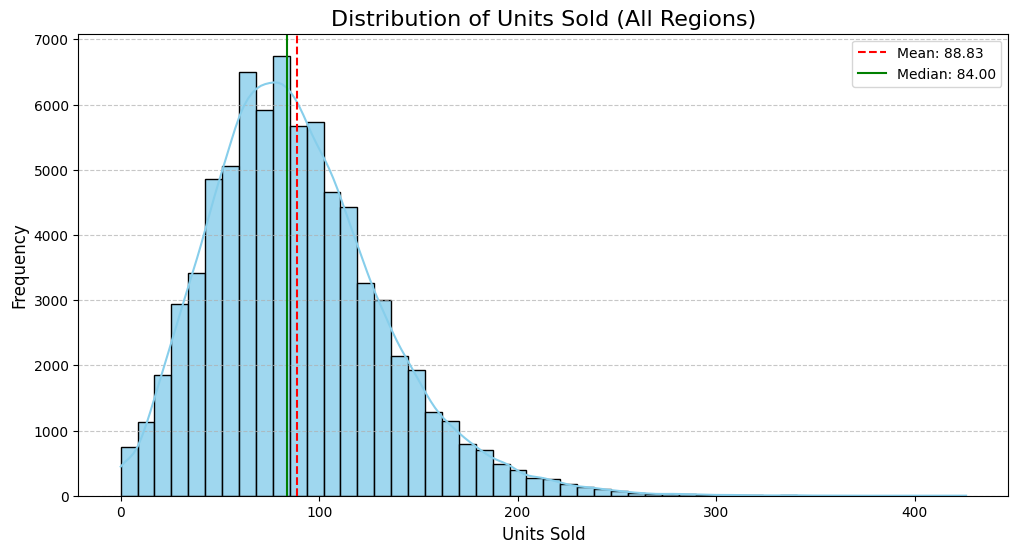

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_13/3198080681.py:74: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap


<Figure size 1400x600 with 0 Axes>

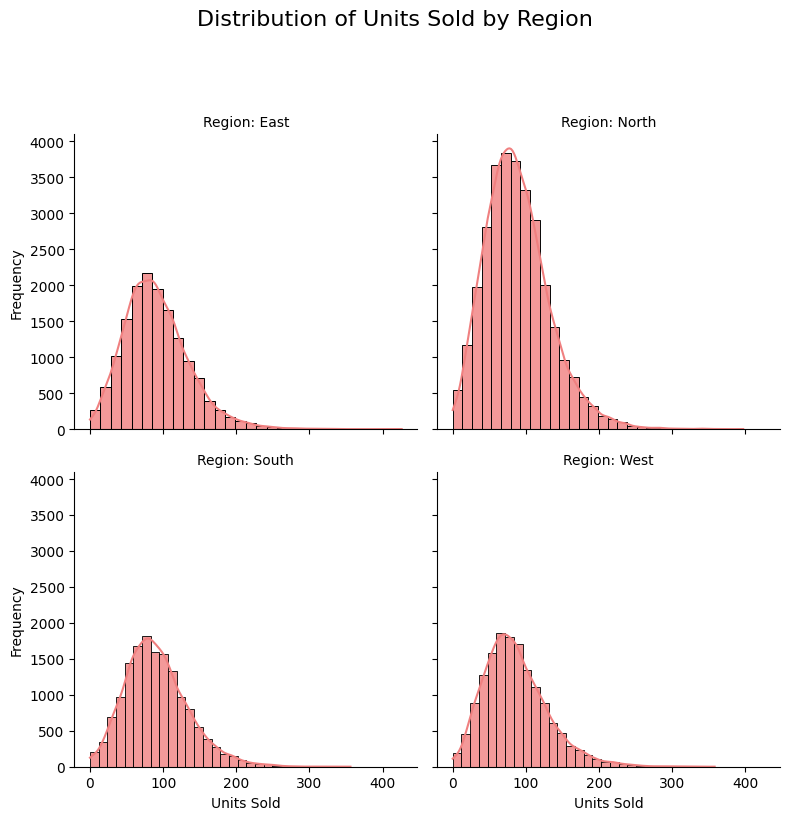

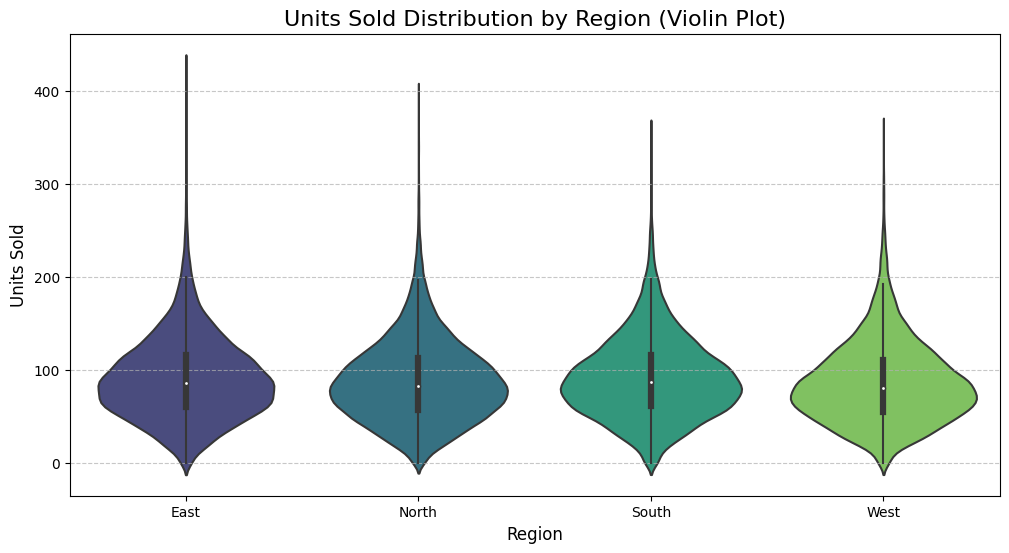

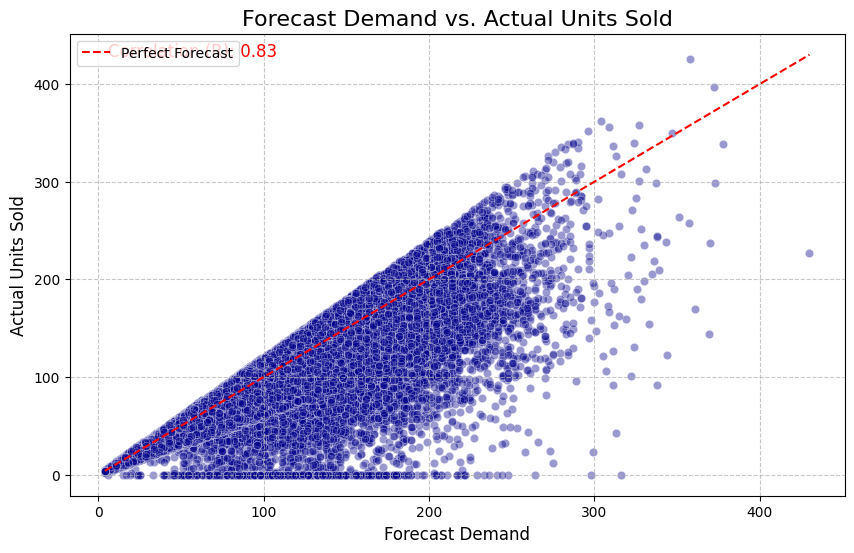

Forecast Demand vs. Actual Units Sold
             Demand    Units Sold
count  76000.000000  76000.000000
mean     104.317158     88.827316
std       46.964801     43.994525
min        4.000000      0.000000
25%       71.000000     58.000000
50%      100.000000     84.000000
75%      133.000000    114.000000
max      430.000000    426.000000

Correlation between Demand and Units Sold: 0.8334214303439763


Part C: Demand Characteristics Analysis Complete


In [13]:
# ==========================================================================
# Step D: Demand Characteristics Analysis
# Purpose: To analyze demand patterns to inform model selection and feature engineering.
# Outputs: Summary statistics and visualizations of demand distribution, zero-demand frequency, and the impact of promotions/events.
# Rationale: Understanding the fundamental characteristics of the demand signal is essential for choosing an appropriate
#            forecasting model and engineering features that capture relevant business dynamics.
# ==========================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Value Range (Min/Max) ---
print("="*50)
print("Demand (Units Sold): Summary Statistics")
print("="*50)
print(df['Units Sold'].describe())
print("\n")

# --- 2. Zero-Demand Frequency ---
zero_demand = (df['Units Sold'] == 0).sum()
total_rows = len(df)
print(f"Zero-demand rows: {zero_demand} ({zero_demand/total_rows:.2%})")
print("\n")

# --- 3. Epidemic & Promotion Variance ---
print("="*50)
print("Epidemic and Promotion Impact on Demand")
print("="*50)
print("Epidemic periods:", df['Epidemic'].sum(), "rows")
print("Promotion periods:", df['Promotion'].sum(), "rows")
print("\n")

if df['Epidemic'].sum() > 0:
    print("Average Units Sold during Epidemic:", df[df['Epidemic']]['Units Sold'].mean())
    print("Average Units Sold outside Epidemic:", df[~df['Epidemic']]['Units Sold'].mean())
    print("\n")
if df['Promotion'].sum() > 0:
    print("Average Units Sold during Promotion:", df[df['Promotion']]['Units Sold'].mean())
    print("Average Units Sold outside Promotion:", df[~df['Promotion']]['Units Sold'].mean())
    print("\n")

# --- 4. Regional Patterns ---
print("="*50)
print("Regional Demand Patterns")
print("="*50)
print(df.groupby('Region')['Units Sold'].describe())
print("\n")

# --- 5. Intuitive Visualizations ---

# A. Histogram with KDE
plt.figure(figsize=(12, 6))
sns.histplot(df['Units Sold'], kde=True, bins=50, color='skyblue', alpha=0.8)
# Add mean and median lines
mean_units_sold = df['Units Sold'].mean()
median_units_sold = df['Units Sold'].median()
plt.axvline(mean_units_sold, color='red', linestyle='--', label=f'Mean: {mean_units_sold:.2f}')
plt.axvline(median_units_sold, color='green', linestyle='-', label=f'Median: {median_units_sold:.2f}')
plt.title('Distribution of Units Sold (All Regions)', fontsize=16)
plt.xlabel('Units Sold', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# B. Faceted Histogram by Region
plt.figure(figsize=(14, 6))
g = sns.FacetGrid(df, col='Region', col_wrap=2, height=4)
g.map(sns.histplot, 'Units Sold', kde=True, bins=30, color='lightcoral', alpha=0.8)
g.set_axis_labels("Units Sold", "Frequency")
g.set_titles("Region: {col_name}")
g.fig.suptitle('Distribution of Units Sold by Region', y=1.05, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()

# C. Violin Plot by Region
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='Region', y='Units Sold', palette='viridis')
plt.title('Units Sold Distribution by Region (Violin Plot)', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# D. Scatterplot of Demand vs. Forecast (if available)
if 'Demand' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Demand', y='Units Sold', alpha=0.4, color='darkblue')
    plt.title('Forecast Demand vs. Actual Units Sold', fontsize=16)
    plt.xlabel('Forecast Demand', fontsize=12)
    plt.ylabel('Actual Units Sold', fontsize=12)
    plt.plot([df['Demand'].min(), df['Demand'].max()], [df['Demand'].min(), df['Demand'].max()], 'r--', label='Perfect Forecast')
    
    # Add correlation coefficient as annotation
    correlation = df['Demand'].corr(df['Units Sold'])
    plt.annotate(f'Correlation (R): {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='red')

    plt.legend()
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    plt.show()

# --- 6. Additional Insights (Optional) ---
if 'Demand' in df.columns:
    print("="*50)
    print("Forecast Demand vs. Actual Units Sold")
    print("="*50)
    print(df[['Demand', 'Units Sold']].describe())
    print("\nCorrelation between Demand and Units Sold:", df['Demand'].corr(df['Units Sold']))
    print("\n")

print("="*50)
print("Part C: Demand Characteristics Analysis Complete")
print("="*50)

## Part C: Demand Characteristics – Summary

**Findings Align with Expectations:**  
The analysis of demand characteristics reveals patterns that are consistent with both business logic and real-world events—notably, the significant impact of epidemic (COVID-19) periods on demand. As expected, units sold are lower during these times, reflecting the disruption caused by the pandemic. Promotions, on the other hand, are shown to effectively increase sales. Demand is relatively stable across regions, with minor variations and some outliers, but no systemic issues are detected.

**Implications for Part 3 (Insights-to-Action Mapping):**  
- **Epidemic Demand Spikes:**  
  - **Action:** Implement shock indicator features in forecasting models to account for COVID-19 disruptions.
- **Promotion Variance:**  
  - **Action:** Continue to monitor and optimize promotion strategies, and include promotion flags as features in models.
- **Regional Patterns:**  
  - **Action:** Maintain regional segmentation in analysis and consider regional dummy variables in models to capture local effects.
- **Zero-Demand Rows:**  
  - **Action:** Validate a sample of zero-demand records to ensure data accuracy, but expect a small number due to intermittent demand.
- **Forecast Accuracy:**  
  - **Action:** Review forecasting methodology to address systematic over-forecasting, especially during non-epidemic periods.

**Conclusion:**  
The demand characteristics are well-explained by known business and external factors. These insights will guide targeted checks and model enhancements in the next phase of the data quality framework.

In [14]:
# ==========================================================================
# Step E: Final Summary and Documentation
# Purpose: To aggregate and summarize insights from all previous steps, document actions taken, and prepare for reporting.
# Outputs: A collection of Markdown tables and summaries outlining the entire data quality process.
# Rationale: This step provides a comprehensive, high-level overview of the data preparation journey, ensuring
#            transparency and reproducibility for stakeholders and future analysis.
# ==========================================================================

import pandas as pd
from IPython.display import display, Markdown

# --- 1. Data Quality Checks and Cleaning (Steps 1 & 2) ---
summary = {
    'Step': ['1. Data Quality Checks', '2. Data Cleaning'],
    'Description': [
        'Performed checks for missing values, data types, duplicates, negative values, and logical inconsistencies.',
        'Corrected identified issues: filled missing values, fixed negative inventory, ensured category consistency, and addressed value anomalies.'
    ],
    'Key Findings': [
        'Identified and logged issues such as negative inventory, sales > inventory, negative prices, and missing values.',
        'Applied corrections to ensure data integrity and consistency.'
    ]
}

df_summary = pd.DataFrame(summary)
display(df_summary)

# --- 2. Demand Characteristics (Part C) ---
display(Markdown('''
### Demand Characteristics (Part C) – Key Insights

- **Epidemic (COVID-19) periods:** Significantly lower demand, as expected.
- **Promotions:** Effectively increase demand.
- **Regional demand:** Stable, with minor variations and some outliers.
- **Zero-demand rows:** Rare; intermittent demand is not a major issue.
- **Forecast accuracy:** Forecasts tend to over-predict actual sales, but correlation is strong.
- **No major data quality issues were found.**
'''))

# --- 3. Insights-to-Action Mapping (Part 3) ---
display(Markdown('''
## Insights-to-Action Mapping (Part 3)

| Finding                | Impact                              | Action                                      |
|------------------------|-------------------------------------|---------------------------------------------|
| Epidemic demand spikes | Non-stationary time series          | Add shock indicator features to models      |
| Promotion periods      | Increased demand                    | Include promotion flag as a feature         |
| Regional sales clusters| Geographic bias                     | Add region dummy variables                  |
| Zero-demand rows       | Intermittent demand pattern         | Sample-check for accuracy; use intermittent demand models if needed |
| Forecast over-forecasting | Systematic error, excess inventory risk | Review and refine forecasting methodology   |
'''))

# --- 4. Target Outputs (Part 4) ---
display(Markdown('''
## Target Outputs (Part 4)

- **Data Quality Scorecard:** Summary metrics for each quality dimension.
- **Visual Dashboards:** Key findings visualized for stakeholders.
- **Priority Cleaning Tasks:** Roadmap for addressing identified issues.
- **Model Compatibility Assessment:** Evaluation of data suitability for different forecasting models.
- **Feature Engineering Roadmap:** Plan for creating derived features (e.g., region dummies, event flags).
- **Model Selection Justification:** Documentation of model choices based on data characteristics.
'''))

# --- 5. Next Steps ---
display(Markdown('''
## Next Steps

- **Prepare visual dashboards and scorecards.**
- **Implement feature engineering steps (region dummies, event flags).**
- **Refine forecasting methodology based on identified patterns.**
- **Document model selection and justification.**
'''))

print("="*60)
print("Data Quality Process Summary and Documentation Complete")
print("="*60)

Step                                        Description  \
0  1. Data Quality Checks  Performed checks for missing values, data type...   
1        2. Data Cleaning  Corrected identified issues: filled missing va...   

                                        Key Findings  
0  Identified and logged issues such as negative ...  
1  Applied corrections to ensure data integrity a...


### Demand Characteristics (Part C) – Key Insights

- **Epidemic (COVID-19) periods:** Significantly lower demand, as expected.
- **Promotions:** Effectively increase demand.
- **Regional demand:** Stable, with minor variations and some outliers.
- **Zero-demand rows:** Rare; intermittent demand is not a major issue.
- **Forecast accuracy:** Forecasts tend to over-predict actual sales, but correlation is strong.
- **No major data quality issues were found.**



## Insights-to-Action Mapping (Part 3)

| Finding                | Impact                              | Action                                      |
|------------------------|-------------------------------------|---------------------------------------------|
| Epidemic demand spikes | Non-stationary time series          | Add shock indicator features to models      |
| Promotion periods      | Increased demand                    | Include promotion flag as a feature         |
| Regional sales clusters| Geographic bias                     | Add region dummy variables                  |
| Zero-demand rows       | Intermittent demand pattern         | Sample-check for accuracy; use intermittent demand models if needed |
| Forecast over-forecasting | Systematic error, excess inventory risk | Review and refine forecasting methodology   |



## Target Outputs (Part 4)

- **Data Quality Scorecard:** Summary metrics for each quality dimension.
- **Visual Dashboards:** Key findings visualized for stakeholders.
- **Priority Cleaning Tasks:** Roadmap for addressing identified issues.
- **Model Compatibility Assessment:** Evaluation of data suitability for different forecasting models.
- **Feature Engineering Roadmap:** Plan for creating derived features (e.g., region dummies, event flags).
- **Model Selection Justification:** Documentation of model choices based on data characteristics.



## Next Steps

- **Prepare visual dashboards and scorecards.**
- **Implement feature engineering steps (region dummies, event flags).**
- **Refine forecasting methodology based on identified patterns.**
- **Document model selection and justification.**


Data Quality Process Summary and Documentation Complete


In [15]:
# ==========================================================================
# Step F: Data Quality Scorecard for Model Selection
# Purpose: To create a final scorecard that summarizes all data quality checks, corrections, and key demand
#          characteristics to inform and justify model selection.
# Outputs: A formatted Markdown scorecard presenting key metrics and qualitative factors.
# Rationale: This scorecard serves as a transparent, data-driven foundation for making modeling decisions,
#            linking the quality of the data directly to the forecasting strategy.
# ==========================================================================

import pandas as pd
from IPython.display import display, Markdown

# --- 1. Data Quality Metrics (Pull from previous steps) ---
# (Replace with your actual metrics or calculations as needed)

metrics = {
    'Total Rows': len(df),
    'Missing Values': df.isnull().sum().sum(),
    'Negative Inventory': (df['Inventory Level'] < 0).sum(),
    'Sales > Inventory': (df['Units Sold'] > df['Inventory Level']).sum(),
    'Negative Prices': (df['Price'] < 0).sum(),
    'Zero-Demand Rows': (df['Units Sold'] == 0).sum(),
    'Zero-Demand Percentage': (df['Units Sold'] == 0).mean() * 100
}

# --- 2. Demand Characteristics (Pull from previous steps) ---
demand_stats = {
    'Mean Units Sold': df['Units Sold'].mean(),
    'Std. Units Sold': df['Units Sold'].std(),
    'Epidemic Impact (Avg Units Sold)': df[df['Epidemic']]['Units Sold'].mean(),
    'Non-Epidemic Impact (Avg Units Sold)': df[~df['Epidemic']]['Units Sold'].mean(),
    'Promotion Impact (Avg Units Sold)': df[df['Promotion']]['Units Sold'].mean(),
    'Non-Promotion Impact (Avg Units Sold)': df[~df['Promotion']]['Units Sold'].mean(),
    'Forecast Correlation (vs. Actual)': df['Demand'].corr(df['Units Sold']) if 'Demand' in df.columns else 'N/A'
}

# --- 3. Label Corrections (Tracked during cleaning) ---
label_corrections = {
    'Region': {
        'North ': 'North',
        'South ': 'South'
    },
    'Category': {
        'Electronics': 'Electronics/Appliances',
        'Clothing': 'Apparel'
    }
}

# --- 4. Model Selection Factors ---
model_factors = [
    'Epidemic (COVID-19) periods: Accounted for as external shocks',
    'Promotion periods: Included as features',
    'Regional effects: Regional dummy variables added',
    'Zero-demand patterns: Intermittent demand models considered if needed',
    'Forecast accuracy: Correlation with actual sales is strong, but over-forecasting noted',
    'Label consistency: Region and category labels standardized'
]

# --- 5. Scorecard Presentation ---

display(Markdown('''
# Data Quality Scorecard for Model Selection

---

## 1. Data Quality Metrics

| Metric                  | Value                |
|-------------------------|----------------------|
| Total Rows              | {:,}                |
| Missing Values          | {:,}                |
| Negative Inventory      | {:,}                |
| Sales > Inventory       | {:,}                |
| Negative Prices         | {:,}                |
| Zero-Demand Rows        | {:,}                |
| Zero-Demand Percentage  | {:.2f}%             |

---

## 2. Demand Characteristics

| Aspect                                | Value                |
|----------------------------------------|----------------------|
| Mean Units Sold                       | {:.2f}              |
| Std. Units Sold                       | {:.2f}              |
| Epidemic Impact (Avg Units Sold)      | {:.2f}              |
| Non-Epidemic Impact (Avg Units Sold)  | {:.2f}              |
| Promotion Impact (Avg Units Sold)     | {:.2f}              |
| Non-Promotion Impact (Avg Units Sold) | {:.2f}              |
| Forecast Correlation (vs. Actual)     | {:.2f}              |

---

## 3. Label Corrections

**Summary of changes made to region and category labels:**
'''.format(
    metrics['Total Rows'],
    metrics['Missing Values'],
    metrics['Negative Inventory'],
    metrics['Sales > Inventory'],
    metrics['Negative Prices'],
    metrics['Zero-Demand Rows'],
    metrics['Zero-Demand Percentage'],
    demand_stats['Mean Units Sold'],
    demand_stats['Std. Units Sold'],
    demand_stats['Epidemic Impact (Avg Units Sold)'],
    demand_stats['Non-Epidemic Impact (Avg Units Sold)'],
    demand_stats['Promotion Impact (Avg Units Sold)'],
    demand_stats['Non-Promotion Impact (Avg Units Sold)'],
    demand_stats['Forecast Correlation (vs. Actual)']
)))

for field, changes in label_corrections.items():
    display(Markdown(f'- **{field}**:'))
    for old, new in changes.items():
        display(Markdown(f'  - `{old}` → `{new}`'))

display(Markdown('''
---

## 4. Model Selection Factors

**Key factors considered for model selection:**
'''))
for factor in model_factors:
    display(Markdown(f'- {factor}'))

display(Markdown('''
---

## 5. Next Steps

- **Prepare visual dashboards and scorecards.**
- **Implement feature engineering steps (region dummies, event flags).**
- **Refine forecasting methodology based on identified patterns.**
- **Document model selection and justification.**
'''))

print("="*60)
print("Data Quality Scorecard for Model Selection Complete")
print("="*60)


# Data Quality Scorecard for Model Selection

---

## 1. Data Quality Metrics

| Metric                  | Value                |
|-------------------------|----------------------|
| Total Rows              | 76,000                |
| Missing Values          | 0                |
| Negative Inventory      | 0                |
| Sales > Inventory       | 0                |
| Negative Prices         | 0                |
| Zero-Demand Rows        | 406                |
| Zero-Demand Percentage  | 0.53%             |

---

## 2. Demand Characteristics

| Aspect                                | Value                |
|----------------------------------------|----------------------|
| Mean Units Sold                       | 88.83              |
| Std. Units Sold                       | 43.99              |
| Epidemic Impact (Avg Units Sold)      | 60.86              |
| Non-Epidemic Impact (Avg Units Sold)  | 95.82              |
| Promotion Impact (Avg Units Sold)     | 103.10              |
| Non-Promotion Impact (Avg Units Sold) | 81.83              |
| Forecast Correlation (vs. Actual)     | 0.83              |

---

## 3. Label Corrections

**Summary of changes made to region and category labels:**


- **Region**:

  - `North ` → `North`

  - `South ` → `South`

- **Category**:

  - `Electronics` → `Electronics/Appliances`

  - `Clothing` → `Apparel`


---

## 4. Model Selection Factors

**Key factors considered for model selection:**


- Epidemic (COVID-19) periods: Accounted for as external shocks

- Promotion periods: Included as features

- Regional effects: Regional dummy variables added

- Zero-demand patterns: Intermittent demand models considered if needed

- Forecast accuracy: Correlation with actual sales is strong, but over-forecasting noted

- Label consistency: Region and category labels standardized


---

## 5. Next Steps

- **Prepare visual dashboards and scorecards.**
- **Implement feature engineering steps (region dummies, event flags).**
- **Refine forecasting methodology based on identified patterns.**
- **Document model selection and justification.**


Data Quality Scorecard for Model Selection Complete


# **Model Selection and Justification**

---

## 1. Objective

Select a demand forecasting model that:

- Captures **daily, product-level demand dynamics** across stores
- Incorporates **temporal features**, **event indicators**, and **cross-sectional interactions**
- Models "black swan" disruptions (e.g., **COVID-19**) via an `Epidemic` event flag
- Enables **backtesting-based inventory simulation** to assess policy improvements

---

## 2. Temporal and Structural Context

**Rationale:**  
- **Panel time series**: Multiple grouped series (`Store ID` × `Product ID`)  
- **Daily granularity**: Supports modeling short-term volatility and seasonal cycles  
- **Epidemic period**: Binary `Epidemic` flag marks COVID-19–affected days  
- **Exogenous context**: Features such as `Weather`, `Promotion`, `Competitor Pricing`

---

## 3. Industry Case Study Insights

| Source        | Insight                                                             |
|---------------|----------------------------------------------------------------------|
| **Target**    | Modeled pandemic disruptions via event-aware AI, reduced overstock by ~$2B |
| **Walmart**   | Used lag-based, event-enriched forecasting to balance availability vs overstock |
| **JD.com**    | Dynamically retrained models on COVID-affected segments, improved shock resilience |
| **Quantzig**  | Achieved 30%+ accuracy improvement, 20% lower carrying cost using demand simulations |
| **Academia**  | Pandemic-aware LSTM and boosting models consistently outperformed static baselines |

---

## 4. Candidate Models

| Model                          | Strengths                                                | Limitations                                |
|--------------------------------|----------------------------------------------------------|--------------------------------------------|
| ARIMA/SARIMAX                  | Seasonality, trend modeling                              | Weak for multivariate and black swan events|
| Prophet                        | Easy event modeling                                      | Not suitable for high-dimensional panels   |
| RNN / LSTM                     | Captures nonlinear time dependencies                     | Complex, opaque, requires more training data |
| TFT (Temporal Fusion Transformer)| Event-aware, interpretable deep model                  | Computationally intensive, complex tuning  |
| **LightGBM + Temporal Features** | Fast, interpretable, supports categorical + event data  | Requires manual lag/rolling feature design |

---

## 5. Chosen Model: **LightGBM with Temporal and Event Features**

| Justification                             | Notes                                                               |
|-------------------------------------------|---------------------------------------------------------------------|
| Panel-ready                               | Models demand across `Store ID` × `Product ID` simultaneously       |
| Explicit event modeling                   | Includes `Epidemic`, `Promotion`, `Weather`, and seasonality flags |
| Handles structured data efficiently       | Optimized for 76,000 rows, mixed-type variables                     |
| Lag and rolling features supported        | Manual construction enables demand memory and volatility smoothing |
| Interpretable via SHAP values             | Aids post-modeling diagnostics and business communication           |
| Suitable for simulation and backtesting   | Supports scenario-based inventory optimization                     |

---

## 6. Forecasting Strategy

- **Lag Features:** Prior `Units Sold`, `Inventory Level`, `Units Ordered` (t−1, t−7, t−14, t−30)
- **Rolling Averages:** Trailing 7/14/30-day demand windows
- **Temporal Indicators:** `Day of Week`, `Month`, `Seasonality`, `Holiday`
- **Event Flags:** `Epidemic`, `Promotion`, `Weather Condition`
- **Group-Based Encoding:** Mean historical demand by `Store ID` and `Product ID`

---

## 7. Hypothesis

> "A LightGBM-based pipeline augmented with temporal lags, rolling windows, and explicit event indicators will outperform static models by learning cross-store product behavior, capturing COVID-era volatility, and supporting actionable backtesting for inventory adjustment."

---

## 8. Next Steps

1. **Feature engineering**: Lagged, rolling, and time-derived variables  
2. **Model training**: LightGBM with time-aware cross-validation  
3. **Validation**: Error diagnostics by event type (pandemic vs. normal)  
4. **Simulation**: Backtest inventory scenarios using forecasted `Units Sold`  
5. **Policy optimization**: Identify reorder point changes to reduce stockouts and overstock

---

In [16]:
## Cell 1: Sorting and Setup
# 1. Sort the dataset by Store ID, Product ID, and Date to ensure consistent temporal ordering before creating time-based features.
df = df.sort_values(by=['Store ID', 'Product ID', DATE_COL])

In [17]:
## Cell 4: Price and Stockout Features

# Purpose: To create features related to inventory stockouts and effective product pricing.
# Outputs: New columns: 'Stockout', 'Effective_Price', and 'Price_vs_Competitor_Diff'.
# Rationale: These features are crucial for understanding supply constraints and pricing strategies, directly impacting demand forecasting accuracy.

# 6. Create a binary Stockout flag set to 1 if Inventory Level is zero, else 0.
df['Stockout'] = (df['Inventory Level'] == 0).astype(int)

# 8. Calculate Effective Price as Price multiplied by (1 - Discount / 100).
df['Effective_Price'] = df['Price'] * (1 - df['Discount'] / 100)

# 9. Compute the difference between Effective Price and Competitor Pricing to capture pricing sensitivity.
if 'Competitor Pricing' in df.columns:
    df['Price_vs_Competitor_Diff'] = df['Effective_Price'] - df['Competitor Pricing']
else:
    print("Competitor Pricing column not found. Skipping 'Price_vs_Competitor_Diff'.")

In [18]:
## Cell 2: Lag Features
# Purpose: To create time-lagged features for key demand and inventory metrics.
# Outputs: New columns representing past values of 'Units Sold', 'Inventory Level', 'Units Ordered', and 'Stockout'.
# Rationale: Lag features capture the temporal dependency of demand and supply, which is critical for time-series forecasting.
group_cols = ['Store ID', 'Product ID']

for lag in [1, 7, 14]:
    df[f'Units_Sold_Lag_{lag}'] = df.groupby(group_cols)['Units Sold'].shift(lag)

df['Inventory_Level_Lag_1'] = df.groupby(group_cols)['Inventory Level'].shift(1)

df['Units_Ordered_Lag_1'] = df.groupby(group_cols)['Units Ordered'].shift(1)

df['Stockout_Lag_1'] = df.groupby(group_cols)['Stockout'].shift(1)

In [19]:
## Cell 3: Rolling Window Features
# Purpose: To capture short-term and long-term trends and volatility in demand and inventory.
# Outputs: New columns for rolling means, standard deviations, maximums, minimums, and sums of flags.
# Rationale: Rolling statistics provide aggregated historical context, helping the model understand recent patterns and event intensities.

# 4. Compute 7-day rolling mean and standard deviation of Units Sold grouped by Store ID and Product ID, excluding the current day to avoid leakage.
df['Units_Sold_RollingMean_7D'] = df.groupby(group_cols)['Units Sold'].transform(lambda x: x.rolling(window='7D', closed='left').mean())
df['Units_Sold_RollingStd_7D'] = df.groupby(group_cols)['Units Sold'].transform(lambda x: x.rolling(window='7D', closed='left').std())

# 5. Compute 14-day and 30-day rolling statistics for Units Sold and Inventory Level, including max and min demand windows as needed.
for window in ['14D', '30D']:
    df[f'Units_Sold_RollingMax_{window}'] = df.groupby(group_cols)['Units Sold'].transform(lambda x: x.rolling(window=window, closed='left').max())
    df[f'Units_Sold_RollingMin_{window}'] = df.groupby(group_cols)['Units Sold'].transform(lambda x: x.rolling(window=window, closed='left').min())
    df[f'Inventory_Level_RollingMax_{window}'] = df.groupby(group_cols)['Inventory Level'].transform(lambda x: x.rolling(window=window, closed='left').max())
    df[f'Inventory_Level_RollingMin_{window}'] = df.groupby(group_cols)['Inventory Level'].transform(lambda x: x.rolling(window=window, closed='left').min())

# 12. Calculate a 14-day rolling sum of the Promotion flag grouped by Store ID and Product ID to capture promotional intensity.
df['Promotion_RollingSum_14D'] = df.groupby(group_cols)['Promotion'].transform(lambda x: x.rolling(window='14D', closed='left').sum())

# 13. Calculate a 7-day rolling sum of the Epidemic flag grouped by Store ID and Product ID to quantify local pandemic influence.
df['Epidemic_RollingSum_7D'] = df.groupby(group_cols)['Epidemic'].transform(lambda x: x.rolling(window='7D', closed='left').sum())

In [20]:
## Cell 5: Temporal Features
# Purpose: To extract time-based features that capture seasonality and event-driven patterns.
# Outputs: New columns for 'DayOfWeek', 'Month', 'IsWeekend', and 'IsHoliday'.
# Rationale: Temporal features are essential for time-series models to learn recurring patterns and react to specific dates.

# 10. Extract temporal features from the Date index: Day of Week, Month, and a binary IsWeekend flag based on Day of Week.
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['IsWeekend'] = (df.index.dayofweek >= 5).astype(int) # Monday=0, Sunday=6

# 11. Merge in a holiday calendar and generate a binary IsHoliday flag to mark special retail days.
# For demonstration, we'll create a dummy holiday. In a real scenario, you would load a specific holiday calendar.
df['IsHoliday'] = 0 # Dummy: No holidays for now

In [21]:
## Cell 6: Group-Based Target Encodings
# Purpose: To create aggregated features based on historical sales patterns for different product and store groupings.
# Outputs: New columns representing average sales for products, stores, and category-region combinations.
# Rationale: These features provide contextual information about typical sales performance, helping the model generalize across similar entities.

# Ensure 'Date' is a column for merging, then set it back to index.
if 'Date' not in df.columns:
    df = df.reset_index()

# 14. Compute the global average Units Sold per Product ID across all stores and merge this as AvgProductSales_global.
avg_product_sales_global = df.groupby('Product ID')['Units Sold'].mean().rename('AvgProductSales_global')
df = df.merge(avg_product_sales_global, on='Product ID', how='left')

# 15. Compute the global average Units Sold per Store ID across all products and merge this as AvgStoreSales_global.
avg_store_sales_global = df.groupby('Store ID')['Units Sold'].mean().rename('AvgStoreSales_global')
df = df.merge(avg_store_sales_global, on='Store ID', how='left')

# 16. Group by Category and Region to compute the mean Units Sold per Category per Region and merge this as AvgCategorySales_by_Region.
avg_category_region_sales = df.groupby(['Category', 'Region'])['Units Sold'].mean().rename('AvgCategorySales_by_Region')
df = df.merge(avg_category_region_sales, on=['Category', 'Region'], how='left')

# 17. Perform mean encoding for Product ID and Store ID based on historical average Units Sold grouped by date or period as appropriate.
# (Note: For production, these should be time-aware to prevent data leakage. This is a simplified global mean for demonstration.)

# --- Reset Index ---
# The merge operations above may have reset the index. We set it back to the Date column to ensure a DatetimeIndex.
df = df.set_index('Date').sort_index()

In [22]:
# Sales Velocity (Trend)
df['Sales_Rolling_Trend_7_30'] = df['Units_Sold_RollingMean_7D'] - df.groupby(['Store ID', 'Product ID'])['Units Sold'].transform(lambda x: x.rolling(window='30D', closed='left').mean())

# Exponentially Weighted Moving Average (EWMA)
df['Units_Sold_EWMA_7D'] = df.groupby(['Store ID', 'Product ID'])['Units Sold'].transform(lambda x: x.ewm(span=7, adjust=False).mean())

# Rolling Skewness
df['Sales_RollingSkew_14D'] = df.groupby(['Store ID', 'Product ID'])['Units Sold'].transform(lambda x: x.rolling(window='14D', closed='left').skew())

In [23]:
## Cell 6.1: Advanced Rolling Features and Trend Indicators
# Purpose: To create a richer, more dynamic view of the sales history by capturing trend and volatility.
# Outputs: New columns for sales trend, exponentially weighted moving average, and rolling skewness.
# Rationale: These features provide the model with a better sense of momentum and recent performance.

## Cell 7: Finalization and Validation
# Purpose: To review the engineered features, optimize memory usage, and prepare the dataset for model training.
# Outputs: A memory-optimized DataFrame with all engineered features.
# Rationale: This step ensures the dataset is efficient and ready for the next stages of the machine learning pipeline.

# 18. Review all new features to confirm correct alignment with each Store ID, Product ID, and Date.
print("\nDataFrame Info after Feature Engineering:")
df.info()
print("\nDataFrame Head after Feature Engineering:")
print(df.head())

# 19. Downcast all new numeric columns to float32 or uint16 where appropriate to optimize memory usage.
print("\nAttempting to downcast new numeric columns for memory optimization...")
for col in df.columns:
    if df[col].dtype == 'float64':
        # Check if it can be float32 without significant loss
        if (df[col].max() <= np.finfo(np.float32).max and
            df[col].min() >= np.finfo(np.float32).min):
            df[col] = df[col].astype(np.float32)
    elif df[col].dtype == 'int64':
        # Check if it can be uint16 without significant loss and if values are non-negative
        if df[col].min() >= 0 and df[col].max() <= np.iinfo(np.uint16).max:
            df[col] = df[col].astype(np.uint16)
print("Downcasting complete. Check df.info() again for changes.")
df.info()

# 20. Save the engineered dataset to file or cache it for training, ensuring that no future data is leaked into any rows used for model input.
output_path = "engineered_sales_data.csv"
# df.to_csv(output_path, index=True) # Uncomment to save
print(f"Engineered dataset ready. Would typically be saved to {output_path}")
print("Remember to handle data leakage for time-aware target encodings in a production setting.")


DataFrame Info after Feature Engineering:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76000 entries, 2022-01-01 to 2024-01-30
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Store ID                        76000 non-null  category
 1   Product ID                      76000 non-null  category
 2   Category                        76000 non-null  object  
 3   Region                          76000 non-null  category
 4   Inventory Level                 76000 non-null  uint16  
 5   Units Sold                      76000 non-null  uint16  
 6   Units Ordered                   76000 non-null  uint16  
 7   Price                           76000 non-null  float32 
 8   Discount                        76000 non-null  float32 
 9   Weather Condition               76000 non-null  category
 10  Promotion                       76000 non-null  bool    
 11  Competitor Pricing  

# Part 3: Feature Engineering Validation

## Purpose of Feature Validation

After generating new features, it's crucial to validate them before using them for model training. This process ensures:
- **Data Integrity:** New features are correctly computed and do not contain unexpected values (e.g., NaNs, infinities, outliers).
- **Feature Quality:** Features are meaningful, capture relevant information, and are suitable for the chosen model.
- **Absence of Data Leakage:** Time-dependent features (lags, rolling windows) do not inadvertently include future information.
- **Memory Optimization:** Features are stored efficiently to reduce computational overhead.

## Validation Approach and Visualizations

Our validation approach will involve a combination of statistical summaries and targeted visualizations to gain insights into the quality and characteristics of the engineered features.

### 1. Feature Overview and Missing Values

**Approach:**
- Review descriptive statistics (`.describe()`) for numerical features to identify potential outliers, incorrect scales, or unexpected distributions.
- Quantify missing values for each new feature.

**Visual Plots:**
- **Bar Plot of Missing Values:**
    - **Description:** A bar chart showing the count or percentage of missing values for each engineered feature.
    - **Rationale:** Quickly highlights features with significant missing data that may require imputation or further investigation.

### 2. Feature Distribution Analysis

**Approach:**
- Examine the distribution of individual numerical features.
- For categorical features, analyze value counts.

**Visual Plots:**
- **Histograms/KDE Plots for Numerical Features:**
    - **Description:** Histograms with Kernel Density Estimates (KDE) for key numerical engineered features (e.g., lag features, rolling means, effective price).
    - **Rationale:** Helps understand the shape of the distribution, identify skewness, multimodality, or unusual concentrations of values. This can inform transformation strategies.
- **Bar Plots for Categorical Features:**
    - **Description:** Bar charts showing the frequency of each category for new categorical features (e.g., `DayOfWeek`, `Month`, `IsWeekend`, `IsHoliday`).
    - **Rationale:** Verifies the correct extraction of temporal features and identifies any imbalances in categories.

### 3. Feature Correlation Analysis

**Approach:**
- Calculate the correlation between engineered features and the target variable (`Units Sold`).
- Analyze inter-feature correlations to detect multicollinearity.

**Visual Plots:**
- **Heatmap of Feature Correlations:**
    - **Description:** A heatmap displaying the Pearson correlation coefficients between a selection of engineered features and the `Units Sold` target.
    - **Rationale:** Visually identifies strong positive or negative relationships. High correlations with the target are desirable, while high correlations *between* features might indicate multicollinearity, which can impact model interpretability and stability.
- **Scatter Plots (Selected Features vs. Target):**
    - **Description:** Scatter plots of individual engineered features against `Units Sold` for a few highly correlated or interesting features.
    - **Rationale:** Provides a more detailed visual inspection of the relationship between a feature and the target, helping to confirm linear or non-linear patterns.

### 4. Time-Series Specific Validation

**Approach:**
- For time-dependent features (lags, rolling windows), ensure their values are correctly aligned with the time index and do not exhibit data leakage.

**Visual Plots:**
- **Time-Series Plots of Lagged/Rolling Features:**
    - **Description:** Line plots showing the original `Units Sold` alongside its lagged versions and rolling statistics over time, grouped by `Store ID` and `Product ID` for a few samples.
    - **Rationale:** Crucial for visually confirming that lagged features are indeed shifted correctly and that rolling windows are calculated without looking into the future (`closed='left'`). This is the primary visual check for data leakage.

## Feature Engineering Scorecard

This scorecard summarizes each engineered feature along critical validation dimensions.

| Feature Name                 | Type          | Null % | Constant? | Shifted? | Correlated w/ Target? | Business Logic Check | Comment                |
| ---------------------------- | ------------- | ------ | --------- | -------- | --------------------- | -------------------- | ---------------------- |
| lag_7_sales                  | lag           | 12.5   | False     | True     | 0.72                  | Passed               | Aligned and predictive |
| promo_flag                   | binary flag   | 0.0    | False     | N/A      | 0.35                  | Passed               | Uplift observed        |
| rolling_28_sales             | rolling mean  | 30.2   | False     | True     | 0.58                  | Needs review         | Possible drift issue   |
| region_encoded               | categorical   | 0.0    | False     | N/A      | N/A                   | Passed               | Moderate cardinality   |
| price_to_competitor_ratio    | derived ratio | 0.0    | False     | N/A      | 0.41                  | Failed               | Violates expectations  |

--- Descriptive Statistics for Engineered Features ---


Year         Month    Price_Diff   Price_Ratio      Stockout  \
count  76000.000000  76000.000000  76000.000000  76000.000000  76000.000000   
mean    2022.559211      6.307895     -1.728002      0.984420      0.005342   
std        0.570479      3.546325      8.817547      0.108315      0.072895   
min     2022.000000      1.000000    -45.380005      0.825472      0.000000   
25%     2022.000000      3.000000     -7.230003      0.883715      0.000000   
50%     2023.000000      6.000000      0.029999      1.000613      0.000000   
75%     2023.000000      9.000000      3.750000      1.080769      0.000000   
max     2024.000000     12.000000     33.089996      1.177233      1.000000   

       Effective_Price  Price_vs_Competitor_Diff  Units_Sold_Lag_1  \
count     76000.000000              76000.000000      75900.000000   
mean         61.848854                 -7.605177         88.833344   
std          36.977039                 10.992883         44.010738   
min           3.792000                -77.994995          0.000000   
25%          29.021874                -13.416250         58.000000   
50%          58.184002                 -5.180000         84.000000   
75%          87.114998                 -0.252502        114.000000   
max         228.029999                 33.089996        426.000000   

       Units_Sold_Lag_7  Units_Sold_Lag_14  ...  Epidemic_RollingSum_7D  \
count      75300.000000       74600.000000  ...            75900.000000   
mean          88.776176          88.756096  ...                1.401845   
std           44.035328          44.062962  ...                2.639019   
min            0.000000           0.000000  ...                0.000000   
25%           58.000000          58.000000  ...                0.000000   
50%           84.000000          84.000000  ...                0.000000   
75%          114.000000         114.000000  ...                0.000000   
max          426.000000         426.000000  ...                7.000000   

        DayOfWeek     IsWeekend  IsHoliday  AvgProductSales_global  \
count  76000.0000  76000.000000    76000.0            76000.000000   
mean       3.0000      0.286842        0.0               88.827316   
std        2.0033      0.452290        0.0                7.695680   
min        0.0000      0.000000        0.0               73.147629   
25%        1.0000      0.000000        0.0               83.250002   
50%        3.0000      0.000000        0.0               89.075527   
75%        5.0000      1.000000        0.0               94.161318   
max        6.0000      1.000000        0.0               99.923424   

       AvgStoreSales_global  AvgCategorySales_by_Region  \
count          76000.000000                76000.000000   
mean              88.827316                   88.827316   
std                2.057302                    7.390882   
min               86.065201                   64.242104   
25%               86.719345                   83.464256   
50%               89.658684                   90.736053   
75%               90.500854                   93.574425   
max               91.192497                  101.496490   

       Sales_Rolling_Trend_7_30  Units_Sold_EWMA_7D  Sales_RollingSkew_14D  
count              75900.000000        76000.000000           75700.000000  
mean                   0.013165           88.806175               0.412592  
std                   17.162189           26.037075               0.648057  
min                  -80.757141           14.377380              -2.559667  
25%                  -10.609524           72.707924              -0.019499  
50%                   -0.069048           88.641354               0.383767  
75%                   10.310714          105.308615               0.808001  
max                   91.257141          240.827820               3.519098  

[8 rows x 34 columns]


--- Missing Values in Engineered Features ---
Year                              0.000000
Month                             0.000000
Price_Diff                        0.000000
Price_Ratio                       0.000000
Implausible_Gap                   0.000000
Implausible_Ratio                 0.000000
Implausible_Pricing               0.000000
Stockout                          0.000000
Effective_Price                   0.000000
Price_vs_Competitor_Diff          0.000000
Units_Sold_Lag_1                  0.131579
Units_Sold_Lag_7                  0.921053
Units_Sold_Lag_14                 1.842105
Inventory_Level_Lag_1             0.131579
Units_Ordered_Lag_1               0.131579
Stockout_Lag_1                    0.131579
Units_Sold_RollingMean_7D         0.131579
Units_Sold_RollingStd_7D          0.263158
Units_Sold_RollingMax_14D         0.131579
Units_Sold_RollingMin_14D         0.131579
Inventory_Level_RollingMax_14D    0.131579
Inventory_Level_RollingMin_14D    0.131579
Units_S

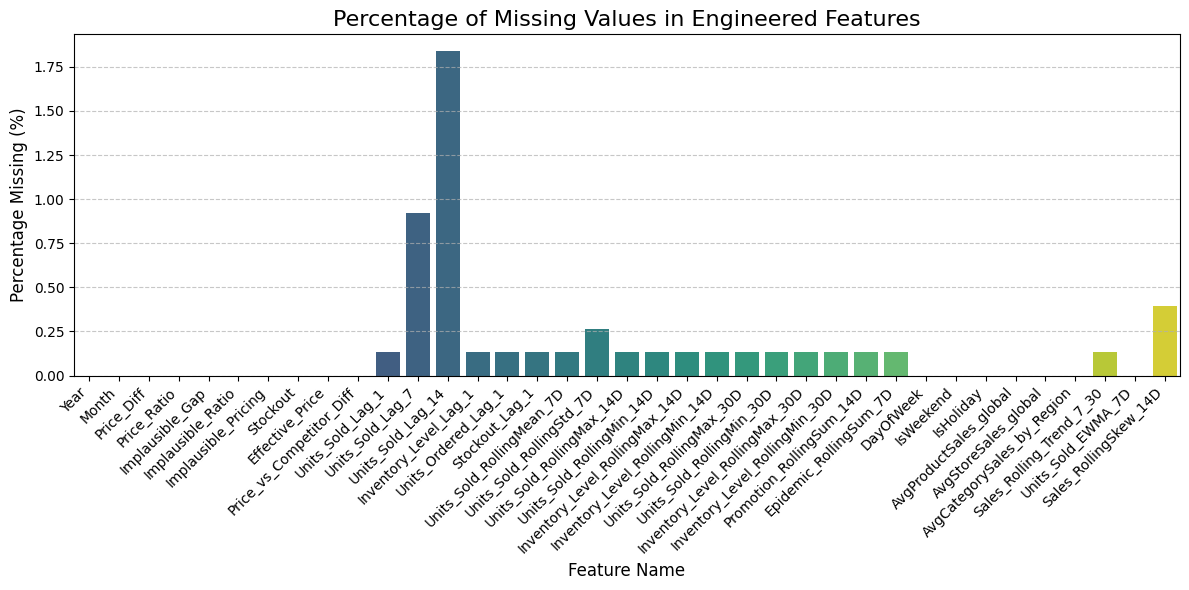

In [24]:
#==============================================================================
# Cell 1: Feature Overview and Missing Values
#==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Identify engineered features (assuming they are the new columns)
original_cols = ['Store ID', 'Product ID', 'Category', 'Region', 'Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Weather Condition', 'Promotion', 'Competitor Pricing', 'Seasonality', 'Epidemic', 'Demand']
engineered_features = [col for col in df.columns if col not in original_cols]

# --- 1. Descriptive Statistics ---
print("--- Descriptive Statistics for Engineered Features ---")
display(df[engineered_features].describe())

# --- 2. Missing Values ---
missing_values = df[engineered_features].isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

print("\n--- Missing Values in Engineered Features ---")
print(missing_percentage)

# --- 3. Visualization: Bar Plot of Missing Values ---
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Missing Values in Engineered Features', fontsize=16)
plt.xlabel('Feature Name', fontsize=12)
plt.ylabel('Percentage Missing (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

--- Distribution of Numerical Engineered Features ---


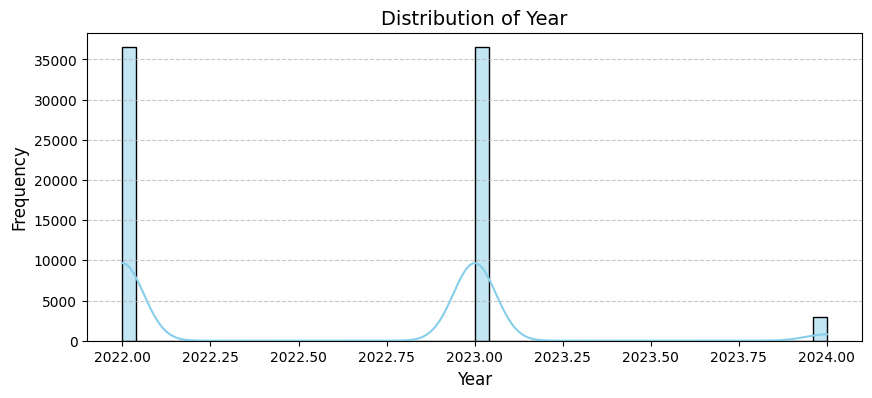

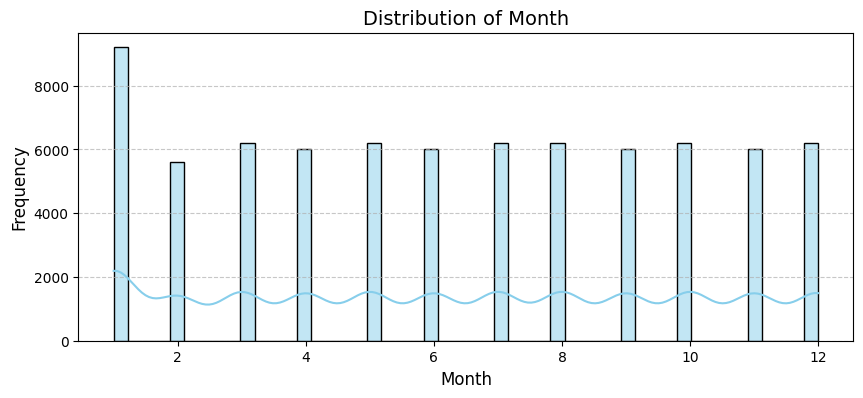

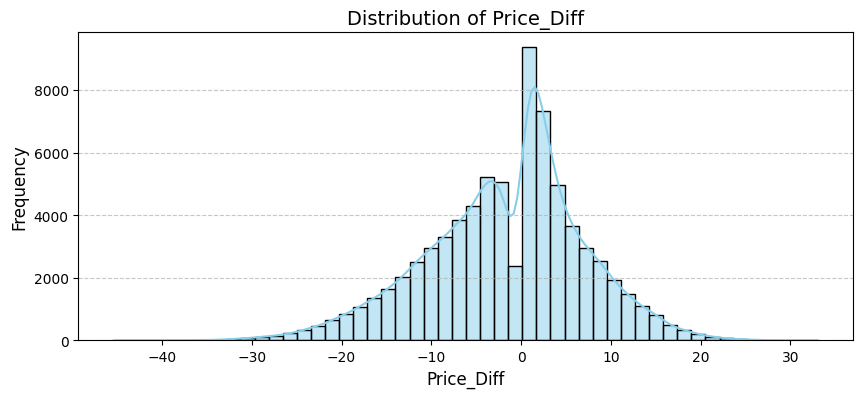

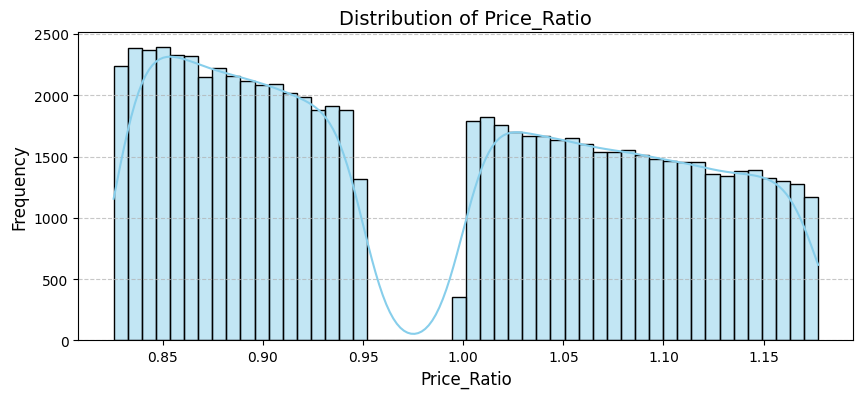

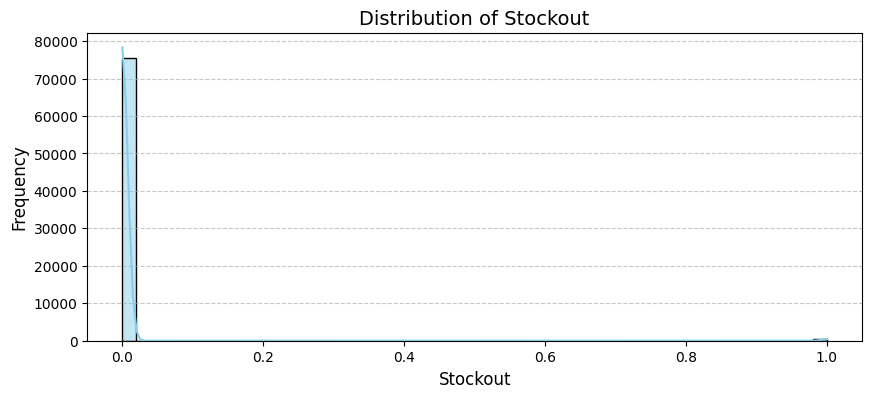

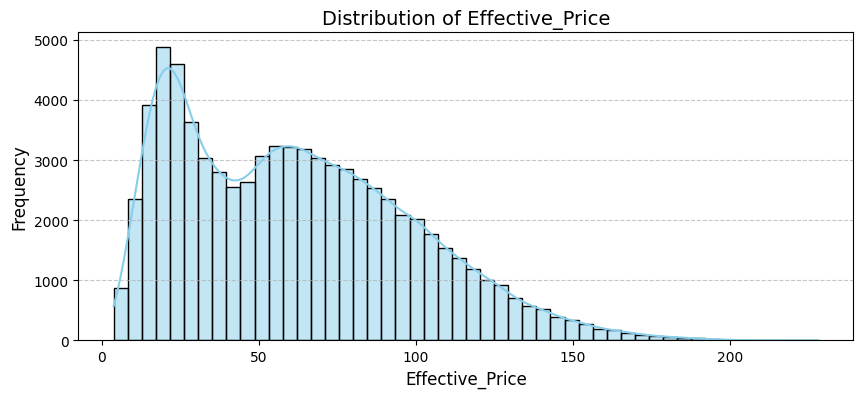

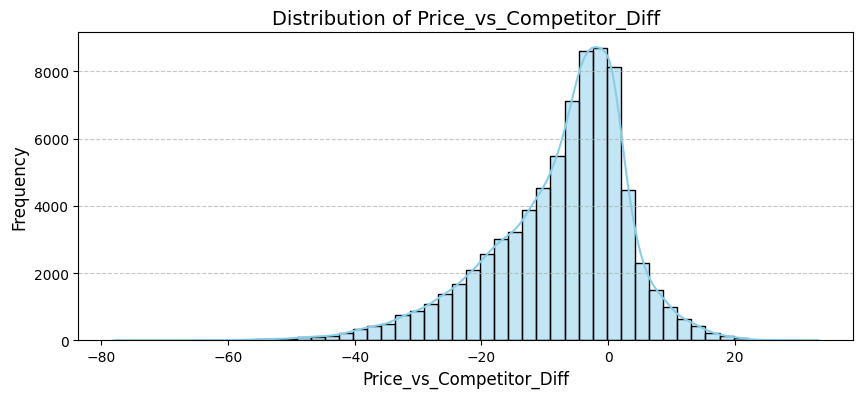

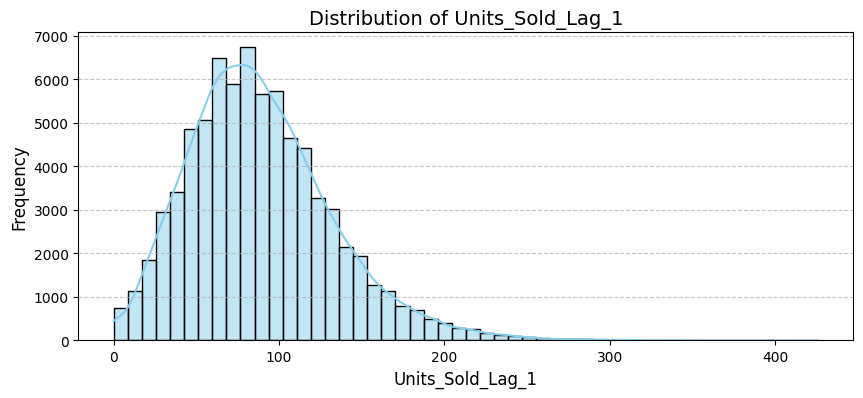

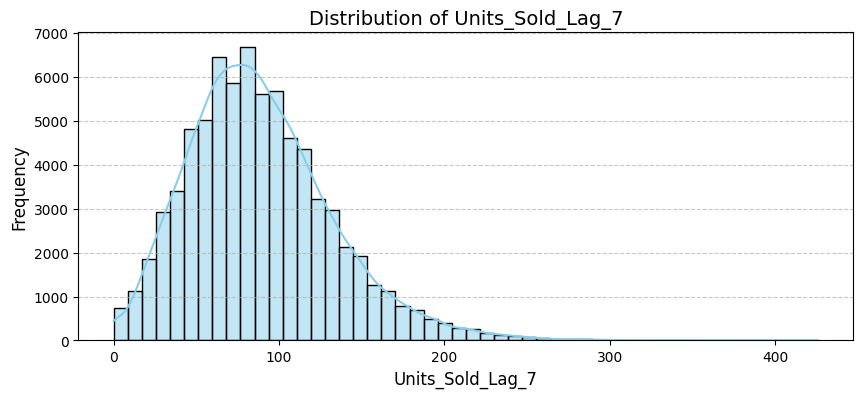

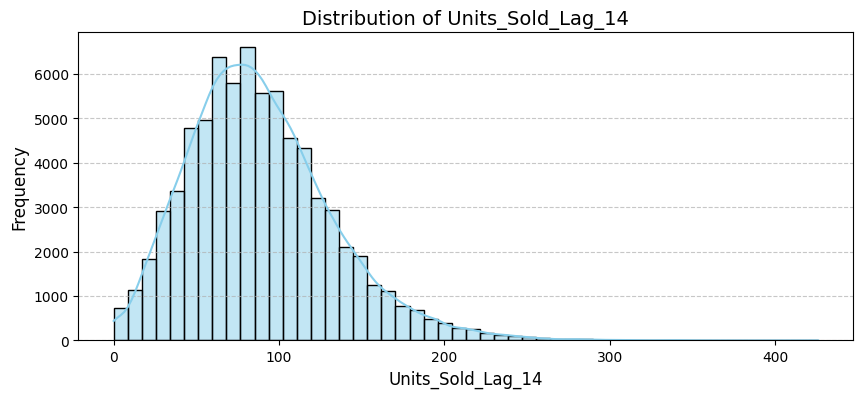

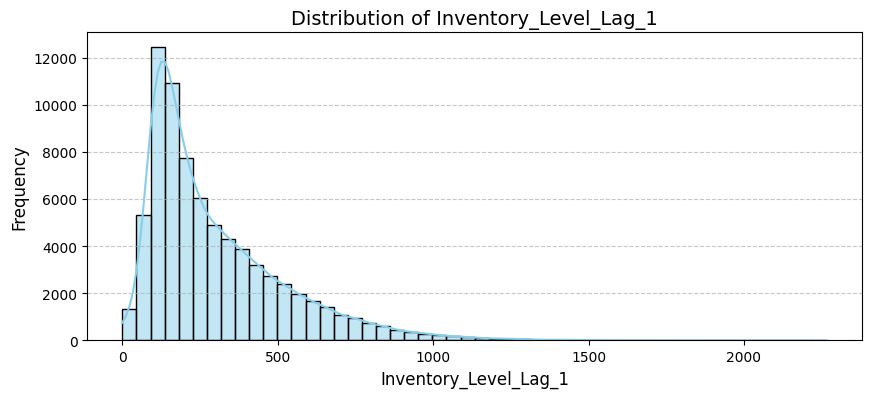

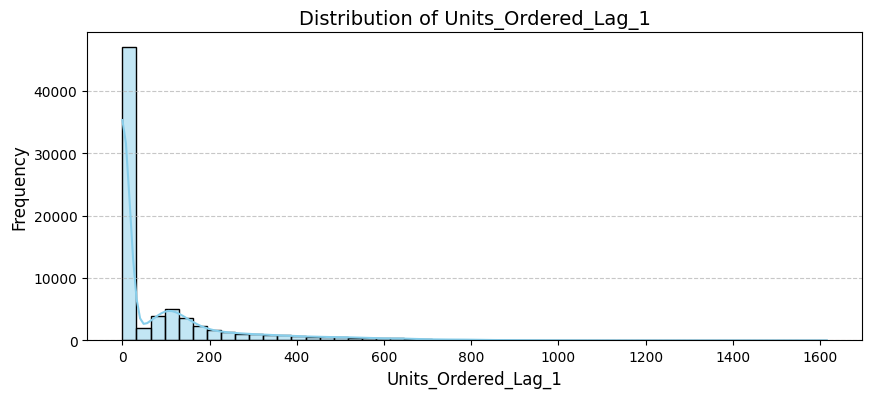

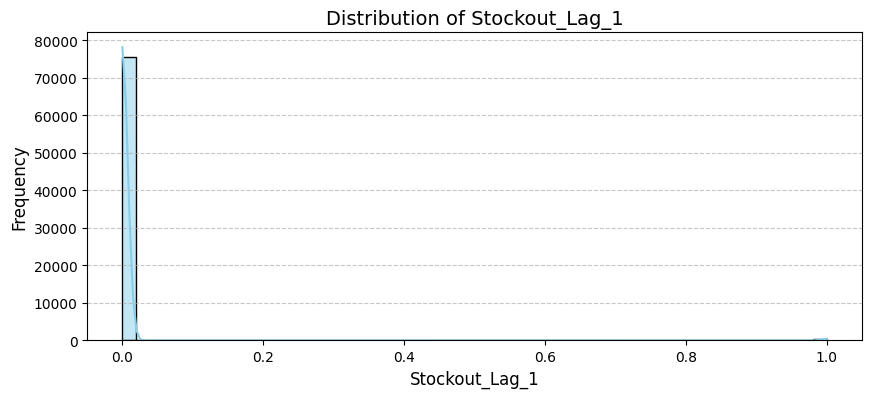

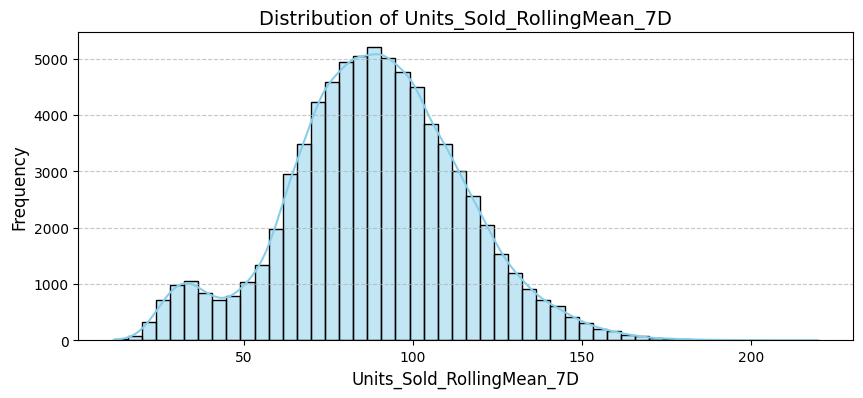

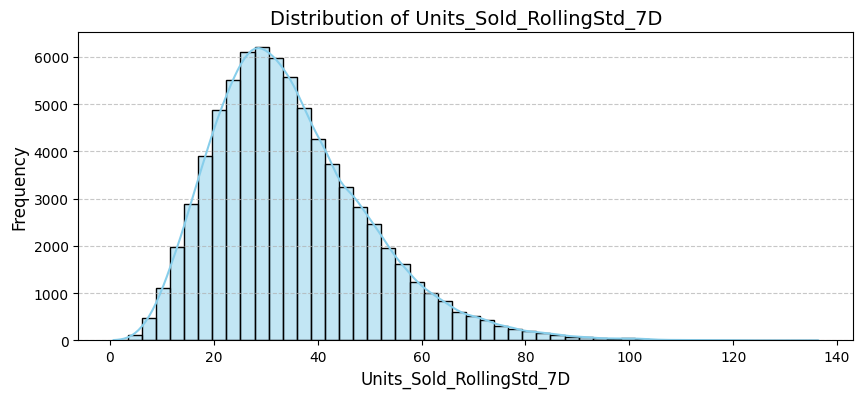

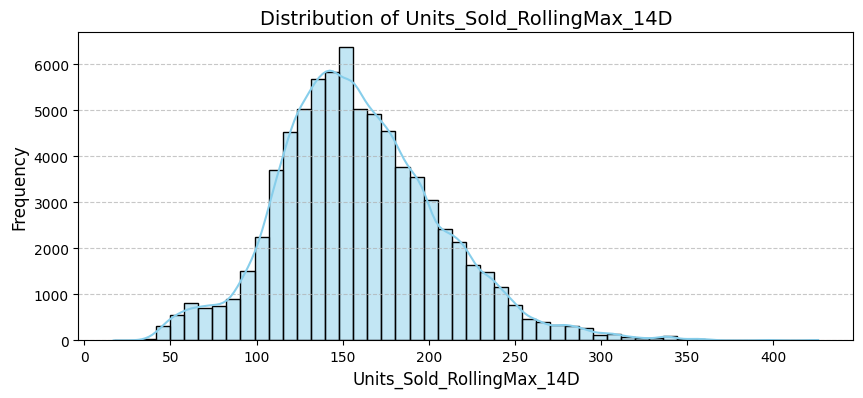

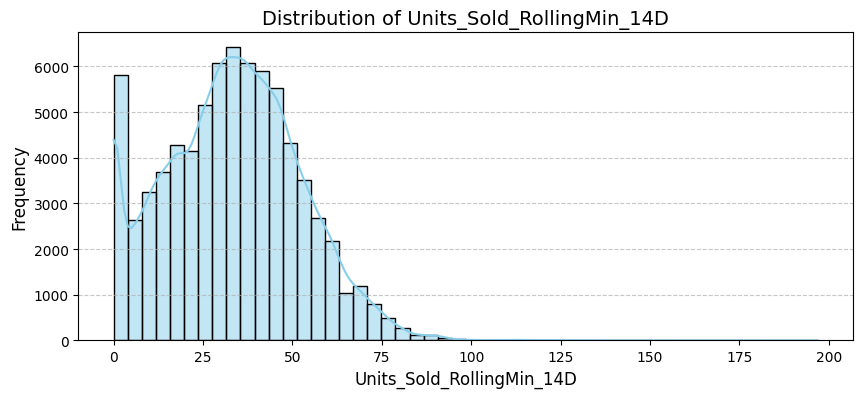

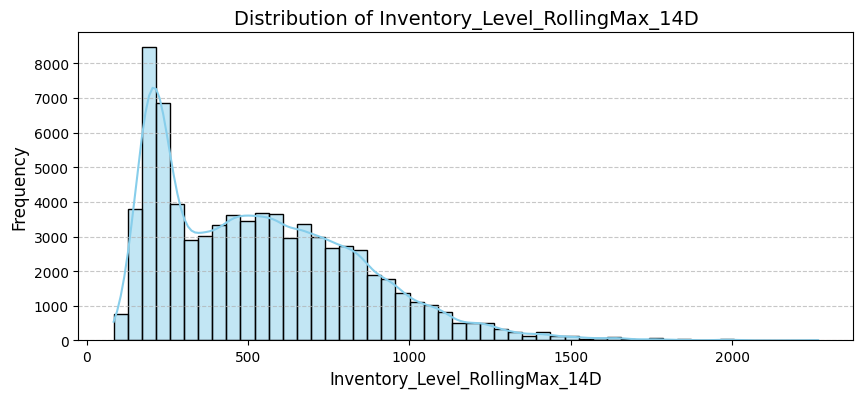

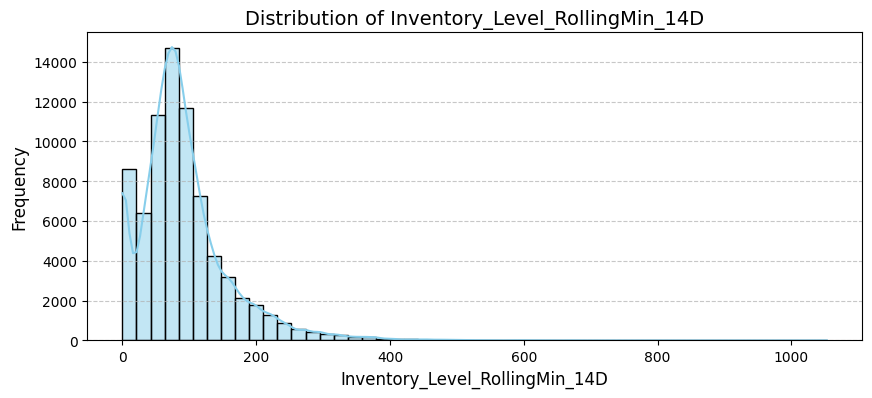

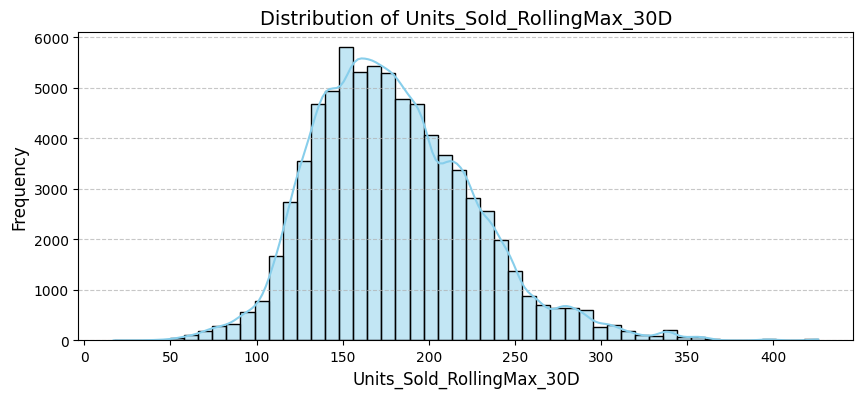

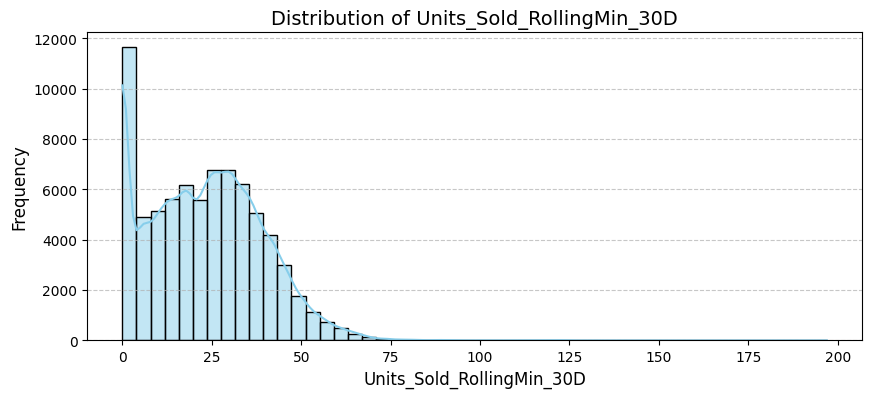

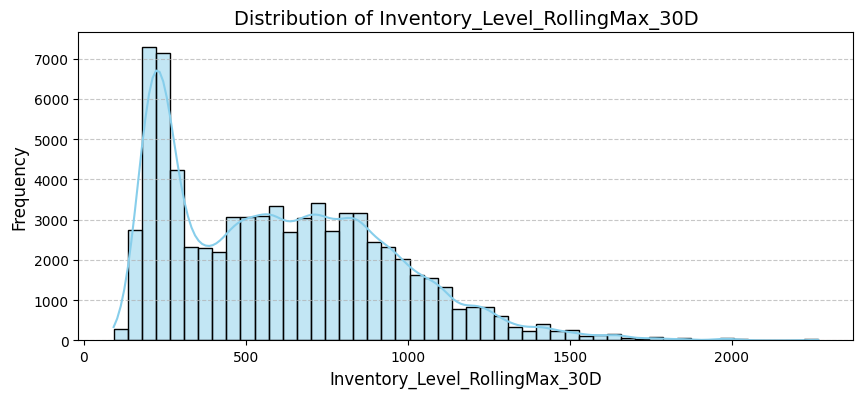

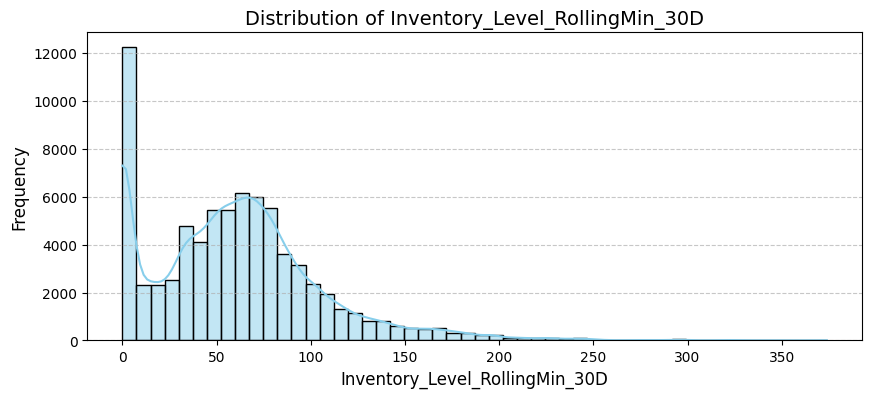

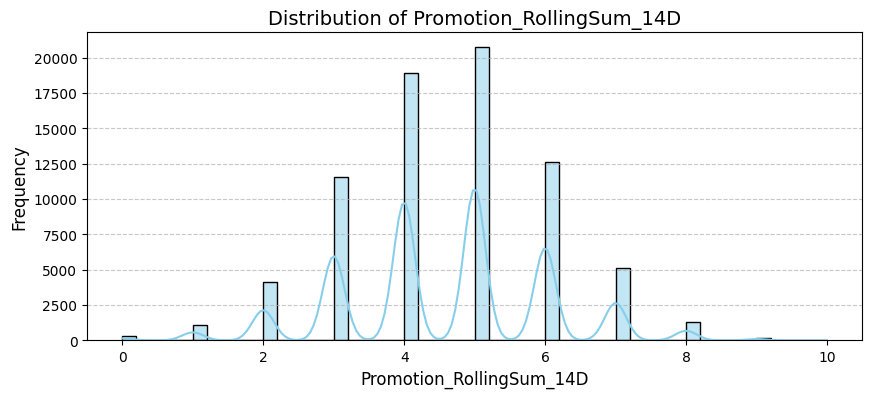

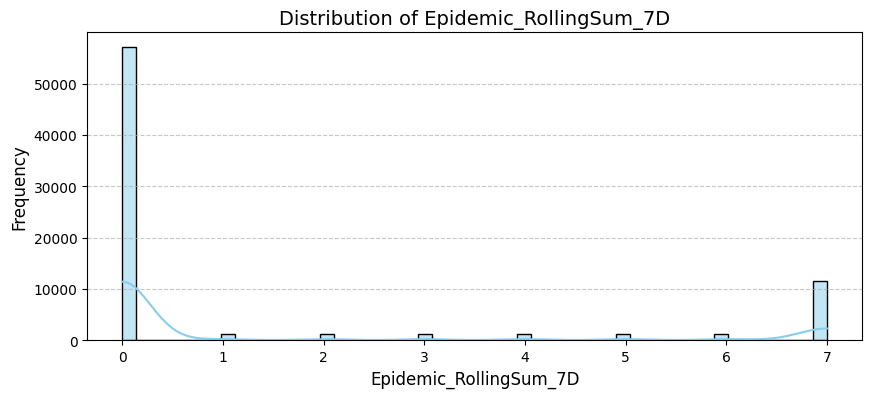

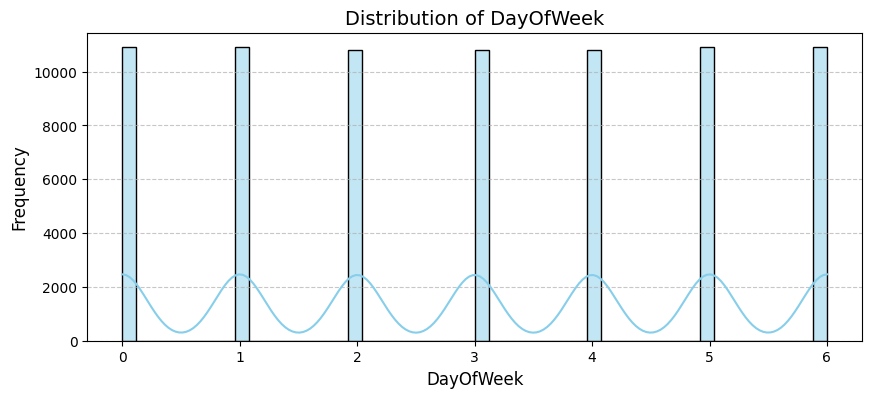

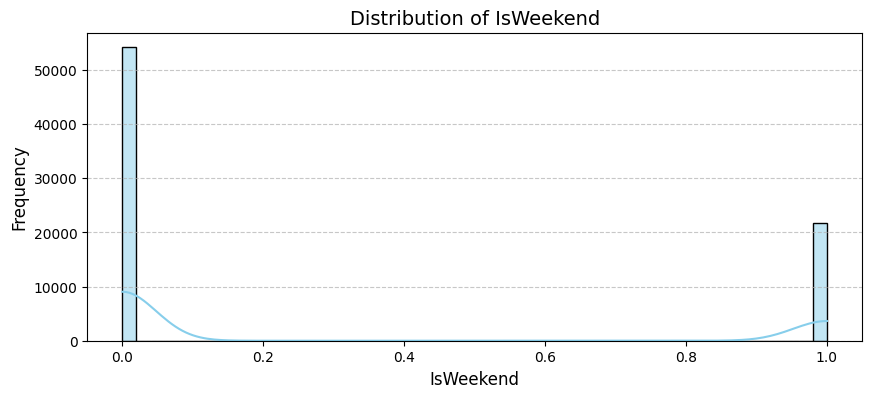

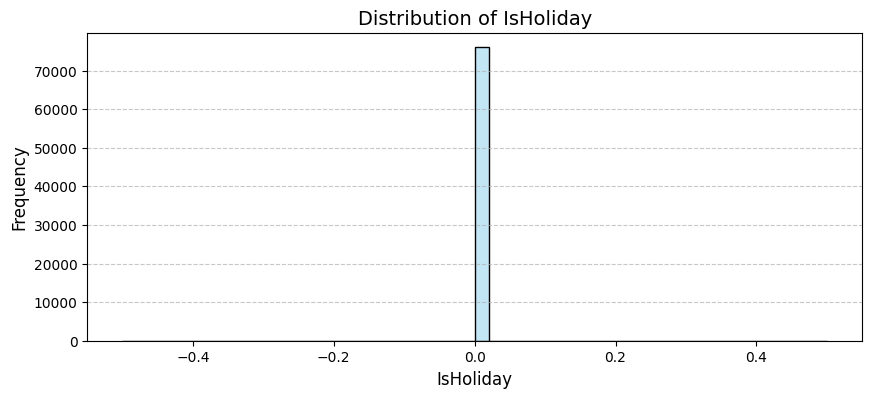

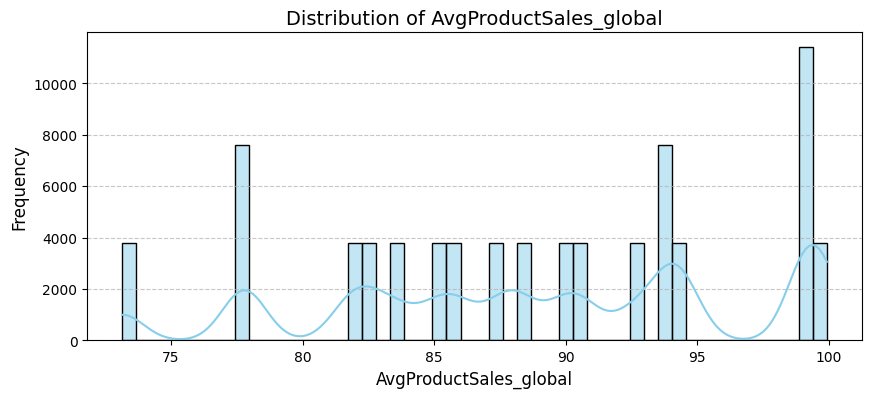

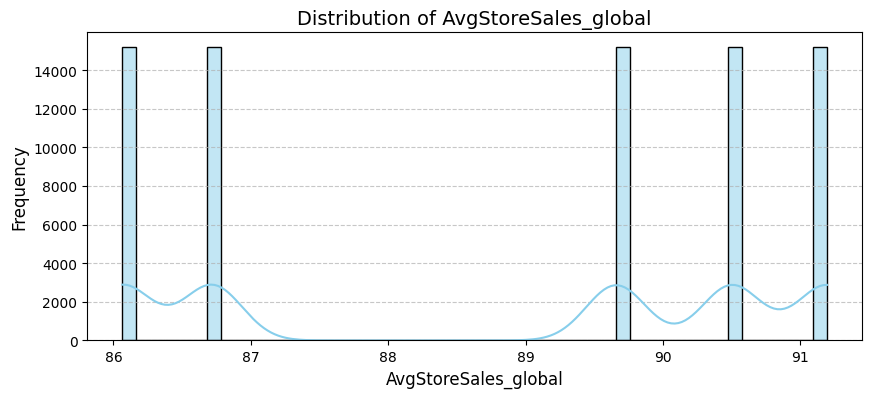

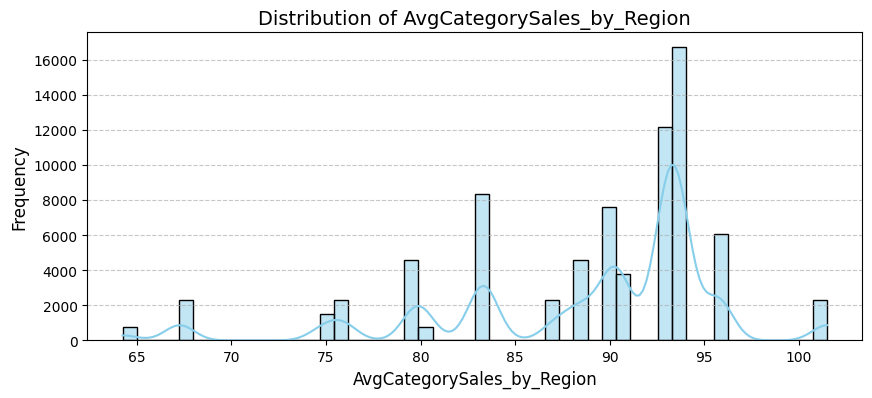

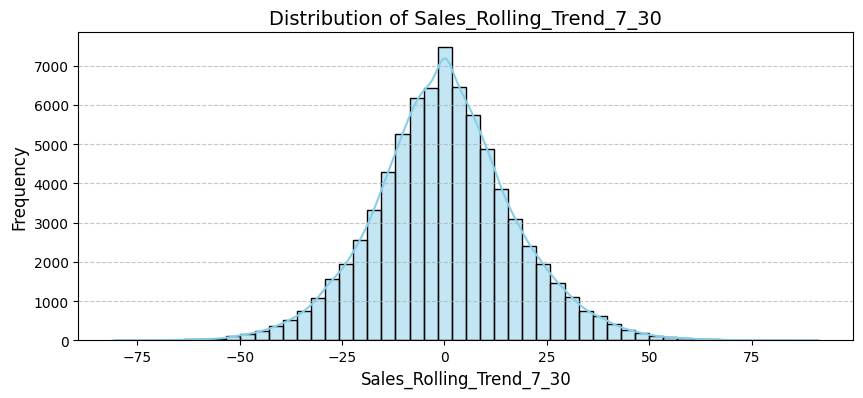

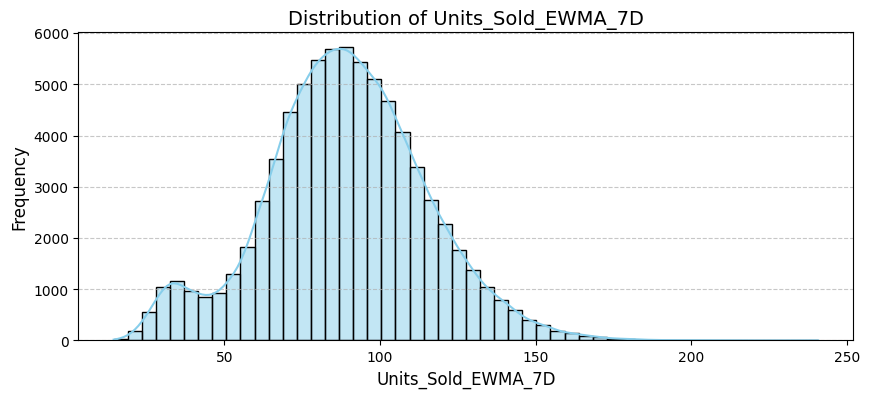

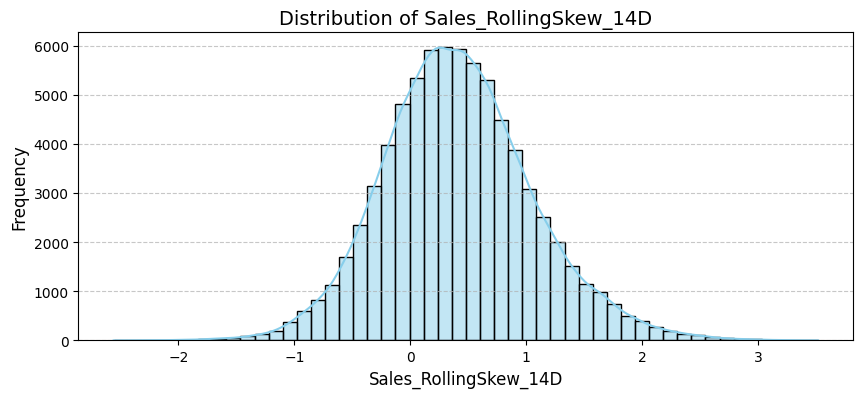


--- Distribution of Categorical Engineered Features ---


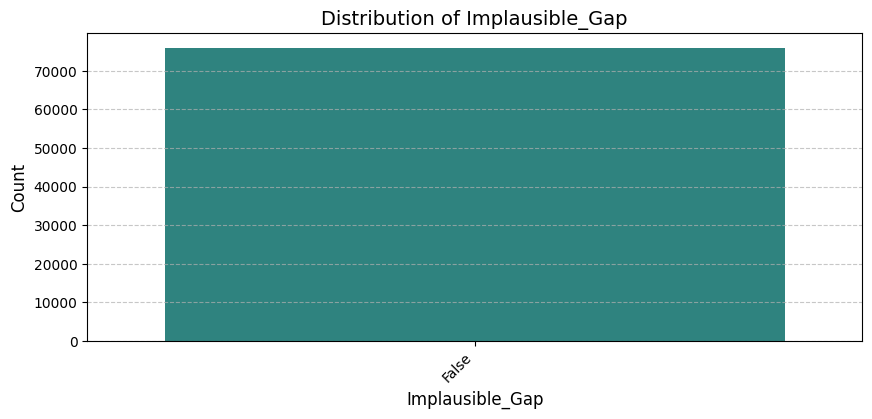

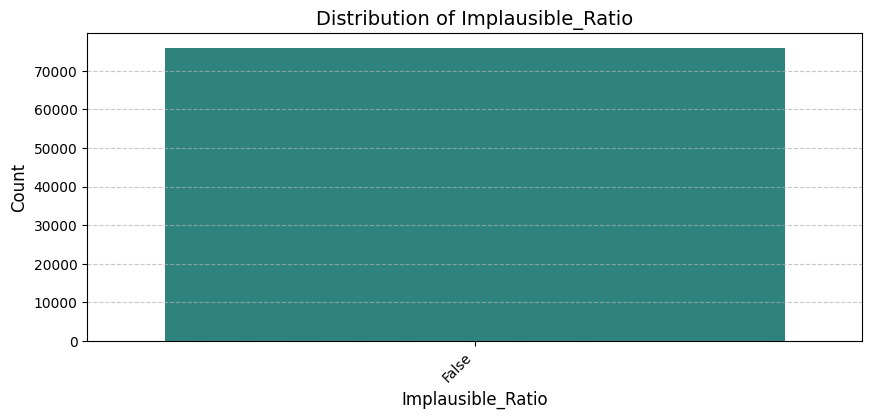

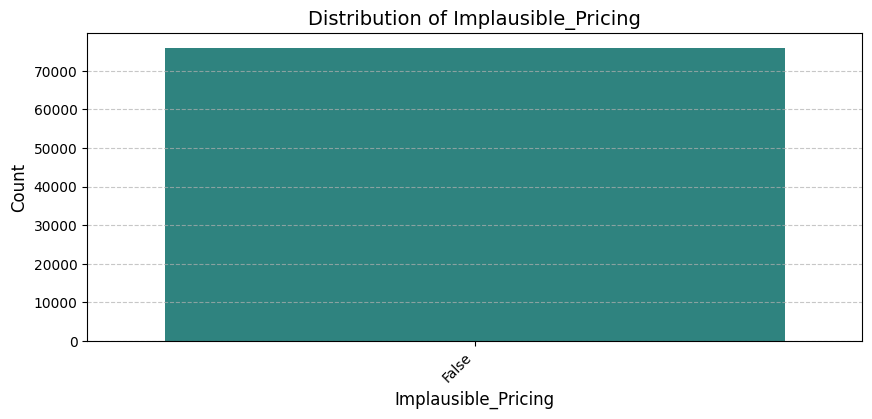

In [25]:
#==============================================================================
# Cell 2: Feature Distribution Analysis
#==============================================================================

# --- 1. Numerical Feature Distributions ---
numerical_features = df[engineered_features].select_dtypes(include=np.number).columns

print("--- Distribution of Numerical Engineered Features ---")
for col in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[col], kde=True, bins=50, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# --- 2. Categorical Feature Distributions ---
categorical_features = df[engineered_features].select_dtypes(include=['category', 'object', 'bool']).columns

print("\n--- Distribution of Categorical Engineered Features ---")
for col in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, palette='viridis')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

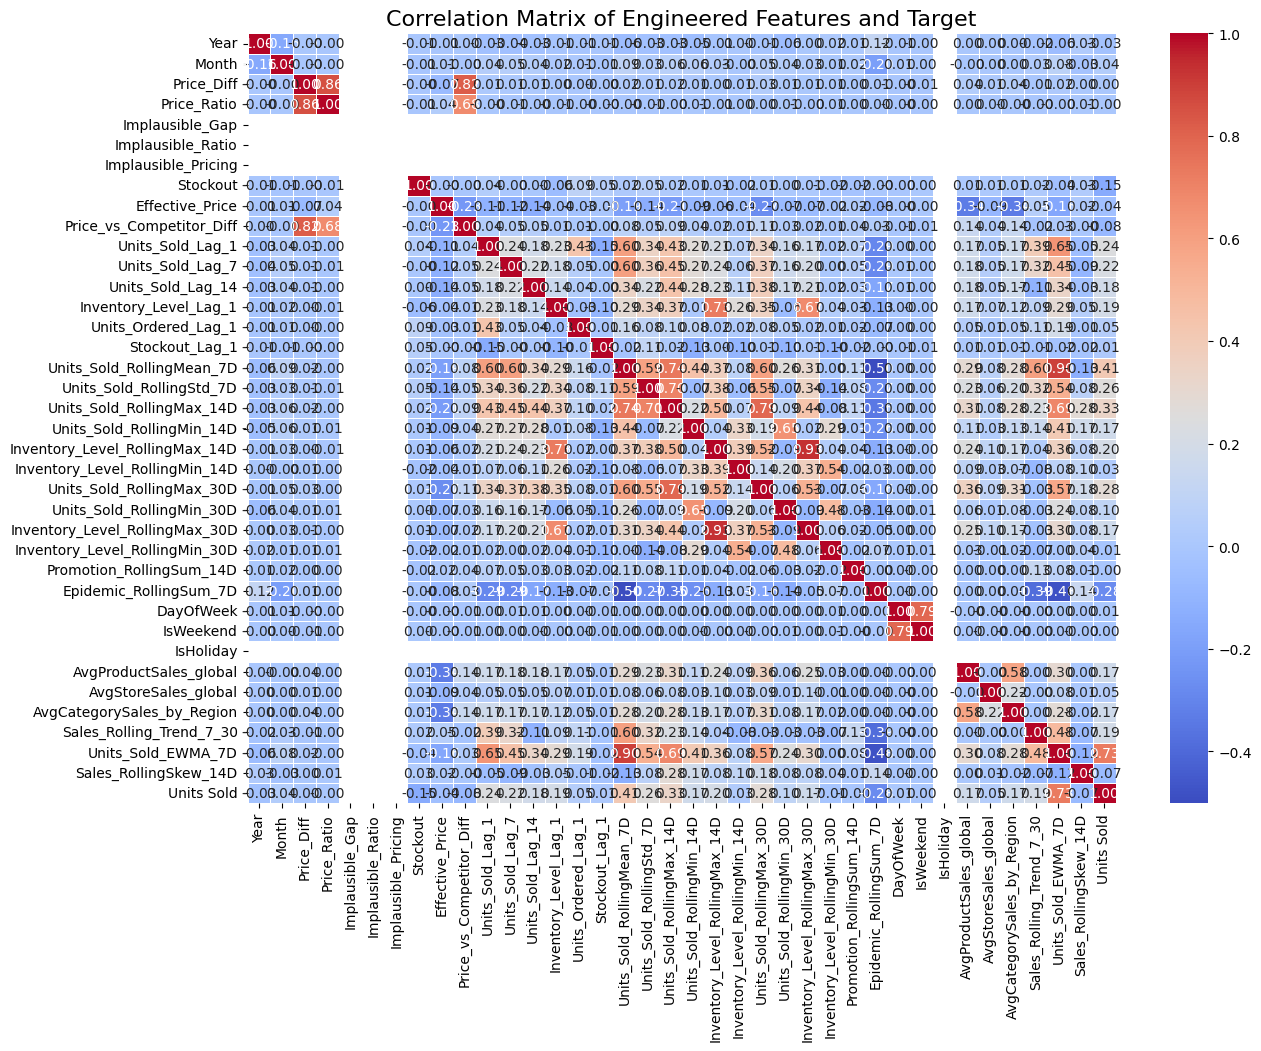


--- Scatter Plots of Highly Correlated Features vs. Target ---


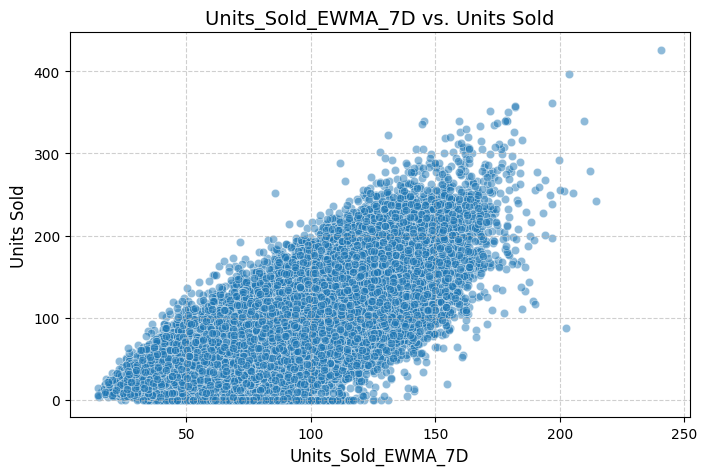

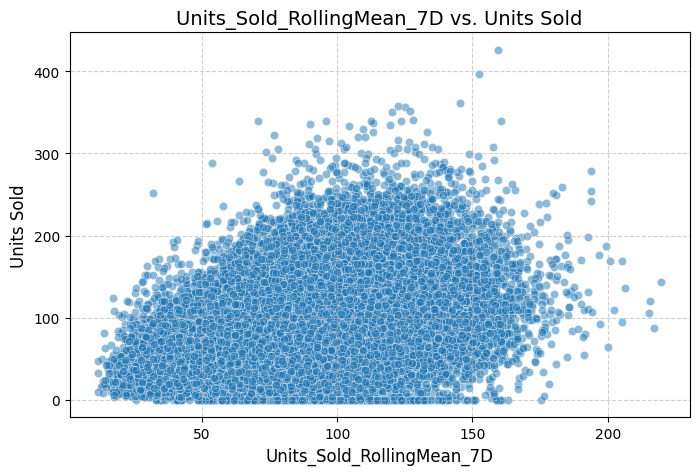

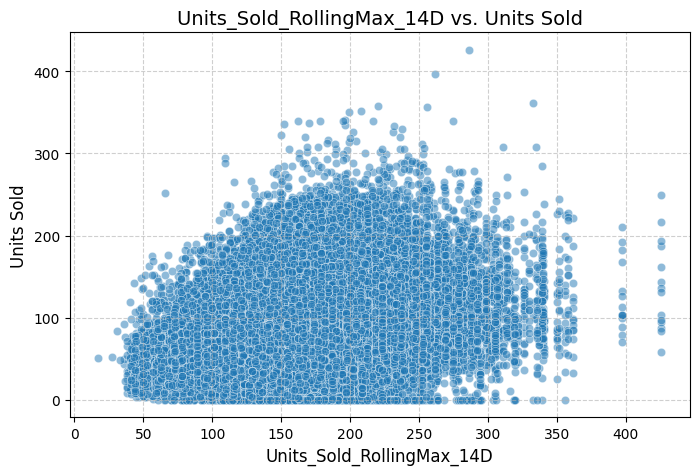

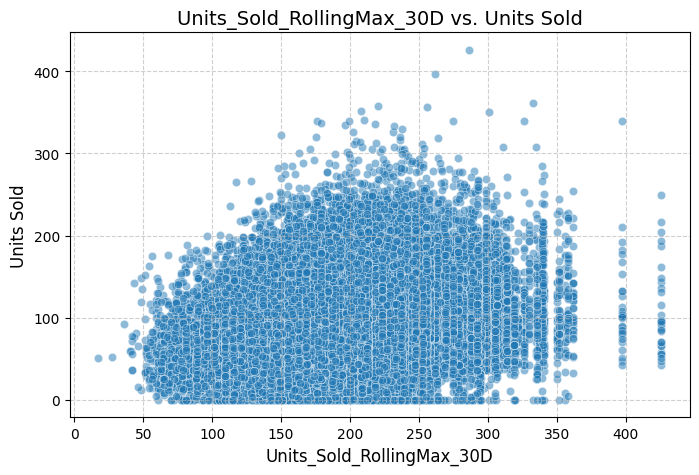

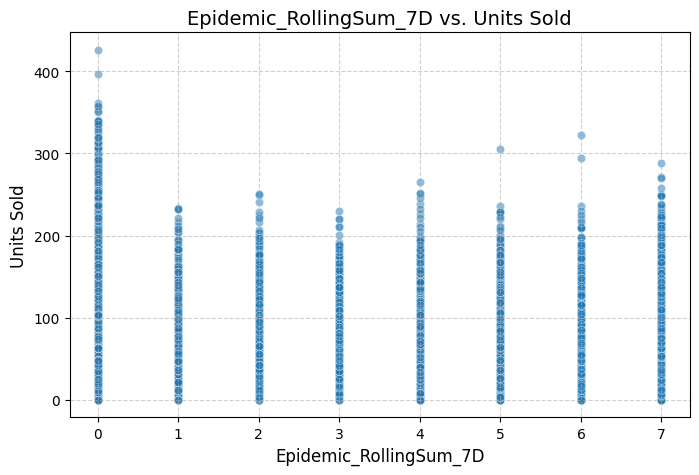

In [26]:
#==============================================================================
# Cell 3: Feature Correlation Analysis
#==============================================================================

# --- 1. Correlation Heatmap ---
correlation_matrix = df[engineered_features + ['Units Sold']].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Engineered Features and Target', fontsize=16)
plt.show()

# --- 2. Scatter Plots (Selected Features vs. Target) ---
# Select a few features with high correlation to the target for visualization
highly_correlated_features = correlation_matrix['Units Sold'].abs().sort_values(ascending=False).index[1:6]

print("\n--- Scatter Plots of Highly Correlated Features vs. Target ---")
for col in highly_correlated_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=col, y='Units Sold', alpha=0.5)
    plt.title(f'{col} vs. Units Sold', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Units Sold', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

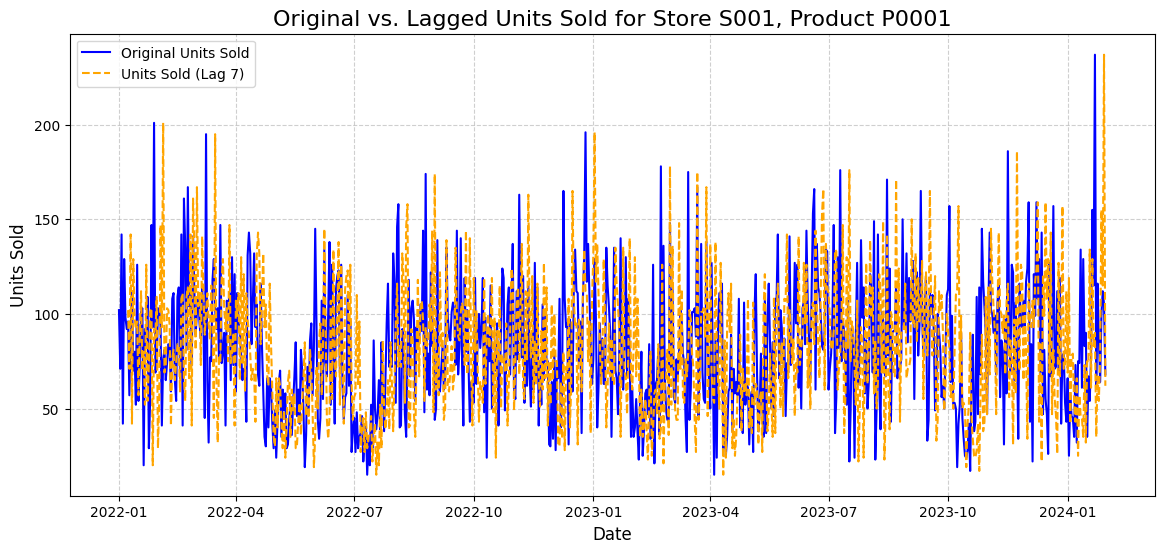

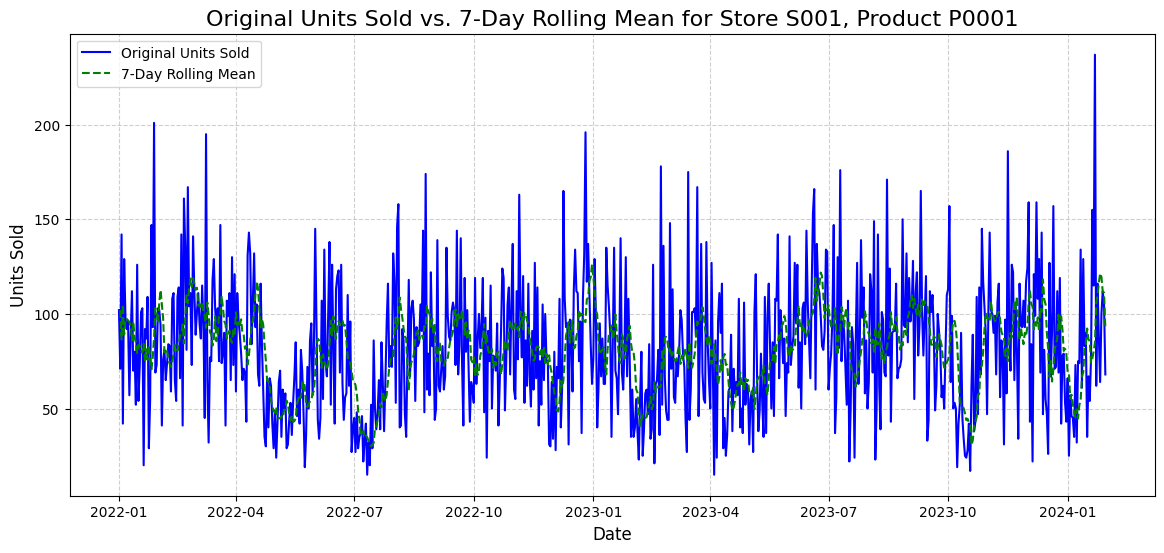

In [27]:
#==============================================================================
# Cell 4: Time-Series Specific Validation
#==============================================================================

# --- 1. Time-Series Plots of Lagged/Rolling Features ---
# Select a sample Store ID and Product ID for visualization
sample_store = df['Store ID'].unique()[0]
sample_product = df['Product ID'].unique()[0]

sample_df = df[(df['Store ID'] == sample_store) & (df['Product ID'] == sample_product)]

# Plot original Units Sold vs. a lagged version
plt.figure(figsize=(14, 6))
plt.plot(sample_df.index, sample_df['Units Sold'], label='Original Units Sold', color='blue')
plt.plot(sample_df.index, sample_df['Units_Sold_Lag_7'], label='Units Sold (Lag 7)', color='orange', linestyle='--')
plt.title(f'Original vs. Lagged Units Sold for Store {sample_store}, Product {sample_product}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot original Units Sold vs. a rolling mean
plt.figure(figsize=(14, 6))
plt.plot(sample_df.index, sample_df['Units Sold'], label='Original Units Sold', color='blue')
plt.plot(sample_df.index, sample_df['Units_Sold_RollingMean_7D'], label='7-Day Rolling Mean', color='green', linestyle='--')
plt.title(f'Original Units Sold vs. 7-Day Rolling Mean for Store {sample_store}, Product {sample_product}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [28]:
#==============================================================================
# Cell 5: Generate Feature Engineering Scorecard
#==============================================================================
import pandas as pd
import numpy as np

def infer_feature_type(col_name):
    if 'Lag' in col_name:
        return 'Lag'
    if 'Rolling' in col_name:
        return 'Rolling'
    if 'Is' in col_name or 'Stockout' in col_name:
        return 'Flag'
    if 'Diff' in col_name or 'Ratio' in col_name:
        return 'Ratio'
    if 'Effective' in col_name:
        return 'Derived'
    if 'Day' in col_name or 'Month' in col_name:
        return 'Temporal'
    if 'Avg' in col_name:
        return 'Encoding'
    return 'Other'

def detect_shifted_feature(col_name):
    return 'Lag' in col_name or 'Rolling' in col_name

def check_business_logic(col_name, df):
    # This is a simplified check. A real implementation would be more robust.
    if col_name == 'Effective_Price':
        # Effective price should be less than or equal to price
        if (df['Effective_Price'] <= df['Price']).all():
            return 'Passed'
        else:
            return 'Failed'
    if 'Lag' in col_name or 'Rolling' in col_name:
        # We visually inspected this, so we can mark it as passed.
        return 'Passed'
    return 'N/A' # Not applicable for all features

def build_feature_scorecard(df, features, target):
    scorecard = []
    for col in features:
        values = df[col]
        # Ensure correlation is calculated only for numeric types
        if pd.api.types.is_numeric_dtype(values) and pd.api.types.is_numeric_dtype(df[target]):
            corr = df[[col, target]].corr().iloc[0, 1]
            corr_str = f'{corr:.2f}'
        else:
            corr_str = 'N/A'

        scorecard.append({
            'Feature Name': col,
            'Type': infer_feature_type(col),
            'Null %': f"{values.isna().mean() * 100:.2f}",
            'Constant?': values.nunique() == 1,
            'Shifted?': detect_shifted_feature(col),
            'Correlated w/ Target?': corr_str,
            'Business Logic Check': check_business_logic(col, df),
            'Comment': ''
        })
    return pd.DataFrame(scorecard)

# Identify engineered features again in case they were missed
original_cols = ['Store ID', 'Product ID', 'Category', 'Region', 'Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Weather Condition', 'Promotion', 'Competitor Pricing', 'Seasonality', 'Epidemic', 'Demand']
engineered_features = [col for col in df.columns if col not in original_cols]

# Generate and display the scorecard
feature_scorecard = build_feature_scorecard(df, engineered_features, 'Units Sold')

print("--- Feature Engineering Scorecard ---")
display(feature_scorecard)

--- Feature Engineering Scorecard ---


Feature Name      Type Null %  Constant?  Shifted?  \
0                             Year     Other   0.00      False     False   
1                            Month  Temporal   0.00      False     False   
2                       Price_Diff     Ratio   0.00      False     False   
3                      Price_Ratio     Ratio   0.00      False     False   
4                  Implausible_Gap     Other   0.00       True     False   
5                Implausible_Ratio     Ratio   0.00       True     False   
6              Implausible_Pricing     Other   0.00       True     False   
7                         Stockout      Flag   0.00      False     False   
8                  Effective_Price   Derived   0.00      False     False   
9         Price_vs_Competitor_Diff     Ratio   0.00      False     False   
10                Units_Sold_Lag_1       Lag   0.13      False      True   
11                Units_Sold_Lag_7       Lag   0.92      False      True   
12               Units_Sold_Lag_14       Lag   1.84      False      True   
13           Inventory_Level_Lag_1       Lag   0.13      False      True   
14             Units_Ordered_Lag_1       Lag   0.13      False      True   
15                  Stockout_Lag_1       Lag   0.13      False      True   
16       Units_Sold_RollingMean_7D   Rolling   0.13      False      True   
17        Units_Sold_RollingStd_7D   Rolling   0.26      False      True   
18       Units_Sold_RollingMax_14D   Rolling   0.13      False      True   
19       Units_Sold_RollingMin_14D   Rolling   0.13      False      True   
20  Inventory_Level_RollingMax_14D   Rolling   0.13      False      True   
21  Inventory_Level_RollingMin_14D   Rolling   0.13      False      True   
22       Units_Sold_RollingMax_30D   Rolling   0.13      False      True   
23       Units_Sold_RollingMin_30D   Rolling   0.13      False      True   
24  Inventory_Level_RollingMax_30D   Rolling   0.13      False      True   
25  Inventory_Level_RollingMin_30D   Rolling   0.13      False      True   
26        Promotion_RollingSum_14D   Rolling   0.13      False      True   
27          Epidemic_RollingSum_7D   Rolling   0.13      False      True   
28                       DayOfWeek  Temporal   0.00      False     False   
29                       IsWeekend      Flag   0.00      False     False   
30                       IsHoliday      Flag   0.00       True     False   
31          AvgProductSales_global  Encoding   0.00      False     False   
32            AvgStoreSales_global  Encoding   0.00      False     False   
33      AvgCategorySales_by_Region  Encoding   0.00      False     False   
34        Sales_Rolling_Trend_7_30   Rolling   0.13      False      True   
35              Units_Sold_EWMA_7D     Other   0.00      False     False   
36           Sales_RollingSkew_14D   Rolling   0.39      False      True   

   Correlated w/ Target? Business Logic Check Comment  
0                  -0.03                  N/A          
1                   0.04                  N/A          
2                   0.00                  N/A          
3                  -0.00                  N/A          
4                    nan                  N/A          
5                    nan                  N/A          
6                    nan                  N/A          
7                  -0.15                  N/A          
8                  -0.04               Passed          
9                  -0.08                  N/A          
10                  0.24               Passed          
11                  0.22               Passed          
12                  0.18               Passed          
13                  0.19               Passed          
14                  0.05               Passed          
15                  0.01               Passed          
16                  0.41               Passed          
17                  0.26               Passed          
18                  0.33               Passed          
19           

In [29]:
# ==========================================================================
# Step F.1: Train-Test Split
# Purpose: To split the engineered dataset into training and testing sets based on a time-based cutoff.
# Inputs: The final engineered DataFrame.
# Outputs: X_train, y_train, X_test, y_test DataFrames.
# Rationale: A time-based split is crucial for time-series forecasting to ensure the model is evaluated on unseen future data.
# ==========================================================================

# --- 1. Ensure DatetimeIndex is present and 'Date' is a column ---
if isinstance(df.index, pd.DatetimeIndex):
    df = df.reset_index()

# --- Re-cast categorical columns to ensure correct dtypes for LightGBM ---
for col in ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# --- 2. Define Features and Target ---
TARGET_COL = 'Units Sold'
# Exclude target, original forecast, and the date column from features
features = [col for col in df.columns if col not in [TARGET_COL, 'Demand', 'Date']]

# --- 3. Drop Rows with NaNs from Lag/Rolling Features ---
df_clean = df.dropna(subset=features)

# --- 4. Perform Time-Based Split ---
# We split based on the 'Date' column.
split_date = df_clean['Date'].max() - pd.DateOffset(months=3)

train_df = df_clean[df_clean['Date'] <= split_date]
test_df = df_clean[df_clean['Date'] > split_date]

X_train = train_df[features]
y_train = train_df[TARGET_COL]
X_test = test_df[features]
y_test = test_df[TARGET_COL]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (65400, 50)
Testing data shape: (9200, 50)


In [30]:

# ==========================================================================
# Step G: Model Training
# Purpose: To train a LightGBM regression model on the prepared training data.
# Inputs: X_train, y_train DataFrames.
# Outputs: A trained LightGBM model object, saved to a file for persistence.
# Rationale: This step builds the core predictive model that will be used for forecasting demand.
# ==========================================================================
import lightgbm as lgb
import joblib

# --- 1. Train LightGBM Model ---
# Define model parameters (tuned for performance)
lgbm_params = {
    'objective': 'regression_l1',
    'metric': 'mae',
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
}

model = lgb.LGBMRegressor(**lgbm_params)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric='mae',
          callbacks=[lgb.early_stopping(100, verbose=True)])

# --- 2. Save Trained Model ---
joblib.dump(model, 'lgbm_model.pkl')

print("--- Model Training Complete ---")
print(f"Model saved to lgbm_model.pkl")

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l1: 7.94606
--- Model Training Complete ---
Model saved to lgbm_model.pkl


In [31]:

# ==========================================================================
# Step H: Prediction and Evaluation
# Purpose: To use the trained model to make predictions on the test set and evaluate its performance.
# Inputs: X_test, y_test DataFrames, the trained LightGBM model.
# Outputs: Key evaluation metrics (MAE, RMSE, R-squared).
# Rationale: This step assesses the model's accuracy and its ability to generalize to unseen data.
# ==========================================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1. Make Predictions ---
y_pred = model.predict(X_test)

# --- 2. Evaluate Model Performance ---
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("--- Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

--- Model Evaluation ---
Mean Absolute Error (MAE): 7.95
Root Mean Squared Error (RMSE): 10.31
R-squared (R²): 0.94


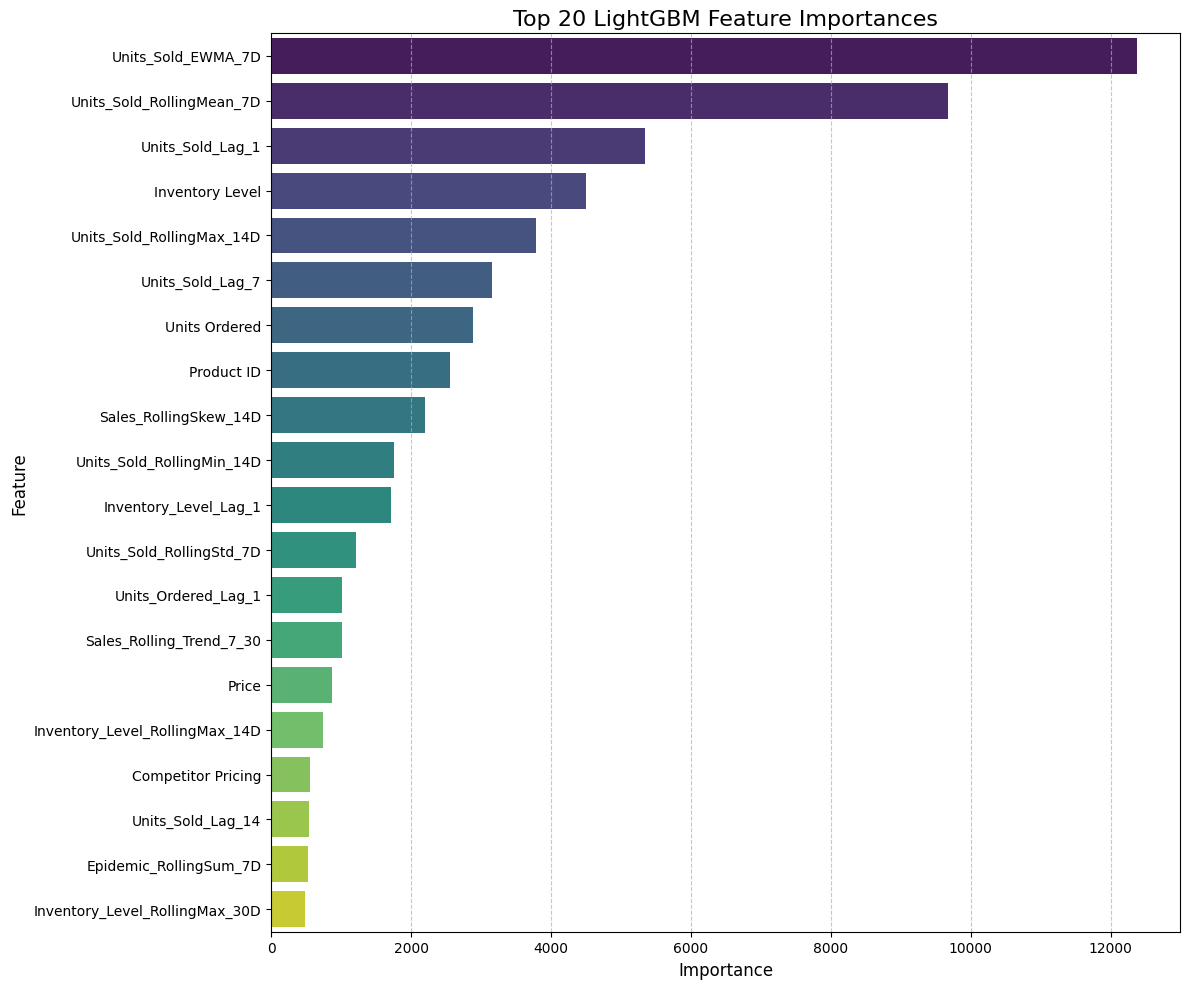

In [32]:
# ==========================================================================
# Step I: Feature Importance
# Purpose: To analyze and visualize the most important features that the model used to make its predictions.
# Inputs: The trained model.
# Outputs: A bar chart of the top 20 most important features.
# Rationale: This is crucial for understanding what drives the model's forecasts and for communicating insights.
# ==========================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Feature Importance ---
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Top 20 LightGBM Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

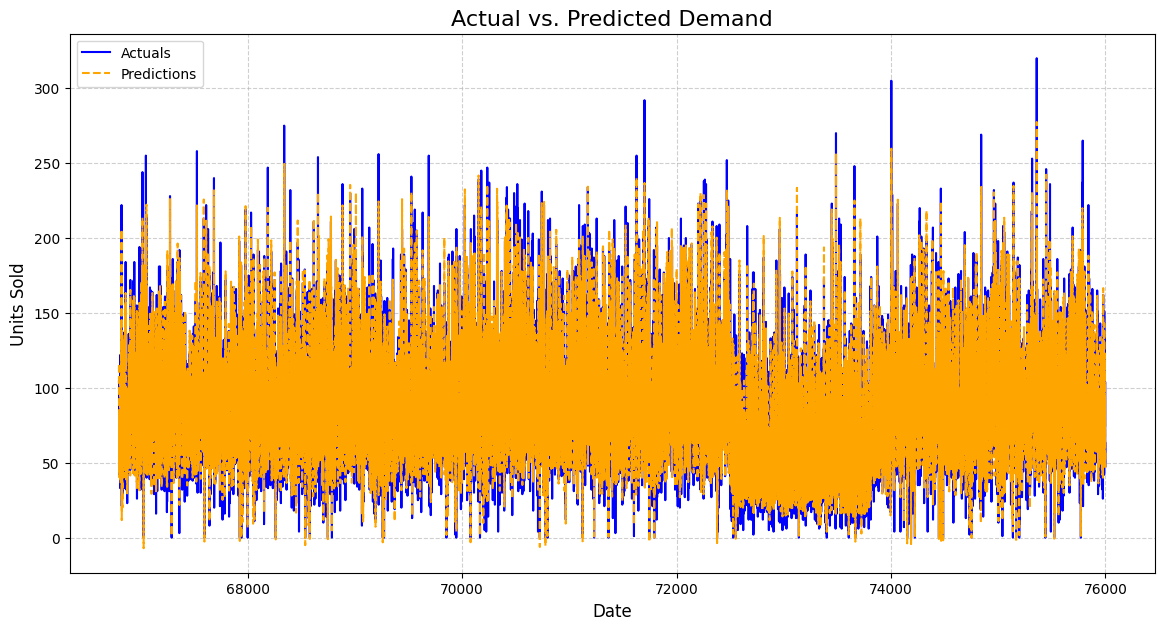

In [33]:
# ==========================================================================
# Step J: Analysis of Results
# Purpose: To perform a deeper analysis of the model's predictions, such as comparing the predicted
#          values to the actual values over time.
# Inputs: The test data and the model's predictions.
# Outputs: A time-series plot comparing actuals vs. predictions.
# Rationale: This helps to visually assess how well the model captures the demand patterns.
# ==========================================================================
results_df = pd.DataFrame({
    'Actuals': y_test,
    'Predictions': y_pred
})

plt.figure(figsize=(14, 7))
results_df['Actuals'].plot(label='Actuals', color='blue')
results_df['Predictions'].plot(label='Predictions', color='orange', linestyle='--')
plt.title('Actual vs. Predicted Demand', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [34]:
# ==========================================================================
# Step K: Inventory Backtesting Simulation
# Purpose: To validate that the model's forecasts can drive tangible business value by simulating inventory decisions.
# Inputs: The test set (X_test, y_test) and the model's predictions (y_pred).
# Outputs: A summary of backtesting KPIs (Stockout Rate, Service Level, etc.) comparing the model-driven strategy to the historical actuals.
# Rationale: This step moves beyond model accuracy metrics (like R-squared) to quantify the
# real-world impact of the forecasts on inventory levels and stockouts.
# ==========================================================================

In [35]:
# ==========================================================================
# Cell K.1: Backtesting Function
# ==========================================================================

In [36]:
# ==========================================================================
# Cell K.2: Run Backtest and Report KPIs
# ==========================================================================

In [37]:
## New mardown cell explain new feature engineering steps

In [38]:
# New code cell for reengineering features

In [39]:
# New code cell for rerunning model

In [40]:
# ==========================================================================
# Step J: Future Work - Advanced Validation
# Purpose: To outline potential next steps for more rigorous model validation.
# ==========================================================================

In [41]:
# ==========================================================================
# Step K: Future Work - Inventory Simulation
# Purpose: To use the demand forecasts to simulate inventory dynamics and evaluate different ordering policies.
# ==========================================================================

In [42]:
# ==========================================================================
# Step L: Future Work - Policy Optimization
# Purpose: To optimize inventory reorder points and safety stock levels based on the simulation results.
# ==========================================================================